# Imports

In [1]:
%matplotlib inline

import xarray as xr
import pandas as pd
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import axes
import numpy as np
import numpy.matlib

import plotly.express as px

import seaborn as sns
# sns.set_theme(style="whitegrid")
# sns.set(rc={"figure.dpi":200,})
# sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
# sns.set_context('notebook')

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from scipy import spatial

import random

# for regression P values
import statsmodels.api as sm
from sklearn_extra.cluster import KMedoids
from sklearn.feature_selection import chi2
from sklearn.metrics.pairwise import cosine_similarity

from scipy import stats
from scipy.cluster import hierarchy
from scipy.spatial import distance

In [2]:
# pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

In [3]:
# For plotting maps
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")
from mpl_toolkits.basemap import Basemap

# Data Cleaning Functions

In [4]:
def scale_values(arr):
    '''
    Scale an array between -1 to +1
    '''
    return 2.*(arr - np.min(arr))/np.ptp(arr)-1

In [5]:
def get_cell_range(start, end,cell_width =10):
    '''
    get the ranges of the cells
    '''
    num_iter = (abs(start) + abs(end))/cell_width
    range_lst = []
    for i in range(int(num_iter)+1):
        range_lst.append(start+i*cell_width)
#         print(start+i*cell_width)
    return range_lst

In [6]:
def get_year_month(df, yrmonth):
    df['time_counter'] = df['time_counter'].astype("string")
    df = df.loc[df['time_counter'].str.contains(yrmonth, case=False)]
    return df.reset_index()

In [7]:
def round_nav_lat(df):
    '''
    Round up the coordinates to 2 decimal places
    '''
    df['nav_lat'] = df['nav_lat'].apply(lambda x:round(x,2))
    df['nav_lon'] = df['nav_lon'].apply(lambda x:round(x,2))
    return df

# Regression model

## Random Forest Regression

In [8]:
from sklearn.ensemble import RandomForestRegressor

def fit_random_forest_regression(grids_df_lst,feat_names,target):
    grid_reg_score = []
    grid_reg_coef = []
    
    data_count = []
    
    count = 0
    
    for grid_i in grids_df_lst:
        
        X = grid_i[feat_names].values
        y = np.array(grid_i[target].values)
   
        if np.isnan(X).any():
            print(X)
            raise ValueError
        
        if (len(X) == 0) or (len(y) == 0):
            grid_reg_score.append(None)
            grid_reg_coef.append(None)
        else:
        
            rf = RandomForestRegressor(n_estimators=150)
            rf.fit(X, y)

            grid_reg_score.append(rf.score(X, y))
            grid_reg_coef.append(rf.feature_importances_)
        data_count.append(len(X))
    
    
    
    df_column_names = ['cell_id','lon_min','lon_max','lat_min','lat_max', 'data_count',
                       'reg_score','reg_coef']        
    save_df = pd.DataFrame(columns=df_column_names)
    
    nav_lat_max_lst = []
    nav_lat_min_lst = []
    nav_lon_max_lst = []
    nav_lon_min_lst = []

    for grid_i in grids_df_lst:
        nav_lat_max_lst.append(grid_i['nav_lat'].max())
        nav_lat_min_lst.append(grid_i['nav_lat'].min())
        nav_lon_max_lst.append(grid_i['nav_lon'].max())
        nav_lon_min_lst.append(grid_i['nav_lon'].min())
    
    save_df['cell_id'] = range(0, len(grids_df_lst))
    save_df['lon_min'] = nav_lon_min_lst
    save_df['lon_max'] = nav_lon_max_lst
    save_df['lat_min'] = nav_lat_min_lst
    save_df['lat_max'] = nav_lat_max_lst
    save_df['data_count'] = data_count
    
    save_df['reg_score'] = grid_reg_score
    save_df['reg_coef'] = grid_reg_coef
    
    print("Returning values: ", df_column_names)
    return save_df


## MV Linear regression

In [9]:

from scipy import stats
from sklearn.feature_selection import chi2


def fit_multivariate_lin_regression(grids_df_lst,feat_names,target, is_natural):
    '''
    https://satishgunjal.com/multivariate_lr_scikit/ 
    '''
    # Fit Regression model
    grid_reg_score = []
    grid_reg_coef = []
    grid_reg_intercept = []
    
    p_values_intercept = []
    p_values_sst = []
    p_values_dic = []
    p_values_alk = []
#     p_values_sal = []
    
    data_count = []
    
    count = 0
    
    for grid_i in grids_df_lst:
#         feat_lst=[]
#         for index, row in grid_i.iterrows():
#             row_feat_lst = [row[feat] for feat in feat_names]
#             feat_lst.append(np.array(row_feat_lst))
        
#         X = grid_i.values[:,2:5]
        X = grid_i[feat_names].values
        y = np.array(grid_i[target].values)
   
        if np.isnan(X).any():
            print(X)
            raise ValueError
        
        if (len(X) == 0) or (len(y) == 0) or(len(X) == 1) or (len(y) == 1) :
            grid_reg_score.append(None)
            grid_reg_coef.append(None)
            grid_reg_intercept.append(None)
            p_values_intercept.append(None)
            p_values_sst.append(None)
            p_values_dic.append(None)
            p_values_alk.append(None)
#             p_values_sal.append(None)
            
            data_count.append(len(X))
            
        else:
            data_count.append(len(X))
        
            # y = mX + c
            lin_reg = linear_model.LinearRegression().fit(X, y)
#             lin_reg = linear_model.Ridge(alpha=1.0).fit(X, y)

            X2 = sm.add_constant(X)
            est = sm.OLS(y, X2).fit()
            _p_ = est.pvalues
                
            p_values_intercept.append(_p_[0])
            p_values_sst.append(_p_[1])
            p_values_dic.append(_p_[2])
            p_values_alk.append(_p_[3])
#             p_values_sal.append(_p_[4])
            
            grid_reg_coef.append(lin_reg.coef_) #slope m
            grid_reg_intercept.append(lin_reg.intercept_) #intercept c
            grid_reg_score.append(lin_reg.score(X, y)) #quality or a confidence score
               
            count = count + 1
    
    
    df_column_names = ['cell_id','lon_min','lon_max','lat_min','lat_max', 'data_count',
                       'reg_score','reg_coef', 'reg_intercept','p_intercept']
    
    for fn in feat_names:
        df_column_names.append(f"p_{fn}")
        
    print("Returning values: ", df_column_names)
        
    save_df = pd.DataFrame(columns=df_column_names)
    nav_lat_max_lst = []
    nav_lat_min_lst = []
    nav_lon_max_lst = []
    nav_lon_min_lst = []

    for grid_i in grids_df_lst:
        nav_lat_max_lst.append(grid_i['nav_lat'].max())
        nav_lat_min_lst.append(grid_i['nav_lat'].min())
        nav_lon_max_lst.append(grid_i['nav_lon'].max())
        nav_lon_min_lst.append(grid_i['nav_lon'].min())
    
    save_df['cell_id'] = range(0, len(grids_df_lst))
    save_df['lon_min'] = nav_lon_min_lst
    save_df['lon_max'] = nav_lon_max_lst
    save_df['lat_min'] = nav_lat_min_lst
    save_df['lat_max'] = nav_lat_max_lst
    save_df['data_count'] = data_count
    
    save_df['reg_score'] = grid_reg_score
    save_df['reg_coef'] = grid_reg_coef
    save_df['reg_intercept'] = grid_reg_intercept
    
    save_df['p_intercept'] = p_values_intercept
    save_df['p_sst'] = p_values_sst
    if is_natural:
        save_df['p_dicp'] = p_values_dic
    else:
        save_df['p_dic'] = p_values_dic
    save_df['p_alk'] = p_values_alk
#     save_df['p_sal'] = p_values_sal
        
    return save_df


In [10]:
def save_results(feat_names,target,grids_df_lst,grid_reg_score, grid_reg_coef, grid_reg_intercept,month,cell_width):
    save_df = pd.DataFrame(columns=['cell_id','lon_min','lon_max','lat_min','lat_max',
                                'reg_score','reg_coef', 'reg_intercept'])
    nav_lat_max_lst = []
    nav_lat_min_lst = []
    nav_lon_max_lst = []
    nav_lon_min_lst = []

    for grid_i in grids_df_lst:
        nav_lat_max_lst.append(grid_i['nav_lat'].max())
        nav_lat_min_lst.append(grid_i['nav_lat'].min())
        nav_lon_max_lst.append(grid_i['nav_lon'].max())
        nav_lon_min_lst.append(grid_i['nav_lon'].min())
    
    save_df['cell_id'] = range(0, len(grids_df_lst))
    save_df['lon_min'] = nav_lon_min_lst
    save_df['lon_max'] = nav_lon_max_lst
    save_df['lat_min'] = nav_lat_min_lst
    save_df['lat_max'] = nav_lat_max_lst
    save_df['reg_score'] = grid_reg_score
    save_df['reg_coef'] = grid_reg_coef
    save_df['reg_intercept'] = grid_reg_intercept
    
    feat = '_'.join(feat_names)
    
    filepath = f"../csv_files/reg_model_{month}_{cell_width}_{target}_{feat}.csv"
    save_df.to_csv(filepath)
    print(f"\n File saved at {filepath}")
    return save_df

In [11]:
def build_grids(df_month,cell_width=2):
    # Prepare the cells
    nav_lat_grids = get_cell_range(start = -90, end = 90 ,cell_width = cell_width)
    nav_lon_grids = get_cell_range(start = -180, end = 180 ,cell_width = cell_width)
    
    if nav_lat_grids[-1] != 90:
        nav_lat_grids.append(90)
        
    if nav_lon_grids[-1] != 180:
        nav_lon_grids.append(180)
        
    # Build the grids. Store in a list.
    grids_df_lst=[]
    for lat_i in range(len(nav_lat_grids)):
        for lon_j in range(len(nav_lon_grids)):
            if((nav_lat_grids[lat_i] == 90) or (nav_lon_grids[lon_j] == 180)):
                break
            elif ((lat_i == len(nav_lat_grids) - 1) or (lon_j == len(nav_lon_grids) - 1)):
                break
            else:
                _df_ = df_month.loc[
                    (df_month['nav_lat'] >= nav_lat_grids[lat_i]) & 
                    (df_month['nav_lat'] <  nav_lat_grids[lat_i+1]) &
                    (df_month['nav_lon'] >= nav_lon_grids[lon_j]) & 
                    (df_month['nav_lon'] <  nav_lon_grids[lon_j+1])
                                ]
                grids_df_lst.append(_df_)
    
    print(f"\n Total no. of generated cells: {len(grids_df_lst)}")
    
    return grids_df_lst

In [12]:
def run_model(model_df, feat_names, target, cell_width, is_natural):
    # build grid cells
    grids_df_lst = build_grids(model_df,cell_width)
    # fit linear regression
    save_df = fit_multivariate_lin_regression(grids_df_lst,feat_names,target, is_natural)   
    return save_df, grids_df_lst

# Load the data

In [13]:
months_12 = {
            'jan':'-01-',
            'feb':'-02-',
            'mar':'-03-',
            'apr':'-04-',
            'may':'-05-',
            'jun':'-06-',
            'jul':'-07-',
            'aug':'-08-',
            'sep':'-09-',
            'oct':'-10-',
            'nov':'-11-',
            'dec':'-12-',
}

In [16]:
_year = 2009
_month = 'jan'

In [18]:
# data_df = pd.read_pickle(f"../dataset/pickeled_files/data_{_year}_df.pkl")
# data_df = pd.read_pickle(f"../dataset/pickeled_files/data_{_year}_025_df.pkl")
# data_df = pd.read_pickle(f"../dataset/pickeled_files/demo_025_e1e2_{_year}_df.pkl")
data_df = pd.read_pickle(f"../dataset/1958_2018_ORCA025_pickles/orca025_{_year}_df.pkl")

data_df

nav_lat  nav_lon        time_counter  sosstsst        SAL  \
0        -76.954163  -179.75 2009-01-16 12:00:00 -0.531698  31.509146   
1        -76.954163  -179.75 2009-02-15 00:00:00 -1.696136  31.534531   
2        -76.954163  -179.75 2009-03-16 12:00:00 -1.753140  32.526245   
3        -76.954163  -179.75 2009-04-16 00:00:00 -1.781304  32.905499   
4        -76.954163  -179.75 2009-05-16 12:00:00 -1.800874  33.109154   
...             ...      ...                 ...       ...        ...   
10825663  89.947868    73.00 2009-08-16 12:00:00 -1.737293  31.694172   
10825664  89.947868    73.00 2009-09-16 00:00:00 -1.735884  31.761625   
10825665  89.947868    73.00 2009-10-16 12:00:00 -1.731631  31.828535   
10825666  89.947868    73.00 2009-11-16 00:00:00 -1.729064  31.919580   
10825667  89.947868    73.00 2009-12-16 12:00:00 -1.725574  32.036194   

               ICE         DICP          DIC          ALK    fco2_pre  \
0         0.000000  1952.550293  1985.440918  2115.781982  227.253235   
1         0.116866  1989.338623  2025.503662  2151.595459  223.016754   
2         0.188017  2013.723389  2050.717529  2171.659180  239.002304   
3         0.483037  2037.355591  2073.734863  2188.074219  256.410919   
4         0.499002  2038.379517  2074.020264  2184.694092  264.853516   
...            ...          ...          ...          ...         ...   
10825663  0.962176  1969.277710  2011.169067  2091.169434  283.875336   
10825664  0.953113  1973.121704  2014.998901  2094.587891  286.058380   
10825665  0.970578  1974.323730  2016.224121  2095.690186  287.076385   
10825666  0.946175  1979.029663  2020.910767  2100.244629  289.111969   
10825667  0.986261  1983.907227  2025.751221  2105.434814  290.471313   

                fco2           e1t           e2t  
0         286.713104   6275.247070   6275.247070  
1         287.995819   6275.247070   6275.247070  
2         310.649536   6275.247070   6275.247070  
3         332.957581   6275.247070   6275.247070  
4         343.036804   6275.247070   6275.247070  
...              ...           ...           ...  
10825663  398.311676  12130.954102  10928.788086  
10825664  401.294006  12130.954102  10928.788086  
10825665  402.734741  12130.954102  10928.788086  
10825666  405.318848  12130.954102  10928.788086  
10825667  406.667908  12130.954102  10928.788086  

[10825668 rows x 13 columns]

In [15]:
# _year = 'all'
# _month = 'all'
# data_df = pd.read_pickle(f"../dataset/pickeled_files/data_clim_2009_2018_orca025_df.pkl")
# data_df

In [19]:
# Select DICP above 1500
data_df = data_df.loc[data_df['DICP'] >= 1500]
# data_df = data_df.loc[data_df['DIC'] >= 1500]
# Select ALK above 1700
data_df = data_df.loc[data_df['ALK'] >= 1700]
# Select SST below 40
data_df = data_df.loc[data_df['sosstsst'] <= 40]
# Select fco2 below 500
data_df = data_df.loc[data_df['fco2_pre'] <= 500]
# data_df = data_df.loc[data_df['fco2'] <= 500]
data_df

nav_lat  nav_lon        time_counter  sosstsst        SAL  \
0        -76.954163  -179.75 2009-01-16 12:00:00 -0.531698  31.509146   
1        -76.954163  -179.75 2009-02-15 00:00:00 -1.696136  31.534531   
2        -76.954163  -179.75 2009-03-16 12:00:00 -1.753140  32.526245   
3        -76.954163  -179.75 2009-04-16 00:00:00 -1.781304  32.905499   
4        -76.954163  -179.75 2009-05-16 12:00:00 -1.800874  33.109154   
...             ...      ...                 ...       ...        ...   
10825663  89.947868    73.00 2009-08-16 12:00:00 -1.737293  31.694172   
10825664  89.947868    73.00 2009-09-16 00:00:00 -1.735884  31.761625   
10825665  89.947868    73.00 2009-10-16 12:00:00 -1.731631  31.828535   
10825666  89.947868    73.00 2009-11-16 00:00:00 -1.729064  31.919580   
10825667  89.947868    73.00 2009-12-16 12:00:00 -1.725574  32.036194   

               ICE         DICP          DIC          ALK    fco2_pre  \
0         0.000000  1952.550293  1985.440918  2115.781982  227.253235   
1         0.116866  1989.338623  2025.503662  2151.595459  223.016754   
2         0.188017  2013.723389  2050.717529  2171.659180  239.002304   
3         0.483037  2037.355591  2073.734863  2188.074219  256.410919   
4         0.499002  2038.379517  2074.020264  2184.694092  264.853516   
...            ...          ...          ...          ...         ...   
10825663  0.962176  1969.277710  2011.169067  2091.169434  283.875336   
10825664  0.953113  1973.121704  2014.998901  2094.587891  286.058380   
10825665  0.970578  1974.323730  2016.224121  2095.690186  287.076385   
10825666  0.946175  1979.029663  2020.910767  2100.244629  289.111969   
10825667  0.986261  1983.907227  2025.751221  2105.434814  290.471313   

                fco2           e1t           e2t  
0         286.713104   6275.247070   6275.247070  
1         287.995819   6275.247070   6275.247070  
2         310.649536   6275.247070   6275.247070  
3         332.957581   6275.247070   6275.247070  
4         343.036804   6275.247070   6275.247070  
...              ...           ...           ...  
10825663  398.311676  12130.954102  10928.788086  
10825664  401.294006  12130.954102  10928.788086  
10825665  402.734741  12130.954102  10928.788086  
10825666  405.318848  12130.954102  10928.788086  
10825667  406.667908  12130.954102  10928.788086  

[10719970 rows x 13 columns]

In [20]:
## Round up the coordinates
data_df = round_nav_lat(data_df)

In [21]:
## Get data from a specific month.
df_month = get_year_month(df = data_df , yrmonth = months_12[_month])
df_month

index  nav_lat  nav_lon         time_counter  sosstsst        SAL  \
0              0   -76.95  -179.75  2009-01-16 12:00:00 -0.531698  31.509146   
1             12   -76.95  -179.50  2009-01-16 12:00:00 -0.552196  31.485117   
2             24   -76.95  -179.25  2009-01-16 12:00:00 -0.572038  31.466675   
3             36   -76.95  -179.00  2009-01-16 12:00:00 -0.590805  31.454617   
4             48   -76.95  -178.75  2009-01-16 12:00:00 -0.608288  31.447378   
...          ...      ...      ...                  ...       ...        ...   
894016  10825608    89.89   -46.80  2009-01-16 12:00:00 -1.713711  31.610260   
894017  10825620    89.89    10.61  2009-01-16 12:00:00 -1.712297  31.641891   
894018  10825632    89.89   135.39  2009-01-16 12:00:00 -1.711316  31.590046   
894019  10825644    89.94  -107.00  2009-01-16 12:00:00 -1.712737  31.582623   
894020  10825656    89.95    73.00  2009-01-16 12:00:00 -1.711437  31.614735   

             ICE         DICP          DIC          ALK    fco2_pre  \
0       0.000000  1952.550293  1985.440918  2115.781982  227.253235   
1       0.000000  1951.565796  1984.419067  2114.570312  227.031006   
2       0.000000  1950.894653  1983.728638  2113.717041  226.850754   
3       0.000000  1950.586548  1983.405396  2113.283936  226.708252   
4       0.000000  1950.596924  1983.404541  2113.148926  226.701416   
...          ...          ...          ...          ...         ...   
894016  0.992544  1923.709351  1964.786865  2044.293091  276.384399   
894017  0.989682  1924.808960  1965.964233  2046.026001  275.641602   
894018  0.977501  1923.621582  1964.723511  2044.233398  276.196442   
894019  0.990447  1923.219482  1964.267700  2043.480591  276.718384   
894020  0.979690  1924.147095  1965.275146  2045.058472  275.905701   

              fco2           e1t           e2t  
0       286.713104   6275.247070   6275.247070  
1       286.425262   6275.247070   6275.247070  
2       286.213898   6275.247070   6275.247070  
3       286.038757   6275.247070   6275.247070  
4       286.042175   6275.247070   6275.247070  
...            ...           ...           ...  
894016  387.370972  12129.686523  11088.857422  
894017  386.262115  12136.301758  11098.666016  
894018  387.199280  12136.301758  11098.666016  
894019  387.916077  12123.385742  10951.771484  
894020  386.714874  12130.954102  10928.788086  

[894021 rows x 14 columns]

In [22]:
df_month['area'] = df_month['e1t'] * df_month['e2t']
df_month

index  nav_lat  nav_lon         time_counter  sosstsst        SAL  \
0              0   -76.95  -179.75  2009-01-16 12:00:00 -0.531698  31.509146   
1             12   -76.95  -179.50  2009-01-16 12:00:00 -0.552196  31.485117   
2             24   -76.95  -179.25  2009-01-16 12:00:00 -0.572038  31.466675   
3             36   -76.95  -179.00  2009-01-16 12:00:00 -0.590805  31.454617   
4             48   -76.95  -178.75  2009-01-16 12:00:00 -0.608288  31.447378   
...          ...      ...      ...                  ...       ...        ...   
894016  10825608    89.89   -46.80  2009-01-16 12:00:00 -1.713711  31.610260   
894017  10825620    89.89    10.61  2009-01-16 12:00:00 -1.712297  31.641891   
894018  10825632    89.89   135.39  2009-01-16 12:00:00 -1.711316  31.590046   
894019  10825644    89.94  -107.00  2009-01-16 12:00:00 -1.712737  31.582623   
894020  10825656    89.95    73.00  2009-01-16 12:00:00 -1.711437  31.614735   

             ICE         DICP          DIC          ALK    fco2_pre  \
0       0.000000  1952.550293  1985.440918  2115.781982  227.253235   
1       0.000000  1951.565796  1984.419067  2114.570312  227.031006   
2       0.000000  1950.894653  1983.728638  2113.717041  226.850754   
3       0.000000  1950.586548  1983.405396  2113.283936  226.708252   
4       0.000000  1950.596924  1983.404541  2113.148926  226.701416   
...          ...          ...          ...          ...         ...   
894016  0.992544  1923.709351  1964.786865  2044.293091  276.384399   
894017  0.989682  1924.808960  1965.964233  2046.026001  275.641602   
894018  0.977501  1923.621582  1964.723511  2044.233398  276.196442   
894019  0.990447  1923.219482  1964.267700  2043.480591  276.718384   
894020  0.979690  1924.147095  1965.275146  2045.058472  275.905701   

              fco2           e1t           e2t          area  
0       286.713104   6275.247070   6275.247070  3.937873e+07  
1       286.425262   6275.247070   6275.247070  3.937873e+07  
2       286.213898   6275.247070   6275.247070  3.937873e+07  
3       286.038757   6275.247070   6275.247070  3.937873e+07  
4       286.042175   6275.247070   6275.247070  3.937873e+07  
...            ...           ...           ...           ...  
894016  387.370972  12129.686523  11088.857422  1.345044e+08  
894017  386.262115  12136.301758  11098.666016  1.346968e+08  
894018  387.199280  12136.301758  11098.666016  1.346968e+08  
894019  387.916077  12123.385742  10951.771484  1.327726e+08  
894020  386.714874  12130.954102  10928.788086  1.325766e+08  

[894021 rows x 15 columns]

In [23]:
# fig = plt.figure(figsize=(20, 16), edgecolor='w')
# world_map = Basemap(projection='cyl', resolution='c',
#             llcrnrlat=-90, urcrnrlat=90,
#             llcrnrlon=-180, urcrnrlon=180, )

# # m.shadedrelief()
# ## Fill the land mass and lakes
# world_map.fillcontinents(color='black') #color_lake='aqua'

# plt.title(f' {_year} - {_month} fco2', fontsize=20)
# world_map_scatter =world_map.scatter(df_month['nav_lon'], df_month['nav_lat'], 
#                                       s = 5, c = df_month['fco2_pre'],
#                                       vmin=200, vmax =400, cmap='RdYlBu_r', edgecolors='none')
# cbar = plt.colorbar(world_map_scatter, shrink = 0.5)
# cbar.ax.tick_params(labelsize=12)
# cbar.set_label('fco2', fontsize=20)
# plt.show()

# Run Regression 

In [24]:
cell_width = 2

grids_df_lst = build_grids(df_month,cell_width=cell_width)


 Total no. of generated cells: 16200


In [25]:
grids_df_lst[9410]['area'].sum()/1000000

46164.408351499515

In [27]:
# is_natural = True

# if is_natural:
#     # Run random forest regression - Natural
#     reg_df_rf = fit_random_forest_regression(grids_df_lst = grids_df_lst,
#                                     feat_names=['sosstsst','DICP', 'ALK'],
#                                     target='fco2_pre')
# else:
#     ## Run random forest regression - Anthropogenic
#     reg_df_rf = fit_multivariate_lin_regression(grids_df_lst = grids_df_lst ,
#                                     feat_names=['sosstsst','DIC', 'ALK'],
#                                     target='fco2')

In [28]:
# reg_df_rf = reg_df_rf[reg_df_rf.data_count != 0]
# reg_df_rf

In [29]:
is_natural = True

if is_natural:
    # Run linear regression - Natural
    reg_df_mvlr = fit_multivariate_lin_regression(grids_df_lst = grids_df_lst ,
                                    feat_names=['sosstsst','DICP', 'ALK'],
                                    target='fco2_pre', is_natural = is_natural)
else:
    ## Run linear regression - Anthropogenic
    reg_df_mvlr = fit_multivariate_lin_regression(grids_df_lst = grids_df_lst ,
                                    feat_names=['sosstsst','DIC', 'ALK'],
                                    target='fco2', is_natural = is_natural)

Returning values:  ['cell_id', 'lon_min', 'lon_max', 'lat_min', 'lat_max', 'data_count', 'reg_score', 'reg_coef', 'reg_intercept', 'p_intercept', 'p_sosstsst', 'p_DICP', 'p_ALK']


In [32]:
## Remove grids with Zero number of coordinates
reg_df_mvlr = reg_df_mvlr[reg_df_mvlr.data_count != 0]

In [33]:
np.sort(reg_df_mvlr['data_count'].unique())

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 156, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175,
       176, 177, 179, 180, 183, 184, 185, 186, 188, 189, 190, 19

In [ ]:
# reg_df_reg_score = reg_df[(reg_df.reg_score >= 0.9)]
# reg_df_reg_score

In [34]:
## Filter using P values
## null hypothesis: that the variable has no correlation with the dependent variable.
## significance level = 0.04 
## > significance level implies null hypothesis is accepted.


reg_df = reg_df_mvlr
if is_natural:
    reg_df_p = reg_df[(reg_df.p_sst <= 0.04) & (reg_df.p_dicp <= 0.04)& (reg_df.p_alk <= 0.04)]

else:
    reg_df_p = reg_df[(reg_df.p_sst <= 0.04) & (reg_df.p_dic <= 0.04)& (reg_df.p_alk <= 0.04)]

reg_df_p

cell_id  lon_min  lon_max  lat_min  lat_max  data_count  reg_score  \
1080      1080  -179.75  -178.25   -76.95   -76.02         119   0.998328   
1081      1081  -178.00  -176.25   -76.95   -76.02         136   0.997512   
1082      1082  -176.00  -174.25   -76.95   -76.02         136   0.997623   
1083      1083  -174.00  -172.25   -76.95   -76.02         136   0.983136   
1084      1084  -172.00  -170.25   -76.95   -76.02         136   0.996441   
...        ...      ...      ...      ...      ...         ...        ...   
16190    16190   160.31   161.94    88.03    88.98          10   0.999956   
16192    16192   165.12   165.96    88.03    88.77           8   0.999930   
16195    16195   170.44   171.87    88.02    89.60           6   0.999999   
16196    16196   172.35   173.82    88.23    89.69           6   0.999992   
16197    16197   174.21   175.97    88.00    89.17           7   0.999982   

                                 reg_coef  reg_intercept   p_intercept  \
1080    [15.872219, 1.609918, -1.3200102]    -115.185501  2.342666e-39   
1081   [16.873524, 1.4243257, -1.1723938]     -63.472519  1.503576e-60   
1082   [14.775926, 1.3496766, -1.1118306]     -46.178986  1.884567e-72   
1083    [15.434134, 1.424183, -1.1796473]     -46.467880  2.037107e-28   
1084   [15.350206, 1.6343846, -1.3665001]     -61.203796  2.325531e-64   
...                                   ...            ...           ...   
16190  [18.304089, 1.7949694, -1.6307163]     187.956223  6.247404e-09   
16192  [18.634504, 1.8229373, -1.6565742]     187.631653  2.726848e-04   
16195  [12.616237, 1.8702309, -1.6958902]     166.738022  2.978880e-04   
16196    [44.138763, 1.796652, -1.632129]     231.841339  7.436614e-04   
16197    [10.3615, 1.9457245, -1.7625074]     153.730820  3.344504e-05   

      p_sosstsst p_DICP p_ALK          p_sst         p_dicp          p_alk  
1080         NaN    NaN   NaN   3.319289e-31  3.964381e-106   1.132717e-95  
1081         NaN    NaN   NaN   1.512839e-97  4.030761e-130  1.097010e-122  
1082         NaN    NaN   NaN  9.182121e-147  5.353193e-132  1.525624e-127  
1083         NaN    NaN   NaN   9.923146e-95   1.342012e-86   4.717553e-83  
1084         NaN    NaN   NaN  4.781969e-105  1.056408e-123  1.100970e-118  
...          ...    ...   ...            ...            ...            ...  
16190        NaN    NaN   NaN   3.632532e-05   3.851170e-12   3.499478e-12  
16192        NaN    NaN   NaN   3.590928e-02   2.117243e-06   1.862534e-06  
16195        NaN    NaN   NaN   1.319333e-02   7.232283e-06   7.189105e-06  
16196        NaN    NaN   NaN   4.485563e-03   2.713217e-05   2.660586e-05  
16197        NaN    NaN   NaN   1.131968e-02   2.951766e-07   2.944298e-07  

[10722 rows x 16 columns]

In [35]:
reg_df_p.loc[10500]

cell_id                                        10500
lon_min                                        -60.0
lon_max                                       -58.25
lat_min                                        26.04
lat_max                                        27.82
data_count                                        72
reg_score                                   0.999969
reg_coef         [10.373846, 1.0274372, -0.67107844]
reg_intercept                            -422.086334
p_intercept                                      0.0
p_sosstsst                                       NaN
p_DICP                                           NaN
p_ALK                                            NaN
p_sst                                            0.0
p_dicp                                           0.0
p_alk                                            0.0
Name: 10500, dtype: object

In [36]:
np.sort(reg_df_p['data_count'].unique())

array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 151, 152, 153, 154, 156, 160, 161, 163, 164, 165, 166,
       167, 168, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 183,
       184, 185, 186, 188, 189, 190, 191, 193, 195, 196, 200, 20

# Adaptive HC

In [38]:
## Set up dataframe for Hierarchical clustering
fn_sst = lambda row: row['reg_coef'][0]
fn_dic = lambda row: row['reg_coef'][1]
fn_alk = lambda row: row['reg_coef'][2]
fn_sal = lambda row: row['reg_coef'][3]

hc_df = pd.DataFrame()
hc_df['cell_id'] = reg_df_p['cell_id']
hc_df['slope_sst'] = reg_df_p.apply(fn_sst,axis=1)
if is_natural:
    hc_df['slope_dicp'] = reg_df_p.apply(fn_dic,axis=1)
else:
    hc_df['slope_dic'] = reg_df_p.apply(fn_dic,axis=1)
    
hc_df['slope_alk'] = reg_df_p.apply(fn_alk,axis=1)
# hc_df['slope_sal'] = reg_df_p.apply(fn_sal,axis=1)
hc_df

cell_id  slope_sst  slope_dicp  slope_alk
1080      1080  15.872219    1.609918  -1.320010
1081      1081  16.873524    1.424326  -1.172394
1082      1082  14.775926    1.349677  -1.111831
1083      1083  15.434134    1.424183  -1.179647
1084      1084  15.350206    1.634385  -1.366500
...        ...        ...         ...        ...
16190    16190  18.304089    1.794969  -1.630716
16192    16192  18.634504    1.822937  -1.656574
16195    16195  12.616237    1.870231  -1.695890
16196    16196  44.138763    1.796652  -1.632129
16197    16197  10.361500    1.945724  -1.762507

[10722 rows x 4 columns]

In [39]:
hc_df.loc[10500]

cell_id       10500.000000
slope_sst        10.373846
slope_dicp        1.027437
slope_alk        -0.671078
Name: 10500, dtype: float64

In [40]:
hc_df['slope_sst'].max()

218.9551544189453

In [41]:
hc_df.loc[hc_df['slope_sst'] < -200]

cell_id   slope_sst  slope_dicp  slope_alk
1265      1265 -226.541473    1.823755  -1.366355
1449      1449 -257.838837    1.959914  -2.674539
1683      1683 -227.767014    1.804789  -1.467851
1684      1684 -251.504623    2.115389  -2.134639
2002      2002 -274.471100    1.719957  -1.671604
14927    14927 -207.911392    1.606831  -1.528023
14945    14945 -291.741180    2.143647  -1.831719
14946    14946 -273.662781    2.403077  -1.880863
14947    14947 -240.414047    2.144237  -1.840853
15574    15574 -333.465149    0.649872  -0.825970

In [42]:
hc_df.loc[(hc_df['slope_sst'] >= -2) &(hc_df['slope_sst'] <= 2)]

cell_id  slope_sst  slope_dicp  slope_alk
14404    14404   1.348164    1.410919  -1.155220
15452    15452   1.614212    1.721783  -1.465865
15453    15453   1.826231    1.699787  -1.446638

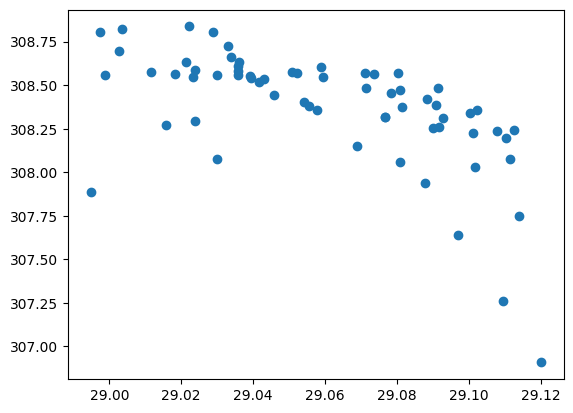

In [43]:
plt.scatter(grids_df_lst[8401]['sosstsst'].values, grids_df_lst[8401]['fco2_pre'].values)

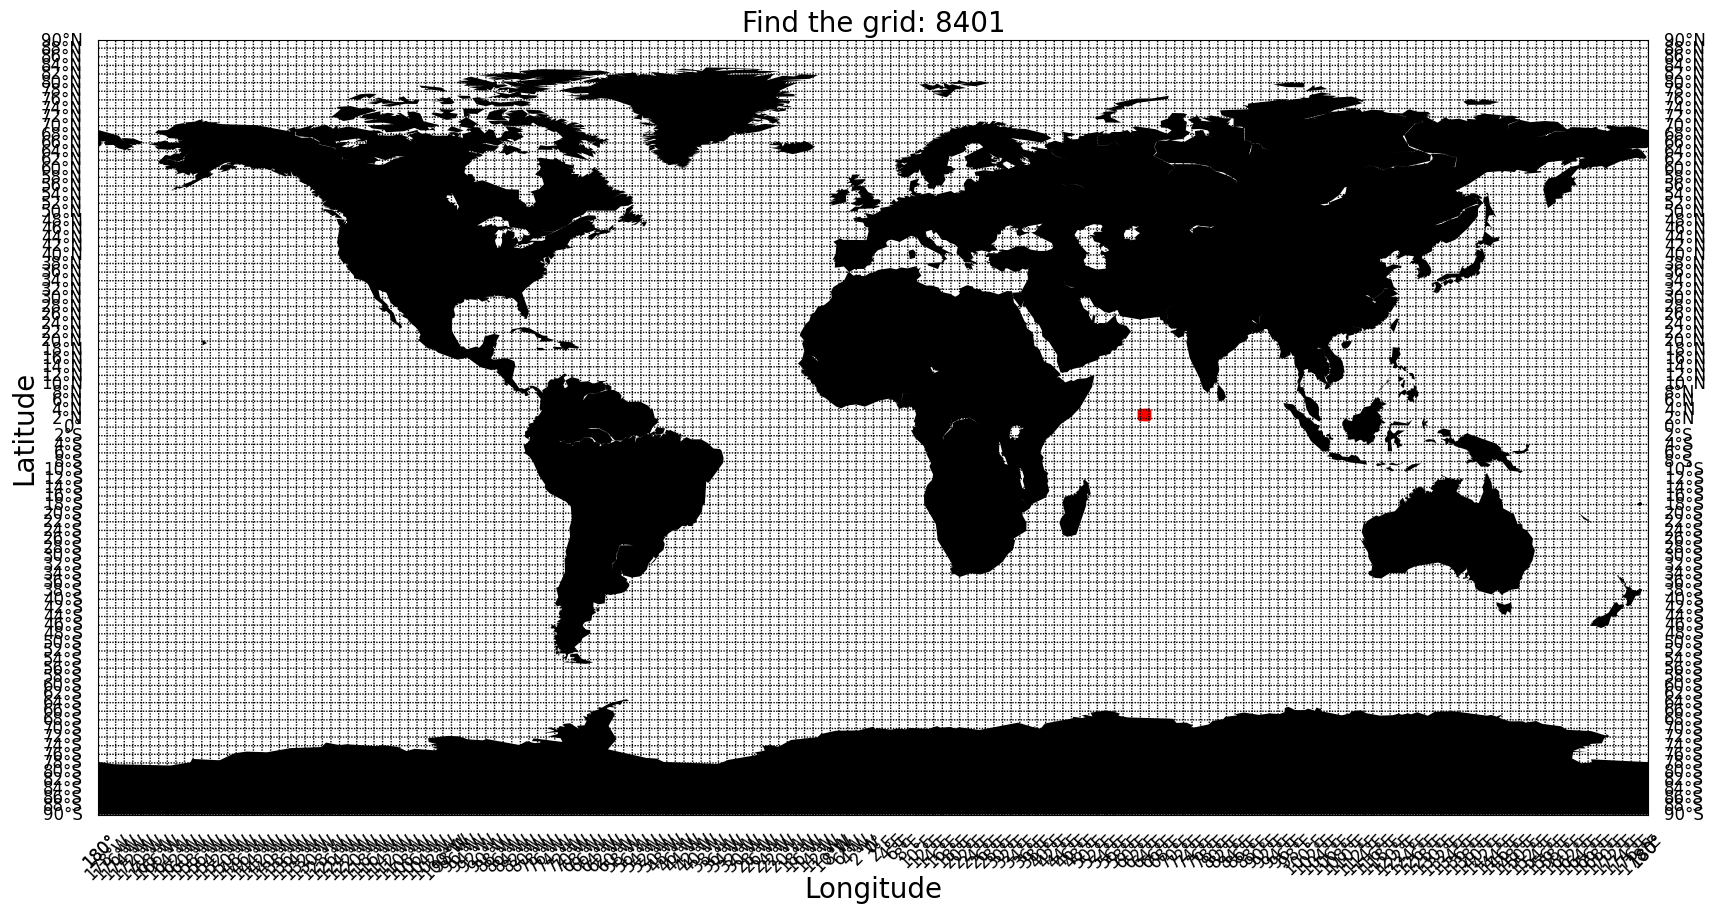

In [44]:
fig = plt.figure(figsize=(20, 16), edgecolor='w')
testmap = Basemap(projection='cyl', resolution='c',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
## Draw the coast.
# regime_map.drawcoastlines()

## Draw the land shades.
# regime_map.shadedrelief()

## Fill the land mass and lakes
testmap.fillcontinents(color='black') #color_lake='aqua'

## draw parallels and meridians.
testmap.drawparallels(np.arange(-90,91,2),labels=[1,1,0,1], fontsize=12)
testmap.drawmeridians(np.arange(-180,181,2),labels=[1,1,0,1], rotation=45, fontsize=12)

##color the sea/oceans
# regime_map.drawmapboundary(fill_color='aqua')

num = 8401
testmap.scatter(grids_df_lst[num]['nav_lon'], grids_df_lst[num]['nav_lat'], latlon=True,marker='.', 
              color='red')

plt.title(f'Find the grid: {num}',fontsize=20)
plt.xlabel('Longitude', fontsize=20, labelpad=40)
plt.ylabel('Latitude', fontsize=20, labelpad=40)

plt.show()

In [35]:
grids_df_lst[15453]

index  nav_lat  nav_lon         time_counter  sosstsst  \
870988  10549272    80.01   127.22  2009-01-16 12:00:00 -1.822009   
871108  10550712    80.04   126.25  2009-01-16 12:00:00 -1.821324   
871246  10552368    80.07   127.75  2009-01-16 12:00:00 -1.819405   
871369  10553844    80.11   126.78  2009-01-16 12:00:00 -1.824031   
871611  10556748    80.18   127.32  2009-01-16 12:00:00 -1.822155   
871741  10558308    80.21   126.34  2009-01-16 12:00:00 -1.824996   
871855  10559676    80.24   127.86  2009-01-16 12:00:00 -1.820290   
871983  10561212    80.28   126.87  2009-01-16 12:00:00 -1.824721   
872219  10564044    80.34   127.42  2009-01-16 12:00:00 -1.821552   
872341  10565508    80.38   126.42  2009-01-16 12:00:00 -1.825722   
872467  10567020    80.41   127.97  2009-01-16 12:00:00 -1.818632   
872590  10568496    80.45   126.97  2009-01-16 12:00:00 -1.823890   
872845  10571556    80.51   127.53  2009-01-16 12:00:00 -1.821894   
872960  10572936    80.55   126.52  2009-01-16 12:00:00 -1.825206   
873218  10576032    80.61   127.07  2009-01-16 12:00:00 -1.821081   
873317  10577220    80.64   126.05  2009-01-16 12:00:00 -1.825263   
873446  10578768    80.68   127.64  2009-01-16 12:00:00 -1.816837   
873584  10580424    80.71   126.61  2009-01-16 12:00:00 -1.820397   
873812  10583160    80.78   127.18  2009-01-16 12:00:00 -1.815867   
873912  10584360    80.81   126.14  2009-01-16 12:00:00 -1.817017   
874036  10585848    80.85   127.75  2009-01-16 12:00:00 -1.810467   
874156  10587288    80.88   126.71  2009-01-16 12:00:00 -1.812622   
874400  10590216    80.95   127.28  2009-01-16 12:00:00 -1.807368   
874493  10591332    80.98   126.23  2009-01-16 12:00:00 -1.808538   
874608  10592712    81.02   127.87  2009-01-16 12:00:00 -1.804852   
874731  10594188    81.05   126.81  2009-01-16 12:00:00 -1.806203   
874962  10596960    81.12   127.39  2009-01-16 12:00:00 -1.802762   
875066  10598208    81.15   126.32  2009-01-16 12:00:00 -1.799729   
875186  10599648    81.19   127.99  2009-01-16 12:00:00 -1.798854   
875311  10601148    81.22   126.91  2009-01-16 12:00:00 -1.798464   
875540  10603896    81.29   127.51  2009-01-16 12:00:00 -1.796666   
875644  10605144    81.32   126.41  2009-01-16 12:00:00 -1.793760   
875874  10607904    81.39   127.02  2009-01-16 12:00:00 -1.789592   
876103  10610652    81.45   127.63  2009-01-16 12:00:00 -1.788205   
876211  10611948    81.48   126.51  2009-01-16 12:00:00 -1.789278   
876446  10614768    81.55   127.13  2009-01-16 12:00:00 -1.786393   
876529  10615764    81.58   126.00  2009-01-16 12:00:00 -1.797400   
876684  10617624    81.62   127.75  2009-01-16 12:00:00 -1.784425   
876779  10618764    81.65   126.62  2009-01-16 12:00:00 -1.791511   
877012  10621560    81.72   127.24  2009-01-16 12:00:00 -1.787728   
877107  10622700    81.75   126.10  2009-01-16 12:00:00 -1.804818   
877228  10624152    81.79   127.88  2009-01-16 12:00:00 -1.783219   
877328  10625352    81.82   126.73  2009-01-16 12:00:00 -1.799303   
877546  10627968    81.89   127.36  2009-01-16 12:00:00 -1.793606   
877645  10629156    81.92   126.20  2009-01-16 12:00:00 -1.812432   
877880  10631976    81.98   126.84  2009-01-16 12:00:00 -1.807157   

               DICP          DIC          ALK    fco2_pre        fco2  \
870988  2050.102051  2100.155273  2214.222412  243.160095  344.687317   
871108  2061.803711  2112.199707  2228.399170  242.569717  343.481903   
871246  2045.718750  2095.582520  2208.833496  243.511383  345.197083   
871369  2057.674072  2107.889648  2223.272705  242.975052  344.070496   
871611  2053.049561  2103.064941  2217.569092  243.375656  344.652557   
871741  2064.206543  2114.558838  2231.085205  242.785751  343.494904   
871855  2046.657471  2096.441406  2209.780029  243.776779  345.327942   
871983  2059.140137  2109.275879  2224.819336  243.247772  344.173950   
872219  2052.599854  2102.485840  2216.820068  243.710037  344.911224   
872341  2063.929688  2114.151367  223

In [45]:
X = grids_df_lst[14914][['sosstsst', 'DICP', 'ALK']].values
y = grids_df_lst[14914]['fco2_pre'].values
reg = LinearRegression().fit(X, y)
reg.coef_

array([218.95515  ,   2.1606803,  -1.7545825], dtype=float32)

In [46]:
def scale_values(data_arr, min_val = -1, max_val = 1):
    scaler = MinMaxScaler(feature_range=(min_val,max_val))
    scaler.fit(data_arr)
    return scaler.transform(data_arr)

In [47]:
# norm_hc_df = hc_df[['slope_sst', 'slope_dic', 'slope_alk']].dropna()
# norm_hc_df = norm_hc_df.apply(lambda x:(x-min(x))/(max(x)-min(x)), axis = 0)
if is_natural:
    norm_hc_df = hc_df[['slope_sst', 'slope_dicp', 'slope_alk']].dropna()
else:
    norm_hc_df = hc_df[['slope_sst', 'slope_dic', 'slope_alk']].dropna()

In [48]:
    
norm_hc_df['slope_sst_std'] = (norm_hc_df['slope_sst']-norm_hc_df['slope_sst'].mean())/norm_hc_df['slope_sst'].std()
if is_natural:
    norm_hc_df['slope_dicp_std'] = (norm_hc_df['slope_dicp']-norm_hc_df['slope_dicp'].mean())/norm_hc_df['slope_dicp'].std()
else:
    norm_hc_df['slope_dic_std'] = (norm_hc_df['slope_dic']-norm_hc_df['slope_dic'].mean())/norm_hc_df['slope_dic'].std()

norm_hc_df['slope_alk_std'] = (norm_hc_df['slope_alk']-norm_hc_df['slope_alk'].mean())/norm_hc_df['slope_alk'].std()

norm_hc_df

slope_sst  slope_dicp  slope_alk  slope_sst_std  slope_dicp_std  \
1080   15.872219    1.609918  -1.320010       0.329365        0.451075   
1081   16.873524    1.424326  -1.172394       0.375138       -0.008191   
1082   14.775926    1.349677  -1.111831       0.279250       -0.192918   
1083   15.434134    1.424183  -1.179647       0.309339       -0.008544   
1084   15.350206    1.634385  -1.366500       0.305502        0.511621   
...          ...         ...        ...            ...             ...   
16190  18.304089    1.794969  -1.630716       0.440534        0.909004   
16192  18.634504    1.822937  -1.656574       0.455638        0.978213   
16195  12.616237    1.870231  -1.695890       0.180523        1.095246   
16196  44.138763    1.796652  -1.632129       1.621521        0.913167   
16197  10.361500    1.945724  -1.762507       0.077452        1.282062   

       slope_alk_std  
1080       -0.563255  
1081       -0.227442  
1082       -0.089666  
1083       -0.243943  
1084       -0.669015  
...              ...  
16190      -1.270082  
16192      -1.328907  
16195      -1.418347  
16196      -1.273296  
16197      -1.569895  

[10722 rows x 6 columns]

In [49]:
# norm_hc_df.corr()

In [50]:
norm_hc_df

slope_sst  slope_dicp  slope_alk  slope_sst_std  slope_dicp_std  \
1080   15.872219    1.609918  -1.320010       0.329365        0.451075   
1081   16.873524    1.424326  -1.172394       0.375138       -0.008191   
1082   14.775926    1.349677  -1.111831       0.279250       -0.192918   
1083   15.434134    1.424183  -1.179647       0.309339       -0.008544   
1084   15.350206    1.634385  -1.366500       0.305502        0.511621   
...          ...         ...        ...            ...             ...   
16190  18.304089    1.794969  -1.630716       0.440534        0.909004   
16192  18.634504    1.822937  -1.656574       0.455638        0.978213   
16195  12.616237    1.870231  -1.695890       0.180523        1.095246   
16196  44.138763    1.796652  -1.632129       1.621521        0.913167   
16197  10.361500    1.945724  -1.762507       0.077452        1.282062   

       slope_alk_std  
1080       -0.563255  
1081       -0.227442  
1082       -0.089666  
1083       -0.243943  
1084       -0.669015  
...              ...  
16190      -1.270082  
16192      -1.328907  
16195      -1.418347  
16196      -1.273296  
16197      -1.569895  

[10722 rows x 6 columns]

In [81]:
if is_natural:
    X = norm_hc_df[['slope_sst_std', 'slope_dicp_std', 'slope_alk_std']].values
else:
    X = norm_hc_df[['slope_sst_std', 'slope_dic_std', 'slope_alk_std']].values
    
# X = norm_hc_df.values
Z = hierarchy.linkage(X, method='ward')
Z

array([[ 3519.        ,  8047.        ,     0.00026912,     2.        ],
       [ 7961.        ,  7962.        ,     0.00049287,     2.        ],
       [ 8078.        ,  8194.        ,     0.00063547,     2.        ],
       ...,
       [21426.        , 21437.        ,    61.49806174,  3601.        ],
       [21435.        , 21440.        ,   116.07637821, 10141.        ],
       [21439.        , 21441.        ,   155.49535339, 10722.        ]])

In [82]:
Z.shape

(10721, 4)

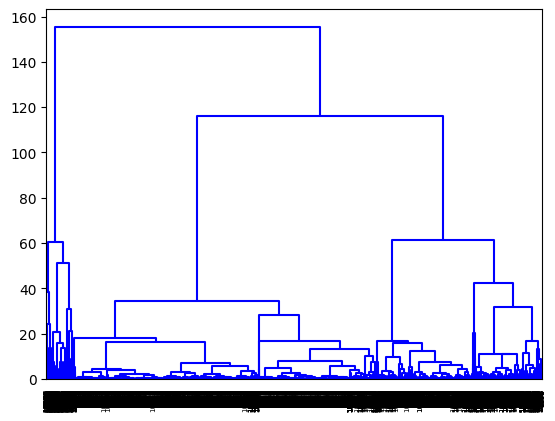

In [83]:
# hierarchy.fcluster(Z, t=100, criterion='distance')
hierarchy.dendrogram(Z, color_threshold=0)
plt.show()

In [84]:
tot_children = len(norm_hc_df)
tot_children

10722

## Automtic Cut Function

In [85]:
def get_feat_arr(dendro_dict_lst, index_, arr):
    feat_stack = np.array([])
    for item in dendro_dict_lst:
            if item['id'] == index_:
                feat_stack = item['feat_stack']
                break
    if feat_stack.size == 0:
        feat_stack = [arr[index_]]
    return feat_stack

In [86]:
def get_grid_index_list(dendro_dict_lst, index_, df):
    _l_ = []
    for item in dendro_dict_lst:
            if item['id'] == index_:
                _l_ = item['grid_index']
                break
    if len(_l_) == 0:
        _l_ = [df.index[index_]]
    return _l_

In [87]:
# https://stackoverflow.com/questions/73103010/matching-up-the-output-of-scipy-linkage-and-dendrogram

def append_index(n, i, cluster_id_list):
    # refer to the recursive progress in
    # https://github.com/scipy/scipy/blob/4cf21e753cf937d1c6c2d2a0e372fbc1dbbeea81/scipy/cluster/hierarchy.py#L3549

    # i is the idx of cluster(counting in all 2 * n - 1 clusters)
    # so i-n is the idx in the "Z"
    if i < n:
        return
    aa = int(Z[i - n, 0])
    ab = int(Z[i - n, 1])

    append_index(n, aa, cluster_id_list)
    append_index(n, ab, cluster_id_list)

    cluster_id_list.append(i-n)
    # Imitate the progress in hierarchy.dendrogram
    # so how `i-n` is appended , is the same as how the element in 'icoord'&'dcoord' be.
    return

def get_linkid_clusterid_relation(Z):
    Zs = Z.shape
    n = Zs[0] + 1
    i = 2 * n - 2
    cluster_id_list = []
    append_index(n, i, cluster_id_list)
    # cluster_id_list[i] is the cluster idx(in Z) that the R['icoord'][i]/R['dcoord'][i] corresponds to

    dict_linkid_2_clusterid = {linkid: clusterid for linkid, clusterid in enumerate(cluster_id_list)}
    dict_clusterid_2_linkid = {clusterid: linkid for linkid, clusterid in enumerate(cluster_id_list)}
    return dict_linkid_2_clusterid, dict_clusterid_2_linkid

dict_linkid_2_clusterid, dict_clusterid_2_linkid = get_linkid_clusterid_relation(Z)

## Build Dendro dict

In [88]:
# norm_hc_df.index[6538]

In [89]:
%%time
clust_num = tot_children
print(f'Start Cluster number = {clust_num}')
dendro_dict_lst = []
# index_count = len(Z) - 1
index_count = 0
for row in Z:
    dendro_dict ={}
    dendro_dict['id'] = clust_num    
    dendro_dict['info'] = row
    dendro_dict['feat_stack'] = np.array([])
    dendro_dict['variance'] = np.array([])
    dendro_dict['Z_index'] = index_count
    dendro_dict['grid_index'] = []

    dendro_dict_lst.append(dendro_dict)
    clust_num = clust_num + 1    
    index_count = index_count + 1

print(f'End Cluster number = {clust_num}')

Start Cluster number = 10722
End Cluster number = 21443
CPU times: user 42.5 ms, sys: 2.71 ms, total: 45.2 ms
Wall time: 44.2 ms


In [90]:
%%time

count = 0
for dendro in dendro_dict_lst:
    arr = dendro['info']
    first_index = int(arr[0])
    second_index = int(arr[1])
    child_num = arr[3]
    if child_num == 2:
        dendro['feat_stack'] =np.append([X[first_index]],[X[second_index]],axis = 0)
        dendro['variance'] = np.var(dendro['feat_stack'])
        _l_ = [norm_hc_df.index[first_index]]
        _l_.append(norm_hc_df.index[second_index])
        dendro['grid_index'] = _l_

        count = count + 1

print(count)

4036
CPU times: user 124 ms, sys: 3.29 ms, total: 127 ms
Wall time: 125 ms


In [91]:
%%time

count = 0

for dendro in dendro_dict_lst:
    arr_ = dendro['info']
    first_index = int(arr_[0])
    second_index = int(arr_[1])
    child_num = arr_[3]
    if child_num > 2:
#         print(arr[3])
#         print(first_index)
#         print(second_index)
        left_index = get_feat_arr(dendro_dict_lst = dendro_dict_lst, 
                         index_ = first_index, 
                         arr = X)
        
        right_index = get_feat_arr(dendro_dict_lst = dendro_dict_lst, 
                         index_ = second_index, 
                         arr = X)  
        dendro['feat_stack'] =np.append(left_index,right_index,axis = 0)
        dendro['variance'] = np.var(dendro['feat_stack'])
        
        left_grid_index = get_grid_index_list(dendro_dict_lst = dendro_dict_lst,
                                              index_ = first_index, df = norm_hc_df)
        right_grid_index = get_grid_index_list(dendro_dict_lst = dendro_dict_lst,
                                               index_ = second_index, df = norm_hc_df)
        # appending lists to one list
        dendro['grid_index'] = [*left_grid_index, *right_grid_index]


        count = count + 1    
#         break
# print(dendro)
print(count)    

6685
CPU times: user 7.78 s, sys: 31.9 ms, total: 7.81 s
Wall time: 7.82 s


In [92]:
# dendro_dict_lst[5000]

## Medoid calculation

In [93]:
def run_through_dendrogram(delta_var, delta_dist, dendro_dict_lst):

    process_left = []
    process_right = []

    cluster_list = []
    z_index_list = []

    # get the top most element from the dendrogram and set is as "Start".
    start = dendro_dict_lst[-1]

    head = start['id']
    current_left = start['info'][0]
    current_right = start['info'][1]
    current_height = start['info'][2]
    current_variance = start['variance']
    current_z_index = start['Z_index']

    while(head):
        left_height = None
        left_variance = None
        left_z_index = None
        right_height = None
        right_variance = None
        right_z_index = None

        # left_child_num = 1
        # right_child_num = 1

        for item in dendro_dict_lst:
            if item['id'] == current_left:
                left_height = item['info'][2]
                left_variance = item['variance']
                left_z_index = item['Z_index']

        for item in dendro_dict_lst:
            if item['id'] == current_right:
                right_height = item['info'][2]
                right_variance = item['variance']
                right_z_index = item['Z_index']

        if right_height:
            change_height_right = abs(current_height - right_height)
            change_variance_right = abs(current_variance - right_variance)
            if ((change_height_right > delta_dist) and (change_variance_right > delta_var)):
                process_right.append(current_right)
            else:
                cluster_list.append(current_right)
                z_index_list.append(right_z_index)

        else:
            cluster_list.append(current_right)
    #         z_index_list.append(current_right)

        if left_height:
            change_height_left = abs(current_height - left_height)
            change_variance_left = abs(current_variance - left_variance)

            if ((change_height_left > delta_dist) and (change_variance_left > delta_var)): 
                #change_variance_left = np.inf
                    process_left.append(current_left)
            else:
                    # splitting the current head
                    cluster_list.append(current_left)
                    z_index_list.append(left_z_index)
        else:
            cluster_list.append(current_left)
    #         z_index_list.append(current_left)

        ## Reassign head
        if process_left:
            head = process_left.pop()
        elif process_right:
            head = process_right.pop()
        else:
            head = None

        ## Reassign
        if head:
            for item in dendro_dict_lst:
                if item['id'] == head:
                    current_left = item['info'][0]
                    current_right = item['info'][1]
                    current_height = item['info'][2]
                    current_variance = item['variance']
                    current_z_index = item['Z_index']
                    
    return cluster_list

In [94]:
def get_all_clusters(cluster_list):
    heights_lst = []
    grid_index_list = []
    for c in cluster_list:
        found = False
        for item in dendro_dict_lst:
                if item['id'] == c:
    #                 print(item['id'])
                    found = True
                    ht = item['info'][2]
                    heights_lst.append(ht)
                    grid_index_list.append(item['grid_index'])
        if not found:
#             print(f"!!! Singleton cluster at {c}")
            heights_lst.append(0.0)
            grid_index_list.append([norm_hc_df.index[int(c)]])
    
    ## Extract clusters
    cluster_lbl = 1
    l__indices = []
    l__lbls = []
    for grid_list in grid_index_list:
        if type(grid_list) != list:
            l__indices.append(grid_list)
            l__lbls.append(cluster_lbl)
        else:
            for i in grid_list:
                # print(f'going wrong: ', i)
                l__indices.append(i)
                l__lbls.append(cluster_lbl)
        cluster_lbl = cluster_lbl + 1

    _df_ = pd.DataFrame(l__lbls, index =l__indices,columns =['cluster'])
    cluster_df = pd.merge(norm_hc_df, _df_, left_index=True, right_index=True)
    return cluster_df

In [95]:
def get_bic_aic_score(cluster_df):
    #size of data set -> N datapoints with d no. of features
    N, d = X.shape
    #unique labels
    labels_unique = cluster_df['cluster'].unique()

    loglikelihood = 0  
    for lbl in labels_unique:
        df_lbl = cluster_df.loc[cluster_df['cluster'] == lbl]
        loglikelihood =loglikelihood + np.log(len(df_lbl)/N)

    #BIC
    BIC = -2 * loglikelihood + d * np.log(N)
    AIC = -2 * loglikelihood + 2*d
    return BIC, AIC, labels_unique

### Set distance variance list

In [96]:
del_variance_list = np.arange(0.1, 1.0, 0.1).tolist()
del_distance_list = np.arange(20, 40, 1).tolist()

In [97]:
%%time

plot_del_var = []
plot_del_dist = []
bic_scores = []
aic_scores = []
tot_clusters = []

for del_dist in del_distance_list:
    for del_var in del_variance_list:
#         print(del_var, del_dist)
        cluster_list = run_through_dendrogram(del_var, del_dist, dendro_dict_lst)
        cluster_df = get_all_clusters(cluster_list)
        BIC, AIC, labels_unique = get_bic_aic_score(cluster_df)
        
        # Add to the lists
        plot_del_var.append(del_var)
        plot_del_dist.append(del_dist)
        bic_scores.append(BIC)
        aic_scores.append(AIC)
        tot_clusters.append(len(labels_unique))
        
#         if ((del_var == 0.5) and (del_dist == 15.0)):
#             print('hello', len(labels_unique))

CPU times: user 3.09 s, sys: 8.7 ms, total: 3.1 s
Wall time: 3.1 s


In [98]:
df = pd.DataFrame(list(zip(plot_del_dist, plot_del_var, bic_scores, aic_scores, tot_clusters )),
               columns =['Del_Dist', 'Del_Var', 'BIC', 'AIC', 'Clusters'])
df

Del_Dist  Del_Var        BIC        AIC  Clusters
0          20      0.1  95.536660  73.696501         9
1          20      0.2  91.670211  69.830052         8
2          20      0.3  91.670211  69.830052         8
3          20      0.4  76.199739  54.359580         6
4          20      0.5  76.199739  54.359580         6
..        ...      ...        ...        ...       ...
175        39      0.5  46.420587  24.580428         4
176        39      0.6  43.361116  21.520957         3
177        39      0.7  43.361116  21.520957         3
178        39      0.8  43.361116  21.520957         3
179        39      0.9  43.361116  21.520957         3

[180 rows x 5 columns]

### BIC Plots

In [68]:
df_ = df.groupby(['Del_Dist'], as_index=False)['BIC', 'Clusters'].median()
df_

Del_Dist          BIC  Clusters
0          5  2521.525447     171.0
1          6  2310.400829     159.0
2          7  2066.787028     144.0
3          8  1915.388845     135.0
4          9  1878.888943     133.0
5         10  1755.218805     125.0
6         11  1666.424412     120.0
7         12  1611.060121     116.0
8         13  1523.029575     111.0
9         14  1449.766137     106.0
10        15  1378.436288     102.0
11        16  1294.247096      96.0
12        17  1279.640354      95.0
13        18  1198.450230      89.0
14        19  1167.679146      86.0

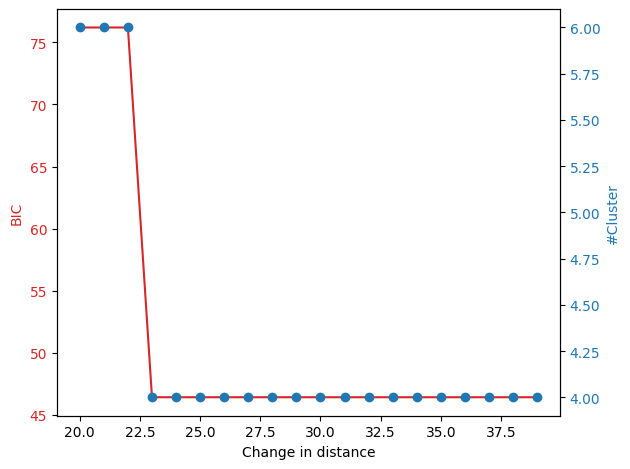

In [58]:
t = df_['Del_Dist'].values
data1 = df_['BIC'].values
data2 = df_['Clusters'].values

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Change in distance')
ax1.set_ylabel('BIC', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('#Cluster', color=color)  # we already handled the x-label with ax1
ax2.scatter(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

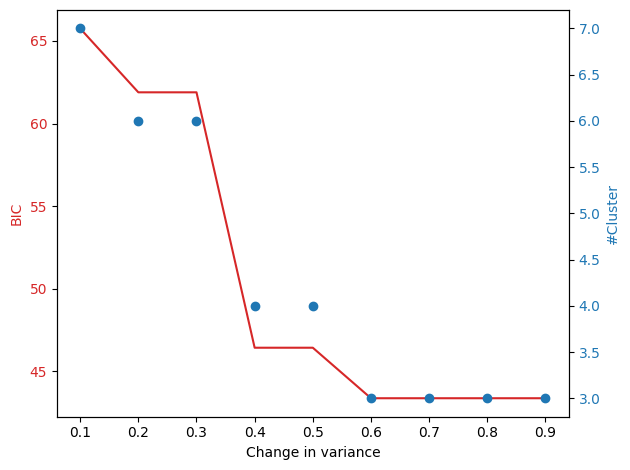

In [60]:
df_ = df.groupby(['Del_Var'], as_index=False)['BIC', 'Clusters'].median()

t = df_['Del_Var'].values
data1 = df_['BIC'].values
data2 = df_['Clusters'].values

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Change in variance')
ax1.set_ylabel('BIC', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('#Cluster', color=color)  # we already handled the x-label with ax1
ax2.scatter(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [61]:
# bic_cluster_num_fig = px.scatter(df, x="Del_Dist", y="Del_Var",size='Clusters',
#                                 color= 'BIC', hover_data=['Clusters', 'BIC'],)
# bic_cluster_num_fig.update_layout(title = 'BIC Score and total no. of clusters generated wrt change in variance and distance',)
    

In [99]:
df_limited = df.loc[(df['Clusters']> 6) & (df['Clusters']<=12)]
df_limited

Del_Dist  Del_Var        BIC        AIC  Clusters
0          20      0.1  95.536660  73.696501         9
1          20      0.2  91.670211  69.830052         8
2          20      0.3  91.670211  69.830052         8
9          21      0.1  95.536660  73.696501         9
10         21      0.2  91.670211  69.830052         8
11         21      0.3  91.670211  69.830052         8
18         22      0.1  95.536660  73.696501         9
19         22      0.2  91.670211  69.830052         8
20         22      0.3  91.670211  69.830052         8
27         23      0.1  65.757508  43.917350         7
36         24      0.1  65.757508  43.917350         7
45         25      0.1  65.757508  43.917350         7
54         26      0.1  65.757508  43.917350         7
63         27      0.1  65.757508  43.917350         7
72         28      0.1  65.757508  43.917350         7
81         29      0.1  65.757508  43.917350         7
90         30      0.1  65.757508  43.917350         7
99         31      0.1  65.757508  43.917350         7
108        32      0.1  65.757508  43.917350         7
117        33      0.1  65.757508  43.917350         7
126        34      0.1  65.757508  43.917350         7
135        35      0.1  65.757508  43.917350         7
144        36      0.1  65.757508  43.917350         7
153        37      0.1  65.757508  43.917350         7
162        38      0.1  65.757508  43.917350         7
171        39      0.1  65.757508  43.917350         7

In [100]:
if len(df_limited) == 0:
    X_medoid = df[['Del_Dist','Del_Var']].values
else:
    X_medoid = df_limited[['Del_Dist','Del_Var']].values
kmedoids = KMedoids(n_clusters=1, random_state=0).fit(X_medoid)

In [101]:
medoids = kmedoids.cluster_centers_
print(medoids)

[[27.   0.1]]


## Distance - Variance Selection

In [98]:
%%time

# delta_dist = medoids[0][0]
# delta_var = medoids[0][1]

delta_dist = 5.0
delta_var = 0.01

process_left = []
process_right = []

cluster_list = []
z_index_list = []

# get the top most element from the dendrogram and set is as "Start".
start = dendro_dict_lst[-1]

head = start['id']
current_left = start['info'][0]
current_right = start['info'][1]
current_height = start['info'][2]
current_variance = start['variance']
current_z_index = start['Z_index']

test_count = 0

while(head):
    print()
    print('New head.')
    left_height = None
    left_variance = None
    left_z_index = None
    right_height = None
    right_variance = None
    right_z_index = None
    
    # left_child_num = 1
    # right_child_num = 1

    for item in dendro_dict_lst:
        if item['id'] == current_left:
            left_height = item['info'][2]
            left_variance = item['variance']
            left_z_index = item['Z_index']

    for item in dendro_dict_lst:
        if item['id'] == current_right:
            right_height = item['info'][2]
            right_variance = item['variance']
            right_z_index = item['Z_index']

    if right_height:
        change_height_right = abs(current_height - right_height)
        change_variance_right = abs(current_variance - right_variance)
        
        print("Change in height:", change_height_right)
        print("Change in variance:", change_variance_right)

        if ((change_height_right > delta_dist) and (change_variance_right > delta_var)):
            print('went down.')
            process_right.append(current_right)
        else:
            cluster_list.append(current_right)
            z_index_list.append(right_z_index)
            print('stopped.')
            

    else:
        cluster_list.append(current_right)
        z_index_list.append(current_right)
        print('stopped.')
        
        

    if left_height:
        change_height_left = abs(current_height - left_height)
        change_variance_left = abs(current_variance - left_variance)
        
        print("Change in height:", change_height_left)
        print("Change in variance:", change_variance_left)

        if ((change_height_left > delta_dist) and (change_variance_left > delta_var)): 
            #change_variance_left = np.inf
            print('went down.')
            process_left.append(current_left)
        else:
            
            # splitting the current head
            cluster_list.append(current_left)
            z_index_list.append(left_z_index)
            print('stopped.')
            
    else:
        cluster_list.append(current_left)
        z_index_list.append(current_left)
        print('stopped.')
        
    
    ## Reassign head
    if process_left:
        head = process_left.pop()
    elif process_right:
        head = process_right.pop()
    else:
        head = None
    
    ## Reassign
    if head:
        for item in dendro_dict_lst:
            if item['id'] == head:
                current_left = item['info'][0]
                current_right = item['info'][1]
                current_height = item['info'][2]
                current_variance = item['variance']
                current_z_index = item['Z_index']


        
#     test_count = test_count + 1
#     if test_count == 100:
#         break
cluster_list


New head.
Change in height: 12.779574762498292
Change in variance: 0.011816009458708435
went down.
Change in height: 36.09260009384119
Change in variance: 0.032899827346507884
went down.

New head.
Change in height: 5.701000500482199
Change in variance: 0.04765684945647322
went down.
Change in height: 9.23523425114214
Change in variance: 0.05968638926715408
went down.

New head.
Change in height: 1.5296321305939367
Change in variance: 0.022130717813501483
stopped.
Change in height: 1.9896143277814051
Change in variance: 0.02757087754357626
stopped.

New head.
Change in height: 2.559391069555705
Change in variance: 0.02520828516248058
stopped.
Change in height: 3.5972503146800836
Change in variance: 0.027332403367001865
stopped.

New head.
Change in height: 11.511322350816695
Change in variance: 0.023351716355545296
went down.
Change in height: 28.383341755167052
Change in variance: 0.067875532075541
went down.

New head.
Change in height: 3.4352444970862037
Change in variance: 0.04198

[22845.0,
 22814.0,
 22880.0,
 22873.0,
 22877.0,
 22866.0,
 22883.0,
 22829.0,
 22762.0,
 22889.0,
 22878.0,
 22863.0]

In [99]:
heights_lst = []
grid_index_list = []
for c in cluster_list:
    found = False
    for item in dendro_dict_lst:
            if item['id'] == c:
#                 print(item['id'])
                found = True
                ht = item['info'][2]
                heights_lst.append(ht)
                grid_index_list.append(item['grid_index'])
    if not found:
        print("singleton found")
        print(c)
        heights_lst.append(0.0)
        grid_index_list.append([norm_hc_df.index[int(c)]])
len(grid_index_list)

12

In [100]:
z_index_list

[11397,
 11366,
 11432,
 11425,
 11429,
 11418,
 11435,
 11381,
 11314,
 11441,
 11430,
 11415]

## Plot Dendrogram

In [101]:
# plt.figure(figsize=(10, 8)).set_facecolor('white')
# plt.title(f"Dendrogram - Clustering Drivers of CO2 in jan 2009",fontsize=20)
# dend = hierarchy.dendrogram(Z, color_threshold=0)

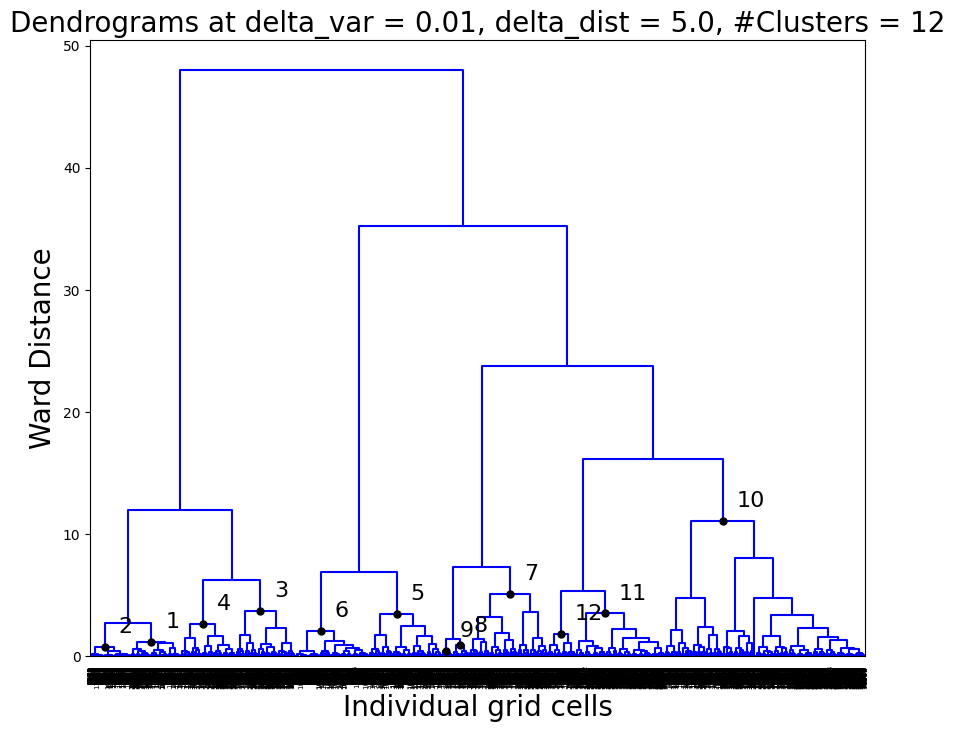

CPU times: user 1min 10s, sys: 2.72 s, total: 1min 12s
Wall time: 1min 12s


In [102]:
%%time
plt.figure(figsize=(10, 8)).set_facecolor('white')
plt.title(f"Dendrograms at delta_var = {round(delta_var,2)}, delta_dist = {round(delta_dist,2)}, #Clusters = {len(heights_lst)}",
          fontsize=20)

dend = hierarchy.dendrogram(Z, color_threshold=0)
LBL_COUNT = 1

for z, h in zip(z_index_list, heights_lst):
    link_id = dict_clusterid_2_linkid[z]
    i = dend['icoord'][link_id]
    x = 0.5 * sum(i[1:3])
    y = h
    plt.plot(x, y, 'ro',c='black', markersize=5) #label = f'height = {y}'
    label = f"{LBL_COUNT}"
    plt.annotate(label, # this is the text
                (x,y), # these are the coordinates to position the text
                textcoords="offset points", # how to position the text
                xytext=(10,10), # distance from text to points (x,y)
                ha='left', # horizontal alignment can be left, right or center
                color='black',
                fontsize=16)
#     plt.axhline(y=h, color='black', linestyle='--', linewidth = 0.5, label = f'{LBL_COUNT} -> {h}')  
    
    LBL_COUNT = LBL_COUNT + 1
    
# # for height in heights_lst:
# #     plt.axhline(y=height, color='black', linestyle='--', label = f'{height}')  
# # plt.legend()

plt.xlabel("Individual grid cells", fontsize=20)
plt.ylabel("Ward Distance", fontsize =20)
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 18 
mpl.rcParams['ytick.labelsize'] = 18
plt.show()

## Extract Clusters

In [103]:
cluster_list

[22845.0,
 22814.0,
 22880.0,
 22873.0,
 22877.0,
 22866.0,
 22883.0,
 22829.0,
 22762.0,
 22889.0,
 22878.0,
 22863.0]

In [104]:
import colorcet as cc

num = len(grid_index_list) # num = len(cluster_list)
# Non repeating random colors
clrs = sns.color_palette(cc.glasbey, n_colors=num + 10) # clrs = sns.color_palette("hls", num)
clrs

[(0.8392156862745098, 0.0, 0.0),
 (0.5490196078431373, 0.23137254901960785, 1.0),
 (0.00392156862745098, 0.5294117647058824, 0.0),
 (0.0, 0.6745098039215687, 0.7764705882352941),
 (0.592156862745098, 1.0, 0.0),
 (1.0, 0.49411764705882355, 0.8196078431372549),
 (0.4196078431372549, 0.0, 0.30980392156862746),
 (1.0, 0.6470588235294118, 0.1843137254901961),
 (0.3411764705882353, 0.23137254901960785, 0.0),
 (0.0, 0.33725490196078434, 0.34901960784313724),
 (0.0, 0.0, 0.8666666666666667),
 (0.0, 0.9921568627450981, 0.8117647058823529),
 (0.6313725490196078, 0.4588235294117647, 0.4117647058823529),
 (0.7372549019607844, 0.7137254901960784, 1.0),
 (0.5843137254901961, 0.7098039215686275, 0.4666666666666667),
 (0.7490196078431373, 0.011764705882352941, 0.7215686274509804),
 (0.39215686274509803, 0.32941176470588235, 0.4549019607843137),
 (0.4745098039215686, 0.0, 0.0),
 (0.027450980392156862, 0.4549019607843137, 0.8470588235294118),
 (0.9921568627450981, 0.9568627450980393, 0.5647058823529412),
 (0.0, 0.29411764705882354, 0.0),
 (0.5568627450980392, 0.4745098039215686, 0.0)]

In [105]:
if is_natural:
    cluster_colors = clrs
else:
    cluster_colors = clrs[-num:]

In [106]:
cluster_lbl = 1
l__indices = []
l__lbls = []
for grid_list in grid_index_list:
    if type(grid_list) != list:
        l__indices.append(grid_list)
        l__lbls.append(cluster_lbl)
    else:
        for i in grid_list:
            # print(f'going wrong: ', i)
            l__indices.append(i)
            l__lbls.append(cluster_lbl)
    cluster_lbl = cluster_lbl + 1

In [107]:
_df_ = pd.DataFrame(l__lbls, index =l__indices,columns =['cluster'])
hc_df = pd.merge(norm_hc_df, _df_, left_index=True, right_index=True)
hc_df

slope_sst  slope_dicp  slope_alk  cluster
1080    0.079870    0.524252   0.395878       11
1081    0.098005    0.753263   0.148732        5
1082    0.172413    0.427279   0.400307       11
1083    0.198722    0.368020   0.433258       10
1084    0.253875    0.388514   0.357612       10
...          ...         ...        ...      ...
16195   0.514876    0.256556   0.228568        3
16196   0.544158    0.205014   0.250828        3
16197   0.640850    0.173927   0.185222        3
16198   0.173318    0.402332   0.424350       11
16199   0.173804    0.429350   0.396846       11

[11448 rows x 4 columns]

### Plot Grid slopes

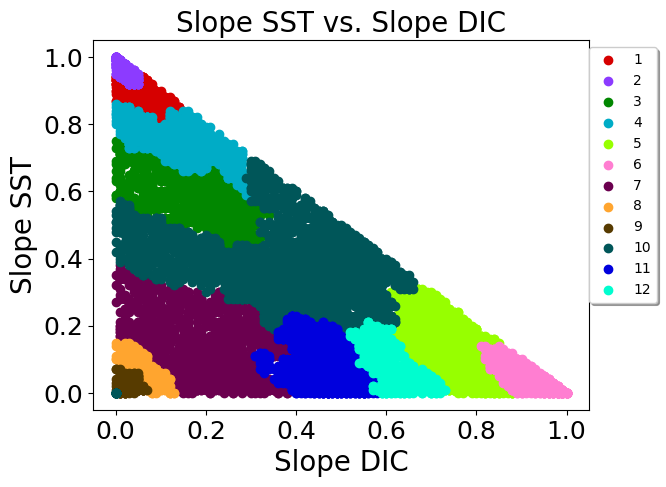

In [108]:
hc_df_rounded = hc_df.round(2)
# # df = df.loc[df['cluster'] == 3]

tot_clusters = np.sort(hc_df_rounded['cluster'].unique())
for t, c in zip(tot_clusters, clrs):
    df = hc_df_rounded.loc[hc_df_rounded['cluster'] == t]
    x = df['slope_dicp'].values
    y = df['slope_sst'].values
    plt.scatter(x, y, color=c, label = f'{t}')

plt.legend(loc='best', bbox_to_anchor=(1.15, 1),fancybox=True, shadow=True, ncol=1)
plt.title(f"Slope SST vs. Slope DIC", fontsize=20)
plt.xlabel("Slope DIC", fontsize=20)
plt.ylabel("Slope SST", fontsize=20)
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 18 
mpl.rcParams['ytick.labelsize'] = 18 
plt.show()

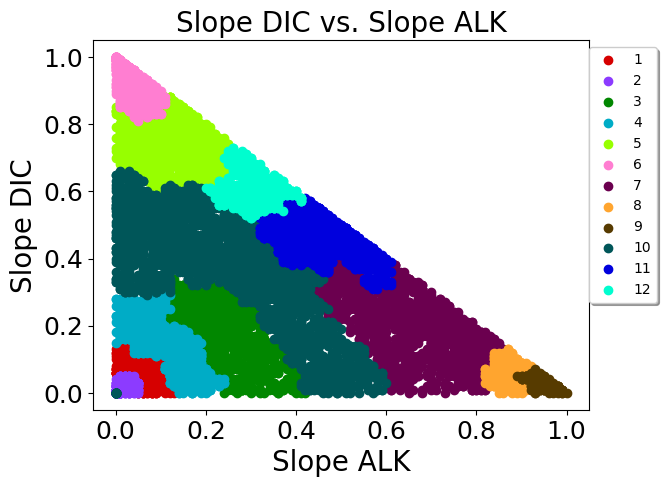

In [109]:
hc_df_rounded = hc_df.round(2)
# # df = df.loc[df['cluster'] == 3]

tot_clusters = np.sort(hc_df_rounded['cluster'].unique())
for t, c in zip(tot_clusters, clrs):
    df = hc_df_rounded.loc[hc_df_rounded['cluster'] == t]
    x = df['slope_alk'].values
    y = df['slope_dicp'].values
    plt.scatter(x, y, color=c, label = f'{t}')

plt.legend(loc='best', bbox_to_anchor=(1.15, 1),fancybox=True, shadow=True, ncol=1)
plt.title(f"Slope DIC vs. Slope ALK", fontsize=20)
plt.xlabel("Slope ALK", fontsize=20)
plt.ylabel("Slope DIC", fontsize=20)
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 18 
mpl.rcParams['ytick.labelsize'] = 18 
plt.show()

In [110]:
# import plotly.express as px

# df = hc_df.round(2)
# df = df.sort_values('cluster')
# df['cluster'] = df['cluster'].astype(str)
# df['bubble_size'] = 1.0

# if is_natural:
#     fig = px.scatter_3d(df, x='slope_alk', y='slope_dicp', z='slope_sst',
#               color='cluster', opacity=0.3)
# else:
#     ig = px.scatter_3d(df, x='slope_alk', y='slope_dic', z='slope_sst',
#               color='cluster', opacity=0.3)
# fig.show()

In [111]:
# clrs = sns.color_palette(cc.glasbey, n_colors=len(hc_df['cluster'].unique()))
# clusters = hc_df['cluster'].unique()
# for clust in clusters:
#     plot_df = hc_df.loc[hc_df['cluster'] == clust]
#     x= plot_df['slope_sst_std'].values
#     y= plot_df['slope_dic_std'].values 
#     plt.scatter(x, y, color=clrs[clust-1])
# plt.xlabel("Slope SST", fontsize=16)
# plt.ylabel("Slope DIC", fontsize=16)

### BIC score

In [112]:
labels_all = hc_df['cluster'].values #all labels
#size of data set -> N datapoints with d no. of features
N, d = X.shape
#unique labels
labels_unique = hc_df['cluster'].unique()

loglikelihood = 0  
for lbl in labels_unique:
    _df_ = hc_df.loc[hc_df['cluster'] == lbl]
    loglikelihood =loglikelihood + np.log(len(_df_)/N)

#BIC
BIC = -2 * loglikelihood + d * np.log(N)
AIC = -2 * loglikelihood + 2*d
b_score = BIC
b_score

93.63190010580091

### Save the clustering output

In [114]:
appended_data = []
for index, row in hc_df.iterrows():
    # get the corresponding grid from the list of grids
    _df_ = grids_df_lst[index]
    _df_['grid_id'] = index
    _df_['cluster'] = row['cluster']
    _df_['slope_sst'] = row['slope_sst']
#     _df_['slope_sst_std'] = row['slope_sst_std']
    if is_natural:
        _df_['slope_dicp'] = row['slope_dicp']
#         _df_['slope_dicp_std'] = row['slope_dicp_std']
    else:
        _df_['slope_dic'] = row['slope_dic']
#         _df_['slope_dic_std'] = row['slope_dic_std']
        
    _df_['slope_alk'] = row['slope_alk']
#     _df_['slope_alk_std'] = row['slope_alk_std']
#     _df_['slope_sal'] = row['slope_sal']
#     _df_['slope_sal_std'] = row['slope_sal_std']
    _df_['BIC'] = BIC
    _df_['delta_var'] = delta_var
    _df_['delta_dist'] = delta_dist
    appended_data.append(_df_)

In [115]:
appended_data = pd.concat(appended_data)
appended_data
# appended_data['slope_sst'].max()

index  nav_lat  nav_lon         time_counter  sosstsst  \
0              0   -76.95  -179.75  2009-01-16 12:00:00 -0.531698   
1             12   -76.95  -179.50  2009-01-16 12:00:00 -0.552196   
2             24   -76.95  -179.25  2009-01-16 12:00:00 -0.572038   
3             36   -76.95  -179.00  2009-01-16 12:00:00 -0.590805   
4             48   -76.95  -178.75  2009-01-16 12:00:00 -0.608288   
...          ...      ...      ...                  ...       ...   
893398  10818192    88.52   178.35  2009-01-16 12:00:00 -1.705290   
893480  10819176    88.62   179.45  2009-01-16 12:00:00 -1.705957   
893708  10821912    88.95   178.41  2009-01-16 12:00:00 -1.705892   
893910  10824336    89.37   178.52  2009-01-16 12:00:00 -1.702868   
894006  10825488    89.79   178.98  2009-01-16 12:00:00 -1.709990   

               DICP          DIC          ALK    fco2_pre        fco2  \
0       1952.550293  1985.440918  2115.781982  227.253235  286.713104   
1       1951.565796  1984.419067  2114.570312  227.031006  286.425262   
2       1950.894653  1983.728638  2113.717041  226.850754  286.213898   
3       1950.586548  1983.405396  2113.283936  226.708252  286.038757   
4       1950.596924  1983.404541  2113.148926  226.701416  286.042175   
...             ...          ...          ...         ...         ...   
893398  1934.908691  1975.978516  2053.834961  280.968994  394.178284   
893480  1932.613037  1973.599976  2051.161133  281.219788  394.490509   
893708  1930.245728  1971.238037  2049.083984  280.273346  393.134094   
893910  1927.047852  1968.078247  2046.561035  278.523651  390.623474   
894006  1923.259766  1964.268921  2043.057495  277.368378  388.920502   

                 e1t           e2t  grid_id  cluster  slope_sst  slope_dicp  \
0        6275.247070   6275.247070     1080     11.0   0.079870    0.524252   
1        6275.247070   6275.247070     1080     11.0   0.079870    0.524252   
2        6275.247070   6275.247070     1080     11.0   0.079870    0.524252   
3        6275.247070   6275.247070     1080     11.0   0.079870    0.524252   
4        6275.247070   6275.247070     1080     11.0   0.079870    0.524252   
...              ...           ...      ...      ...        ...         ...   
893398  12111.356445  11703.959961    16199     11.0   0.173804    0.429350   
893480  12109.818359  11656.090820    16199     11.0   0.173804    0.429350   
893708  12113.638672  11521.080078    16199     11.0   0.173804    0.429350   
893910  12117.741211  11333.000000    16199     11.0   0.173804    0.429350   
894006  12123.293945  11139.941406    16199     11.0   0.173804    0.429350   

        slope_alk      BIC  delta_var  delta_dist  
0        0.395878  93.6319       0.01         5.0  
1        0.395878  93.6319       0.01         5.0  
2        0.395878  93.6319       0.01         5.0  
3        0.395878  93.6319       0.01         5.0  
4        0.395878  93.6319       0.01         5.0  
...           ...      ...        ...         ...  
893398   0.396846  93.6319       0.01         5.0  
893480   0.396846  93.6319       0.01         5.0  
893708   0.396846  93.6319       0.01         5.0  
893910   0.396846  93.6319       0.01         5.0  
894006   0.396846  93.6319       0.01         5.0  

[893436 rows x 20 columns]

In [91]:
# appended_data.to_pickle(f"../Clustering_Output/adaptive_hc_clusters_{_year}_{_month}.pkl")
# print(f"Year: {_year}, Month: {_month}")
# if is_natural:
#     appended_data.to_pickle(f"../Clustering_Output/DEMO_Natural_adaptive_hc_clusters_{_year}_{_month}_3feat_025.pkl")
# else:
#     appended_data.to_pickle(f"../Clustering_Output/DEMO_Anthropogenic_adaptive_hc_clusters_{_year}_{_month}_3feat_025.pkl")

Year: 2009, Month: jan


### Map

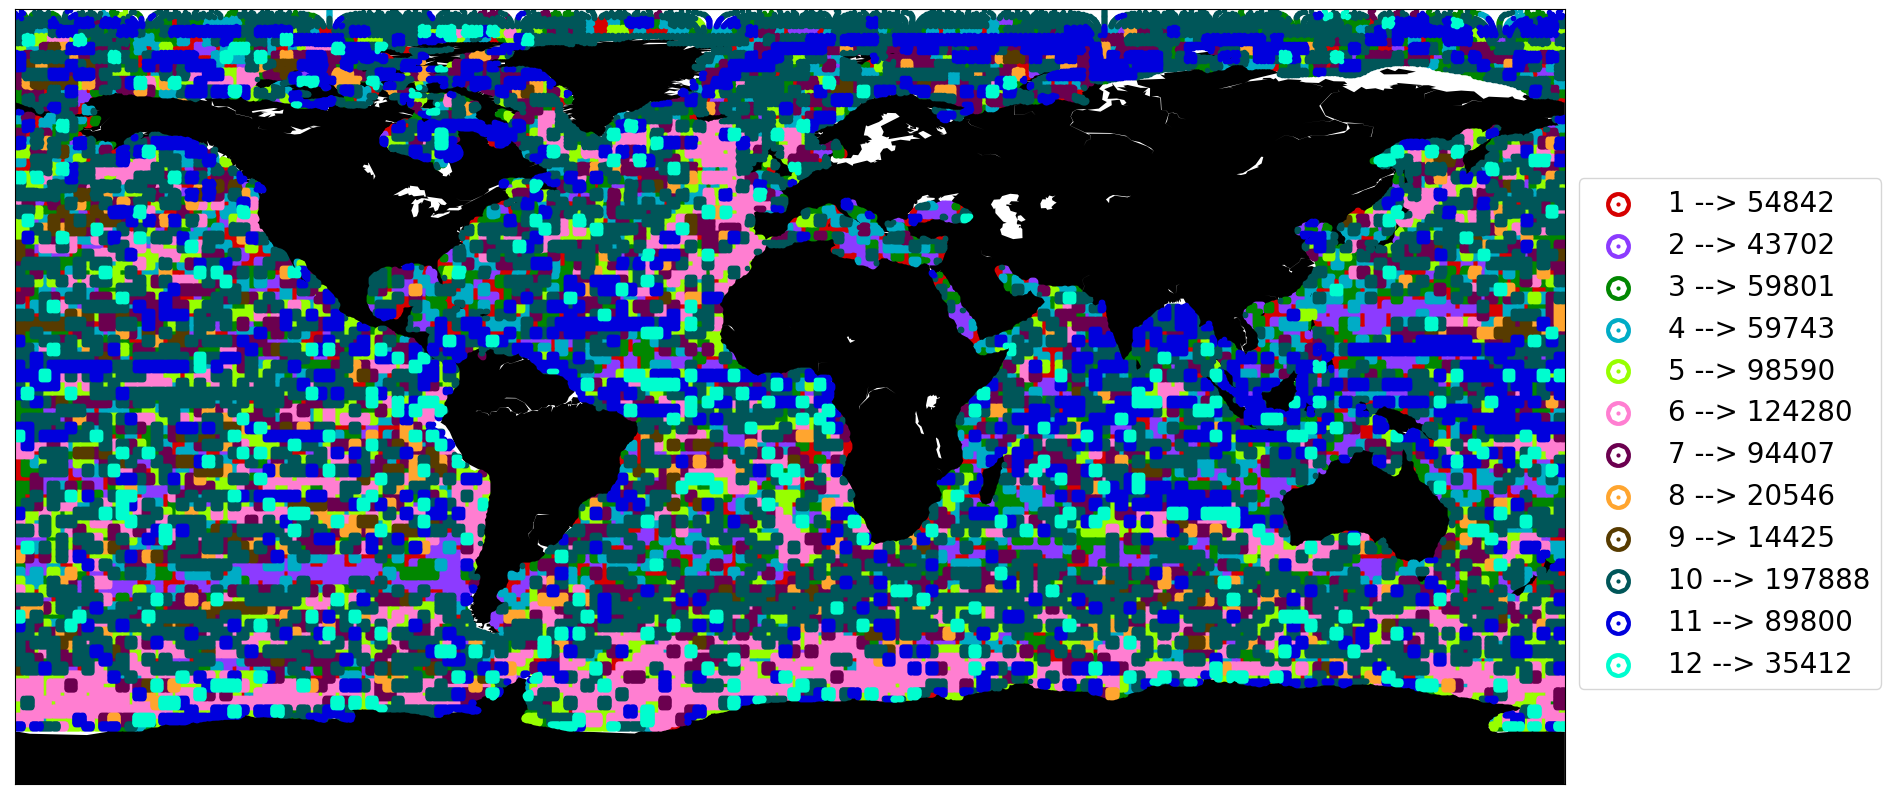

In [116]:
fig = plt.figure(figsize=(20, 16), edgecolor='w')
regime_map = Basemap(projection='cyl', resolution='c',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
## Draw the coast.
# regime_map.drawcoastlines()

## Draw the land shades.
# regime_map.shadedrelief()

## Fill the land mass and lakes
regime_map.fillcontinents(color='black') #color_lake='aqua'

## draw parallels and meridians.
# regime_map.drawparallels(np.arange(-90,91,10),labels=[1,1,0,1], fontsize=12)
# regime_map.drawmeridians(np.arange(-180,181,10),labels=[1,1,0,1], rotation=45, fontsize=12)

##color the sea/oceans
# regime_map.drawmapboundary(fill_color='aqua')

count = 0
arr = np.sort((appended_data['cluster'].unique()))

# regime_names = {
#     1: 'Ice Regime(I)',
#     2: 'Ice Regime(II)',
#     3: 'Subtropical Regime(II)',
#     4: 'Subtropical Regime(I)',
#     5: 'Subpolar Regime(I)',
#     6: 'Transition Regime',
#     7: 'Subpolar Regime(II)',
# }

for cluster_num in arr:
#     if cluster_num != 7:
#         continue
    _df_ = appended_data.loc[appended_data['cluster'] == cluster_num]
    lbl = f"{int(cluster_num)} --> {len(_df_)}"
#     lbl = f"{int(cluster_num)} ({round(_df_['area'].sum()/1000000,2)} km sq)"
#     lbl = f"{int(cluster_num)}:{regime_names[cluster_num]}"
    regime_map.scatter(_df_['nav_lon'], _df_['nav_lat'], latlon=True,marker='.', 
              color=cluster_colors[count],label = lbl)
    count = count + 1
#     if count == 4:
#         break


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
lgnd = plt.legend(by_label.values(), by_label.keys(),loc='best', ncol=1, fontsize=20,bbox_to_anchor=(1.0, 0.8))
for handle in lgnd.legendHandles:
    handle.set_linewidth(15)

# plt.title(f'Clusters of {_year}, {_month}',fontsize=20)
# plt.title(f'Clusters of {_year}, {_month} with BIC Score = {b_score}',fontsize=20)
# plt.xlabel('Longitude', fontsize=20, labelpad=40)
# plt.ylabel('Latitude', fontsize=20, labelpad=40)

plt.show()

# Kmeans

In [260]:
from sklearn.cluster import KMeans

In [263]:
X = norm_hc_df[['slope_sst_std', 'slope_dicp_std', 'slope_alk_std']].values
kmeans = KMeans(n_clusters=8, random_state=0, n_init=10).fit(X)

In [264]:
kmeans.labels_

array([2, 6, 2, ..., 2, 2, 1], dtype=int32)

In [265]:
norm_hc_df['kmeans_cluster'] = kmeans.labels_
norm_hc_df

slope_sst  slope_dicp  slope_alk  slope_sst_std  slope_dicp_std  \
270   10.651067    1.827257  -1.538211       0.182439        1.034135   
271   19.144592    1.673079  -1.383868       0.516111        0.628150   
272   17.666090    1.817146  -1.550758       0.458028        1.007510   
274  -28.371494    1.685935  -1.445039      -1.350583        0.662003   
276  -34.186066    1.910422  -1.689488      -1.579012        1.253128   
...         ...         ...        ...            ...             ...   
4041 -60.705692    2.226654  -2.013247      -2.620849        2.085836   
4042 -99.327087    2.128612  -1.926763      -4.138111        1.827671   
4044  18.971947    2.060044  -1.860889       0.509329        1.647115   
4045  20.942200    2.044506  -1.835753       0.586731        1.606201   
4049 -27.117445    1.771722  -1.591674      -1.301317        0.887899   

      slope_alk_std  kmeans_cluster  
270       -1.124147               2  
271       -0.740096               6  
272       -1.155366               2  
274       -0.892306               6  
276       -1.500568               1  
...             ...             ...  
4041      -2.306176               1  
4042      -2.090977               4  
4044      -1.927065               2  
4045      -1.864518               2  
4049      -1.257177               1  

[2919 rows x 7 columns]

In [268]:
appended_data_kmeans = []
for index, row in norm_hc_df.iterrows():
    # get the corresponding grid from the list of grids
    _df_ = grids_df_lst[index]
    _df_['grid_id'] = index
    _df_['kmeans_cluster'] = row['kmeans_cluster']
    _df_['slope_sst'] = row['slope_sst']
    _df_['slope_dicp'] = row['slope_dicp']
    _df_['slope_alk'] = row['slope_alk']
    _df_['slope_sst_std'] = row['slope_sst_std']
    _df_['slope_dicp_std'] = row['slope_dicp_std']
    _df_['slope_alk_std'] = row['slope_alk_std']
    _df_['BIC'] = BIC
    appended_data_kmeans.append(_df_)
appended_data_kmeans = pd.concat(appended_data_kmeans)
appended_data_kmeans

index  nav_lat  nav_lon         time_counter  sosstsst  \
0              0   -76.95  -179.75  2009-01-16 12:00:00 -0.531698   
1             12   -76.95  -179.50  2009-01-16 12:00:00 -0.552196   
2             24   -76.95  -179.25  2009-01-16 12:00:00 -0.572038   
3             36   -76.95  -179.00  2009-01-16 12:00:00 -0.590805   
4             48   -76.95  -178.75  2009-01-16 12:00:00 -0.608288   
...          ...      ...      ...                  ...       ...   
892850  10821168    88.85   177.08  2009-01-16 12:00:00 -1.705164   
892912  10821912    88.95   178.41  2009-01-16 12:00:00 -1.705892   
893068  10823784    89.27   176.40  2009-01-16 12:00:00 -1.702852   
893114  10824336    89.37   178.52  2009-01-16 12:00:00 -1.702868   
893210  10825488    89.79   178.98  2009-01-16 12:00:00 -1.709990   

               DICP          DIC          ALK    fco2_pre        fco2  ...  \
0       1952.550293  1985.440918  2115.781982  227.253235  286.713104  ...   
1       1951.565796  1984.419067  2114.570312  227.031006  286.425262  ...   
2       1950.894653  1983.728638  2113.717041  226.850754  286.213898  ...   
3       1950.586548  1983.405396  2113.283936  226.708252  286.038757  ...   
4       1950.596924  1983.404541  2113.148926  226.701416  286.042175  ...   
...             ...          ...          ...         ...         ...  ...   
892850  1931.309326  1972.317871  2050.175537  280.418976  393.346130  ...   
892912  1930.245728  1971.238037  2049.083984  280.273346  393.134094  ...   
893068  1927.975464  1969.029785  2047.555420  278.578552  390.720825  ...   
893114  1927.047852  1968.078247  2046.561035  278.523651  390.623474  ...   
893210  1923.259766  1964.268921  2043.057495  277.368378  388.920502  ...   

                area  grid_id  kmeans_cluster  slope_sst  slope_dicp  \
0       3.937873e+07      270             2.0  10.651067    1.827257   
1       3.937873e+07      270             2.0  10.651067    1.827257   
2       3.937873e+07      270             2.0  10.651067    1.827257   
3       3.937873e+07      270             2.0  10.651067    1.827257   
4       3.937873e+07      270             2.0  10.651067    1.827257   
...              ...      ...             ...        ...         ...   
892850  1.401677e+08     4049             1.0 -27.117445    1.771722   
892912  1.395622e+08     4049             1.0 -27.117445    1.771722   
893068  1.379457e+08     4049             1.0 -27.117445    1.771722   
893114  1.373304e+08     4049             1.0 -27.117445    1.771722   
893210  1.350528e+08     4049             1.0 -27.117445    1.771722   

        slope_alk  slope_sst_std  slope_dicp_std  slope_alk_std        BIC  
0       -1.538211       0.182439        1.034135      -1.124147  27.654274  
1       -1.538211       0.182439        1.034135      -1.124147  27.654274  
2       -1.538211       0.182439        1.034135      -1.124147  27.654274  
3       -1.538211       0.182439        1.034135      -1.124147  27.654274  
4       -1.538211       0.182439        1.034135      -1.124147  27.654274  
...           ...            ...             ...            ...        ...  
892850  -1.591674      -1.301317        0.887899      -1.257177  27.654274  
892912  -1.591674      -1.301317        0.887899      -1.257177  27.654274  
893068  -1.591674      -1.301317        0.887899      -1.257177  27.654274  
893114  -1.591674      -1.301317        0.887899      -1.257177  27.654274  
893210  -1.591674      -1.301317        0.887899      -1.257177  27.654274  

[881790 rows x 22 columns]

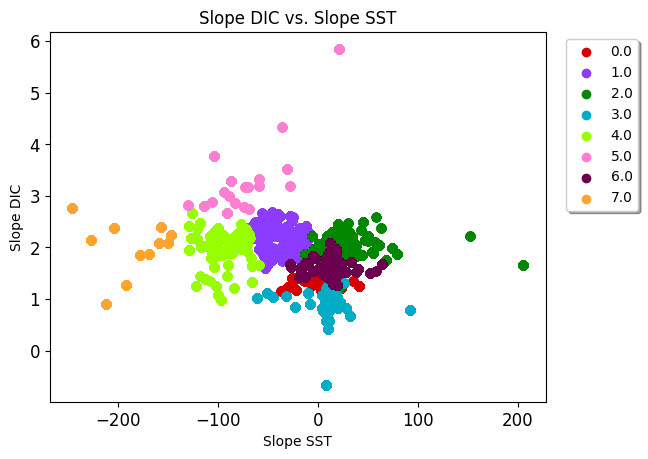

In [269]:
import matplotlib.cm as cm

tot_clusters = appended_data_kmeans['kmeans_cluster'].unique()
tot_clusters = np.sort(tot_clusters)
num = len(appended_data_kmeans['kmeans_cluster'].unique())
# Non repeating random colors
colors = sns.color_palette(cc.glasbey, n_colors=num)

for t, c in zip(tot_clusters, colors):
    df = appended_data_kmeans.loc[appended_data_kmeans['kmeans_cluster'] == t]
    x = df['slope_sst'].values
    y = df['slope_dicp'].values
    plt.scatter(x, y, color=c, label = f'{t}')

plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
plt.title(f"Slope DIC vs. Slope SST")
plt.xlabel("Slope SST")
plt.ylabel("Slope DIC")
plt.show()


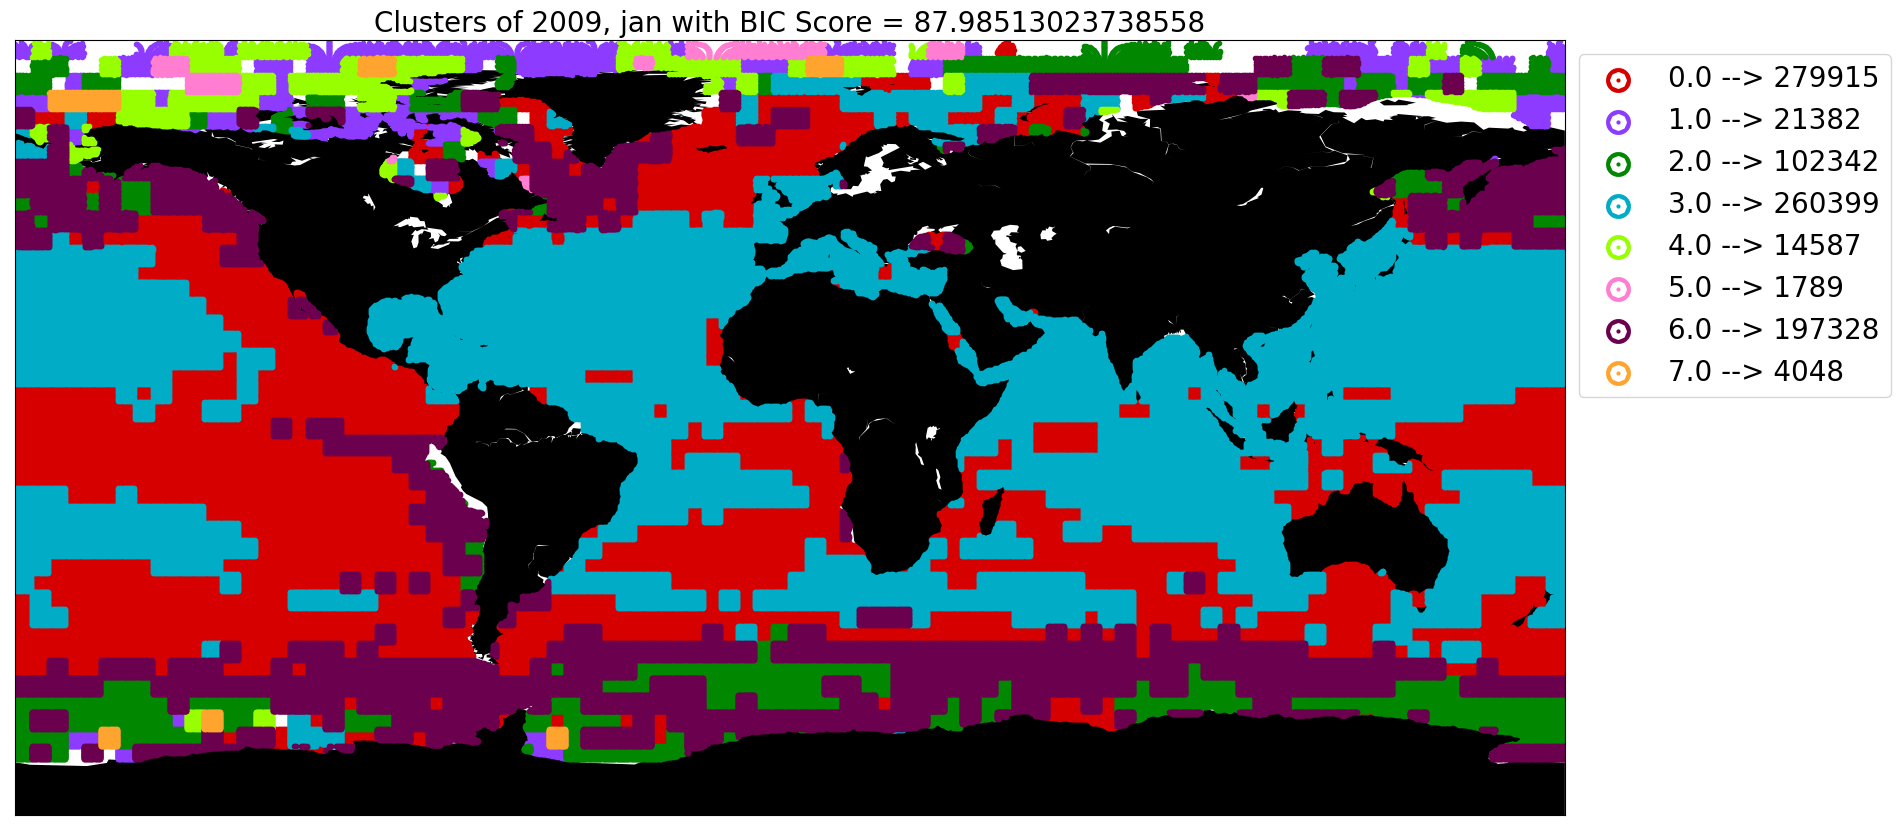

In [270]:
fig = plt.figure(figsize=(20, 16), edgecolor='w')
regime_map = Basemap(projection='cyl', resolution='c',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
## Draw the coast.
# regime_map.drawcoastlines()

## Draw the land shades.
# regime_map.shadedrelief()

## Fill the land mass and lakes
regime_map.fillcontinents(color='black') #color_lake='aqua'

## draw parallels and meridians.
# regime_map.drawparallels(np.arange(-90,91,10),labels=[1,1,0,1], fontsize=12)
# regime_map.drawmeridians(np.arange(-180,181,10),labels=[1,1,0,1], rotation=45, fontsize=12)

##color the sea/oceans
# regime_map.drawmapboundary(fill_color='aqua')

count = 0
arr = np.sort((appended_data_kmeans['kmeans_cluster'].unique()))
for cluster_num in arr:
#     if cluster_num != 7:
#         continue
    _df_ = appended_data_kmeans.loc[appended_data_kmeans['kmeans_cluster'] == cluster_num]
    lbl = f"{cluster_num} --> {len(_df_)}"
    regime_map.scatter(_df_['nav_lon'], _df_['nav_lat'], latlon=True,marker='.', 
              color=clrs[count],label = lbl)
    count = count + 1
#     if count == 4:
#         break


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
lgnd = plt.legend(by_label.values(), by_label.keys(),loc='best', ncol=1, fontsize=20,bbox_to_anchor=(1.0, 1.0))
for handle in lgnd.legendHandles:
    handle.set_linewidth(15)

plt.title(f'Clusters of {_year}, {_month} with BIC Score = {b_score}',fontsize=20)
# plt.xlabel('Longitude', fontsize=20, labelpad=40)
# plt.ylabel('Latitude', fontsize=20, labelpad=40)

plt.show()

# Traditional HC

In [419]:
X = norm_hc_df[['slope_sst_std', 'slope_dic_std', 'slope_alk_std', 'slope_sal_std']].values
Z = hierarchy.linkage(X, method='ward')
Z

array([[10094.        , 10100.        ,     0.00080039,     2.        ],
       [10097.        , 10098.        ,     0.00176338,     2.        ],
       [10242.        , 10245.        ,     0.00222941,     2.        ],
       ...,
       [20592.        , 20594.        ,    86.99095361,  6062.        ],
       [20591.        , 20596.        ,   105.41661885, 10281.        ],
       [20595.        , 20597.        ,   128.52883819, 10300.        ]])

In [426]:
k=8
hierarchy.fcluster(Z, t=k, criterion='maxclust')

array([3, 3, 3, ..., 3, 3, 3], dtype=int32)

In [427]:
norm_hc_df['cluster_traditional'] = hierarchy.fcluster(Z, t=k, criterion='maxclust')
norm_hc_df

slope_sst  slope_dic  slope_alk  slope_sal  slope_sst_std  \
1080   11.247488   1.637784  -1.451717   6.965093      -0.057836   
1081   11.497229   1.609121  -1.413692   6.130099      -0.042029   
1082   11.484953   1.571981  -1.384503   6.053161      -0.042806   
1083   10.328856   1.476411  -1.309035   6.448380      -0.115979   
1084   10.403825   1.550725  -1.382162   6.572474      -0.111234   
...          ...        ...        ...        ...            ...   
16190  12.023954   2.159593  -1.945546   7.469791      -0.008691   
16192  13.834898   2.205279  -1.985019   9.062600       0.105929   
16194   9.117247   2.246602  -2.021724   9.236017      -0.192666   
16197  11.304727   2.115715  -1.910059   5.301209      -0.054214   
16199  12.522893   2.180318  -1.966582   7.288010       0.022888   

       slope_dic_std  slope_alk_std  slope_sal_std  cluster_traditional  \
1080        0.610687      -0.158819      -0.022614                    3   
1081        0.531908      -0.134899      -0.030529                    3   
1082        0.429827      -0.116538      -0.031259                    3   
1083        0.167154      -0.069064      -0.027512                    3   
1084        0.371407      -0.115065      -0.026336                    3   
...              ...            ...            ...                  ...   
16190       2.044886      -0.469465      -0.017829                    3   
16192       2.170453      -0.494296      -0.002730                    3   
16194       2.284029      -0.517385      -0.001086                    3   
16197       1.924286      -0.447142      -0.038387                    3   
16199       2.101848      -0.482698      -0.019553                    3   

       kmeans_cluster  
1080                3  
1081                3  
1082                3  
1083                0  
1084                3  
...               ...  
16190               3  
16192               3  
16194               3  
16197               3  
16199               3  

[10300 rows x 10 columns]

In [428]:
labels_all = norm_hc_df['cluster_traditional'].values #all labels
#size of data set -> N datapoints with d no. of features
N, d = X.shape
#unique labels
labels_unique = norm_hc_df['cluster_traditional'].unique()

loglikelihood = 0  
for lbl in labels_unique:
    _df_ = norm_hc_df.loc[norm_hc_df['cluster_traditional'] == lbl]
    loglikelihood =loglikelihood + np.log(len(_df_)/N)

#BIC
BIC = -2 * loglikelihood + d * np.log(N)
AIC = -2 * loglikelihood + 2*d
b_score = BIC
b_score

123.3146238129755

In [429]:
appended_data_trad = []
for index, row in norm_hc_df.iterrows():
    # get the corresponding grid from the list of grids
    _df_ = grids_df_lst[index]
    _df_['grid_id'] = index
    _df_['cluster_traditional'] = row['cluster_traditional']
    _df_['slope_sst'] = row['slope_sst']
    _df_['slope_dic'] = row['slope_dic']
    _df_['slope_alk'] = row['slope_alk']
    _df_['slope_sst_std'] = row['slope_sst_std']
    _df_['slope_dic_std'] = row['slope_dic_std']
    _df_['slope_alk_std'] = row['slope_alk_std']
    _df_['BIC'] = BIC
    appended_data_trad.append(_df_)
appended_data_trad = pd.concat(appended_data_trad)
appended_data_trad

nav_lat  nav_lon       sst          dic          alk        sal  \
0        -76.95  -179.75 -0.531698  1952.550293  2115.781982  31.509146   
1        -76.95  -179.50 -0.552196  1951.565796  2114.570312  31.485117   
2        -76.95  -179.25 -0.572038  1950.894653  2113.717041  31.466675   
3        -76.95  -179.00 -0.590805  1950.586548  2113.283936  31.454617   
4        -76.95  -178.75 -0.608288  1950.596924  2113.148926  31.447378   
...         ...      ...       ...          ...          ...        ...   
893398    88.52   178.35 -1.705290  1934.908691  2053.834961  31.451097   
893480    88.62   179.45 -1.705957  1932.613037  2051.161133  31.451471   
893708    88.95   178.41 -1.705892  1930.245728  2049.083984  31.469732   
893910    89.37   178.52 -1.702868  1927.047852  2046.561035  31.500065   
894006    89.79   178.98 -1.709990  1923.259766  2043.057495  31.541739   

              fco2  grid_id cluster  slope_sst  ...  slope_sst_std  \
0       227.253235     1080       7  11.247488  ...      -0.057836   
1       227.031006     1080       7  11.247488  ...      -0.057836   
2       226.850754     1080       7  11.247488  ...      -0.057836   
3       226.708252     1080       7  11.247488  ...      -0.057836   
4       226.701416     1080       7  11.247488  ...      -0.057836   
...            ...      ...     ...        ...  ...            ...   
893398  280.968994    16199       7  12.522893  ...       0.022888   
893480  281.219788    16199       7  12.522893  ...       0.022888   
893708  280.273346    16199       7  12.522893  ...       0.022888   
893910  278.523651    16199       7  12.522893  ...       0.022888   
894006  277.368378    16199       7  12.522893  ...       0.022888   

        slope_dic_std  slope_alk_std         BIC  delta_var  delta_dist  \
0            0.610687      -0.158819  123.314624        0.1        20.0   
1            0.610687      -0.158819  123.314624        0.1        20.0   
2            0.610687      -0.158819  123.314624        0.1        20.0   
3            0.610687      -0.158819  123.314624        0.1        20.0   
4            0.610687      -0.158819  123.314624        0.1        20.0   
...               ...            ...         ...        ...         ...   
893398       2.101848      -0.482698  123.314624        0.1        20.0   
893480       2.101848      -0.482698  123.314624        0.1        20.0   
893708       2.101848      -0.482698  123.314624        0.1        20.0   
893910       2.101848      -0.482698  123.314624        0.1        20.0   
894006       2.101848      -0.482698  123.314624        0.1        20.0   

        cluster_traditional  slope_sal  slope_sal_std  kmeans_cluster  
0                       3.0   6.965093      -0.022614             3.0  
1                       3.0   6.965093      -0.022614             3.0  
2                       3.0   6.965093      -0.022614             3.0  
3                       3.0   6.965093      -0.022614             3.0  
4                       3.0   6.965093      -0.022614             3.0  
...                     ...        ...            ...             ...  
893398                  3.0   7.288010      -0.019553             3.0  
893480                  3.0   7.288010      -0.019553             3.0  
893708                  3.0   7.288010      -0.019553             3.0  
893910                  3.0   7.288010      -0.019553             3.0  
894006                  3.0   7.288010      -0.019553             3.0  

[835489 rows x 22 columns]

In [430]:
appended_data_trad['cluster_traditional'].unique()

array([3., 8., 7., 5., 6., 1., 2., 4.])

In [431]:
import colorcet as cc

num = len(appended_data_trad['cluster'].unique()) # num = len(cluster_list)
# Non repeating random colors
clrs = sns.color_palette(cc.glasbey, n_colors=num) # clrs = sns.color_palette("hls", num)
clrs

[(0.8392156862745098, 0.0, 0.0),
 (0.5490196078431373, 0.23137254901960785, 1.0),
 (0.00392156862745098, 0.5294117647058824, 0.0),
 (0.0, 0.6745098039215687, 0.7764705882352941),
 (0.592156862745098, 1.0, 0.0),
 (1.0, 0.49411764705882355, 0.8196078431372549),
 (0.4196078431372549, 0.0, 0.30980392156862746),
 (1.0, 0.6470588235294118, 0.1843137254901961)]

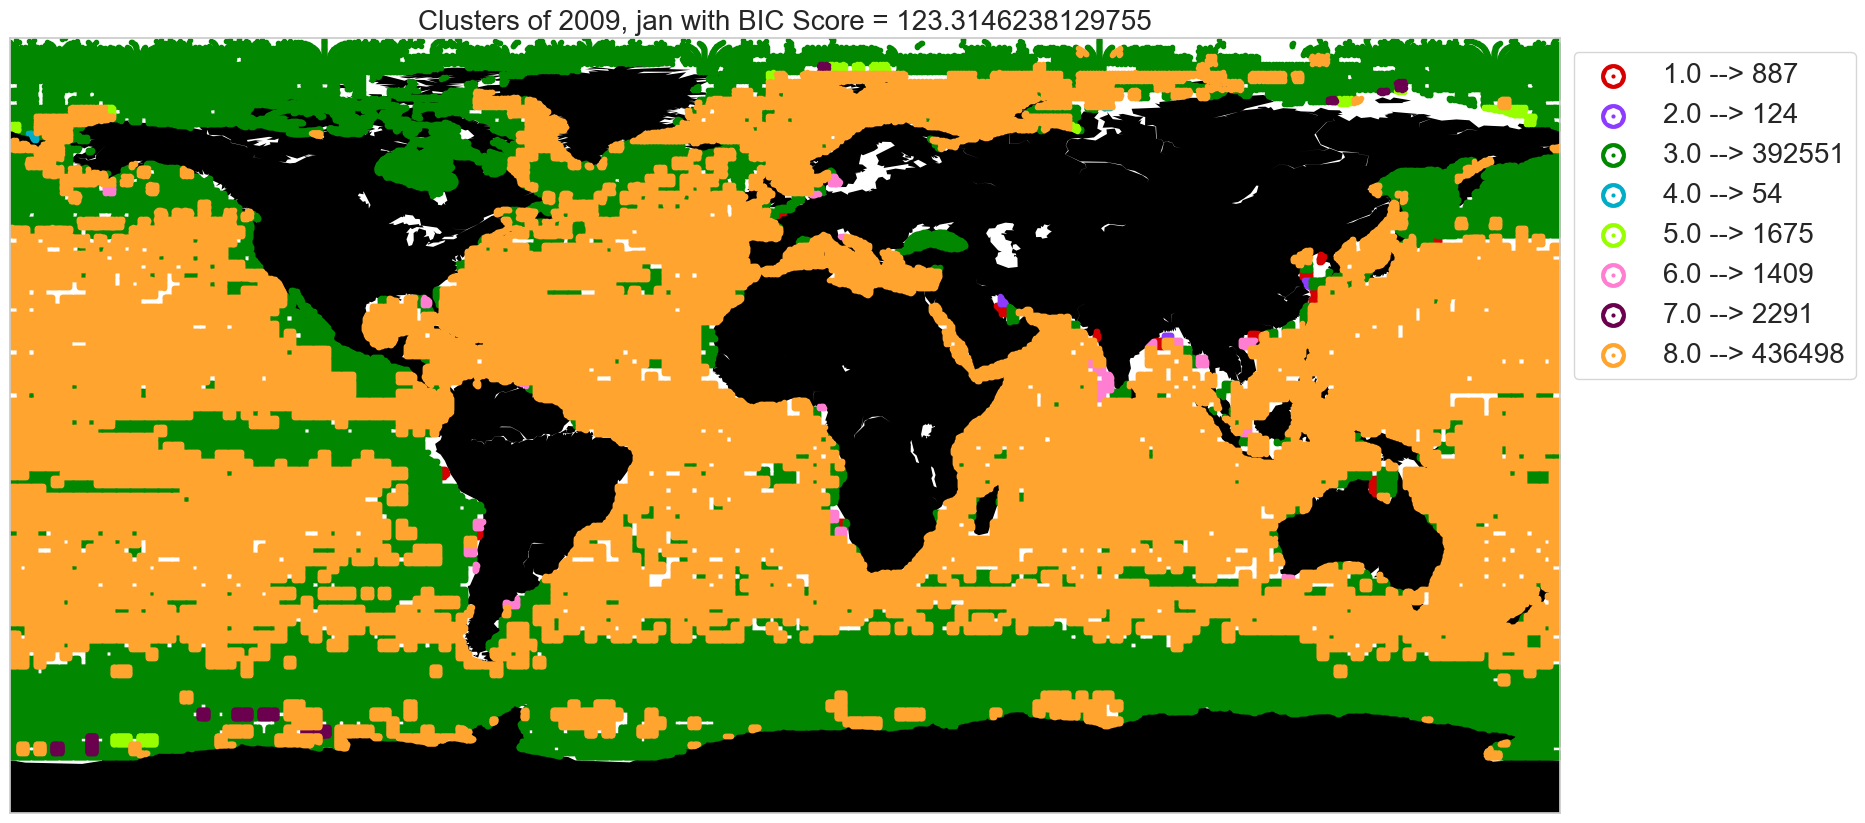

In [432]:
fig = plt.figure(figsize=(20, 16), edgecolor='w')
regime_map = Basemap(projection='cyl', resolution='c',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
## Draw the coast.
# regime_map.drawcoastlines()

## Draw the land shades.
# regime_map.shadedrelief()

## Fill the land mass and lakes
regime_map.fillcontinents(color='black') #color_lake='aqua'

## draw parallels and meridians.
# regime_map.drawparallels(np.arange(-90,91,10),labels=[1,1,0,1], fontsize=12)
# regime_map.drawmeridians(np.arange(-180,181,10),labels=[1,1,0,1], rotation=45, fontsize=12)

##color the sea/oceans
# regime_map.drawmapboundary(fill_color='aqua')

count = 0
arr = np.sort((appended_data_trad['cluster_traditional'].unique()))
# print(arr)

# arr=[2,3]

for cluster_num in arr:
#     if cluster_num != 7:
#         continue
    _df_ = appended_data_trad.loc[appended_data_trad['cluster_traditional'] == cluster_num]
    lbl = f"{cluster_num} --> {len(_df_)}"
    regime_map.scatter(_df_['nav_lon'], _df_['nav_lat'], latlon=True,marker='.', 
              color=clrs[count],label = lbl)
    count = count + 1
#     if count == 4:
#         break


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
lgnd = plt.legend(by_label.values(), by_label.keys(),loc='best', ncol=1, fontsize=20,bbox_to_anchor=(1.0, 1.0))
for handle in lgnd.legendHandles:
    handle.set_linewidth(15)

plt.title(f'Clusters of {_year}, {_month} with BIC Score = {b_score}',fontsize=20)
# plt.xlabel('Longitude', fontsize=20, labelpad=40)
# plt.ylabel('Latitude', fontsize=20, labelpad=40)

plt.show()

In [433]:
appended_data_trad.to_pickle(f"../Clustering_Output/traditional_hc_clusters_orca025_{_year}_{_month}.pkl")

## Plots

In [703]:
# '''
# https://stackoverflow.com/questions/19778167/
# matching-dendrogram-with-cluster-number-in-pythons-scipy-cluster-hierarchy
# '''

# '''
# https://stackoverflow.com/questions/7664826/
# how-to-get-flat-clustering-corresponding-to-color-clusters-in-the-dendrogram-cre
# '''

# import scipy
# import scipy.cluster.hierarchy as sch
# import matplotlib.pylab as plt

# n=100
# k=8
# X = scipy.randn(n,2)
# d = sch.distance.pdist(X)
# Z= sch.linkage(d,method='ward')
# T = sch.fcluster(Z, k, 'maxclust')

# # calculate labels
# labels=list('' for i in range(n))
# for i in range(n):
#     labels[i]=str(i)+ ',' + str(T[i])

# # # calculate color threshold
# # ct=Z[-(k-1),2]  

# # #plot
# # P =sch.dendrogram(Z,labels=labels,color_threshold=ct)
# # plt.show()

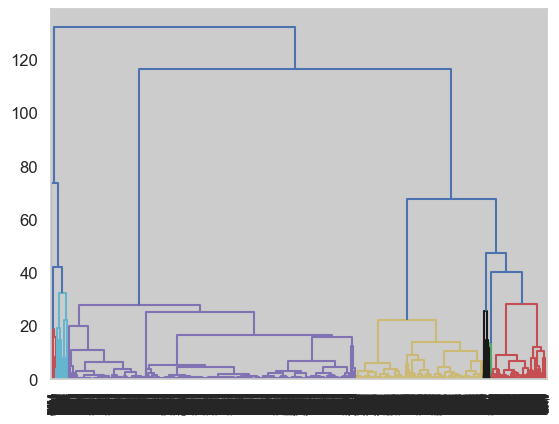

In [704]:
n = X.shape[0]
T = hierarchy.fcluster(Z, t=k, criterion='maxclust')

# match labels and datapoint
labels=list('' for i in range(n))
for i in range(n):
    labels[i]=str(i)+ ',' + str(T[i]) # => datapoint, label
    
# calculate color threshold
ct=Z[-(k-1),2]  

#plot
P =hierarchy.dendrogram(Z,labels=labels,color_threshold=ct)
plt.show()

In [705]:
ct

32.41404067759817

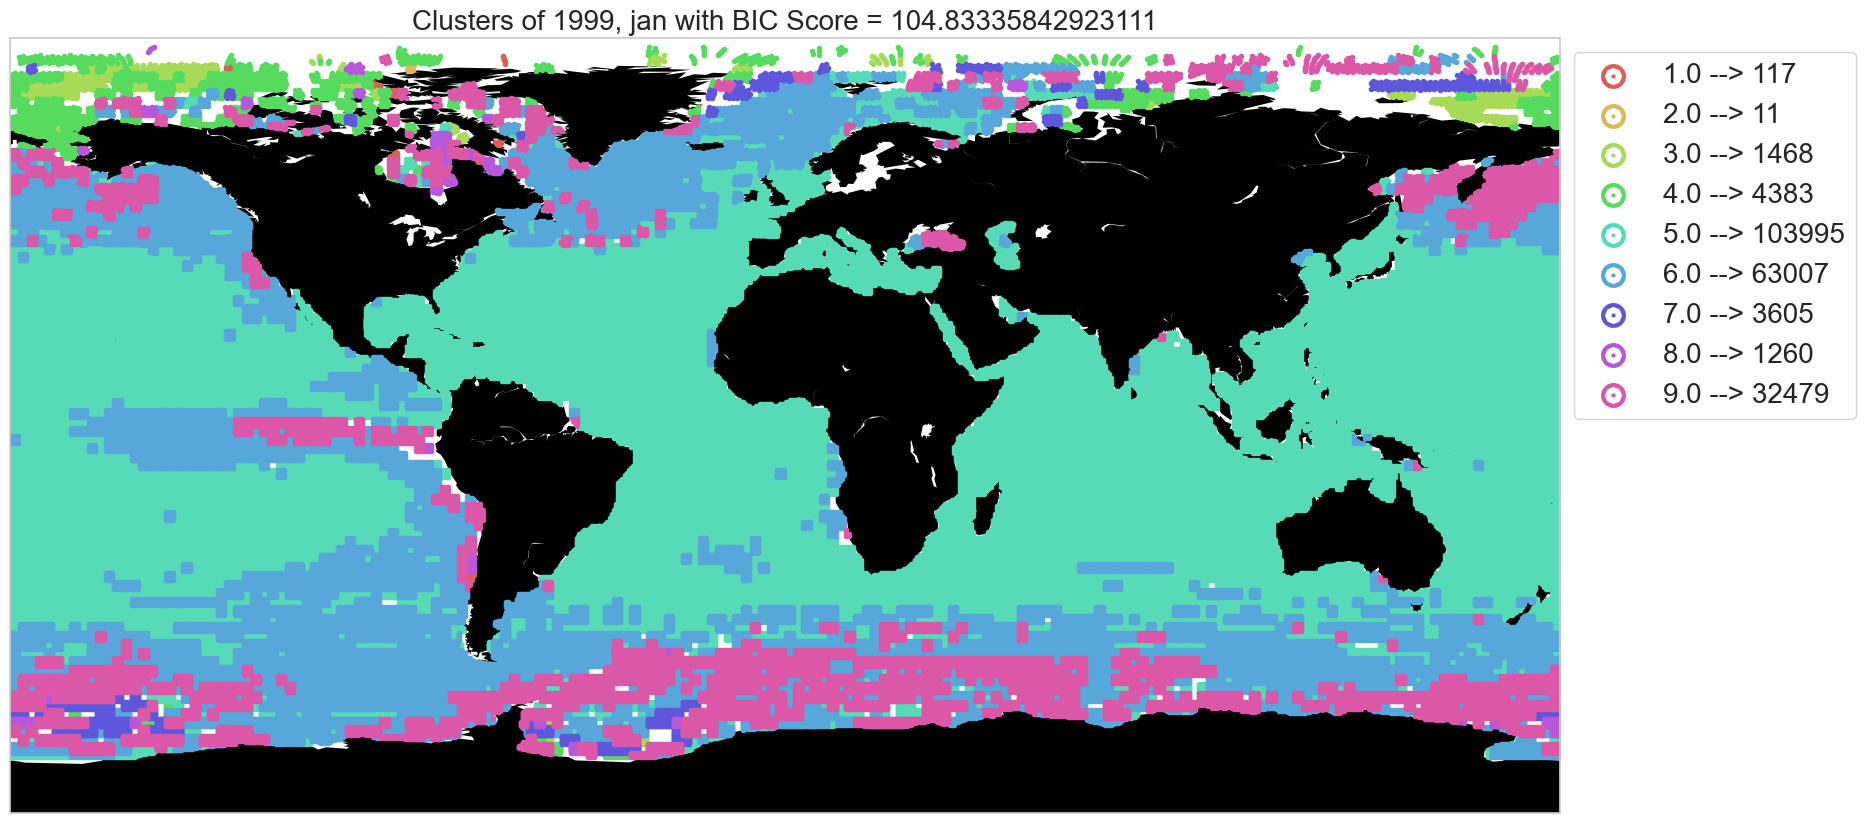

In [706]:
fig = plt.figure(figsize=(20, 16), edgecolor='w')
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
## Draw the coast.
# m.drawcoastlines()

## Draw the land shades.
# m.shadedrelief()

## Fill the land mass and lakes
m.fillcontinents(color='black') #color_lake='aqua'

## draw parallels and meridians.
# m.drawparallels(np.arange(-90,91,10),labels=[1,1,0,1], fontsize=12)
# m.drawmeridians(np.arange(-180,181,10),labels=[1,1,0,1], rotation=45, fontsize=12)

##color the sea/oceans
# m.drawmapboundary(fill_color='aqua')

count = 0
arr = np.sort((appended_data_trad['cluster_traditional'].unique()))
# print(arr)

# arr=[2,3]

for cluster_num in arr:
#     if cluster_num != 7:
#         continue
    _df_ = appended_data_trad.loc[appended_data_trad['cluster_traditional'] == cluster_num]
    lbl = f"{cluster_num} --> {len(_df_)}"
    m.scatter(_df_['nav_lon'], _df_['nav_lat'], latlon=True,marker='.', 
              color=clrs[count],label = lbl)
    count = count + 1
#     if count == 4:
#         break


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
lgnd = plt.legend(by_label.values(), by_label.keys(),loc='best', ncol=1, fontsize=20,bbox_to_anchor=(1.0, 1.0))
for handle in lgnd.legendHandles:
    handle.set_linewidth(15)

plt.title(f'Clusters of {_year}, {_month} with BIC Score = {b_score}',fontsize=20)
# plt.xlabel('Longitude', fontsize=20, labelpad=40)
# plt.ylabel('Latitude', fontsize=20, labelpad=40)

plt.show()

# Distribution Analysis

## Feature Significance

### On a global scale

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# from sklearn.inspection import permutation_importance

In [194]:
y= 2018
m= 'jan'
regimes_df = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{y}_{m}_025.pkl")
# regimes_df = pd.read_pickle(f"../Clustering_Output/DEMO_Natural_adaptive_hc_clusters_{y}_{m}_3feat_025.pkl")
# regimes_df = pd.read_pickle(f"../Clustering_Output/DEMO_Anthropogenic_adaptive_hc_clusters_{y}_{m}_3feat_025.pkl")

# regimes_df

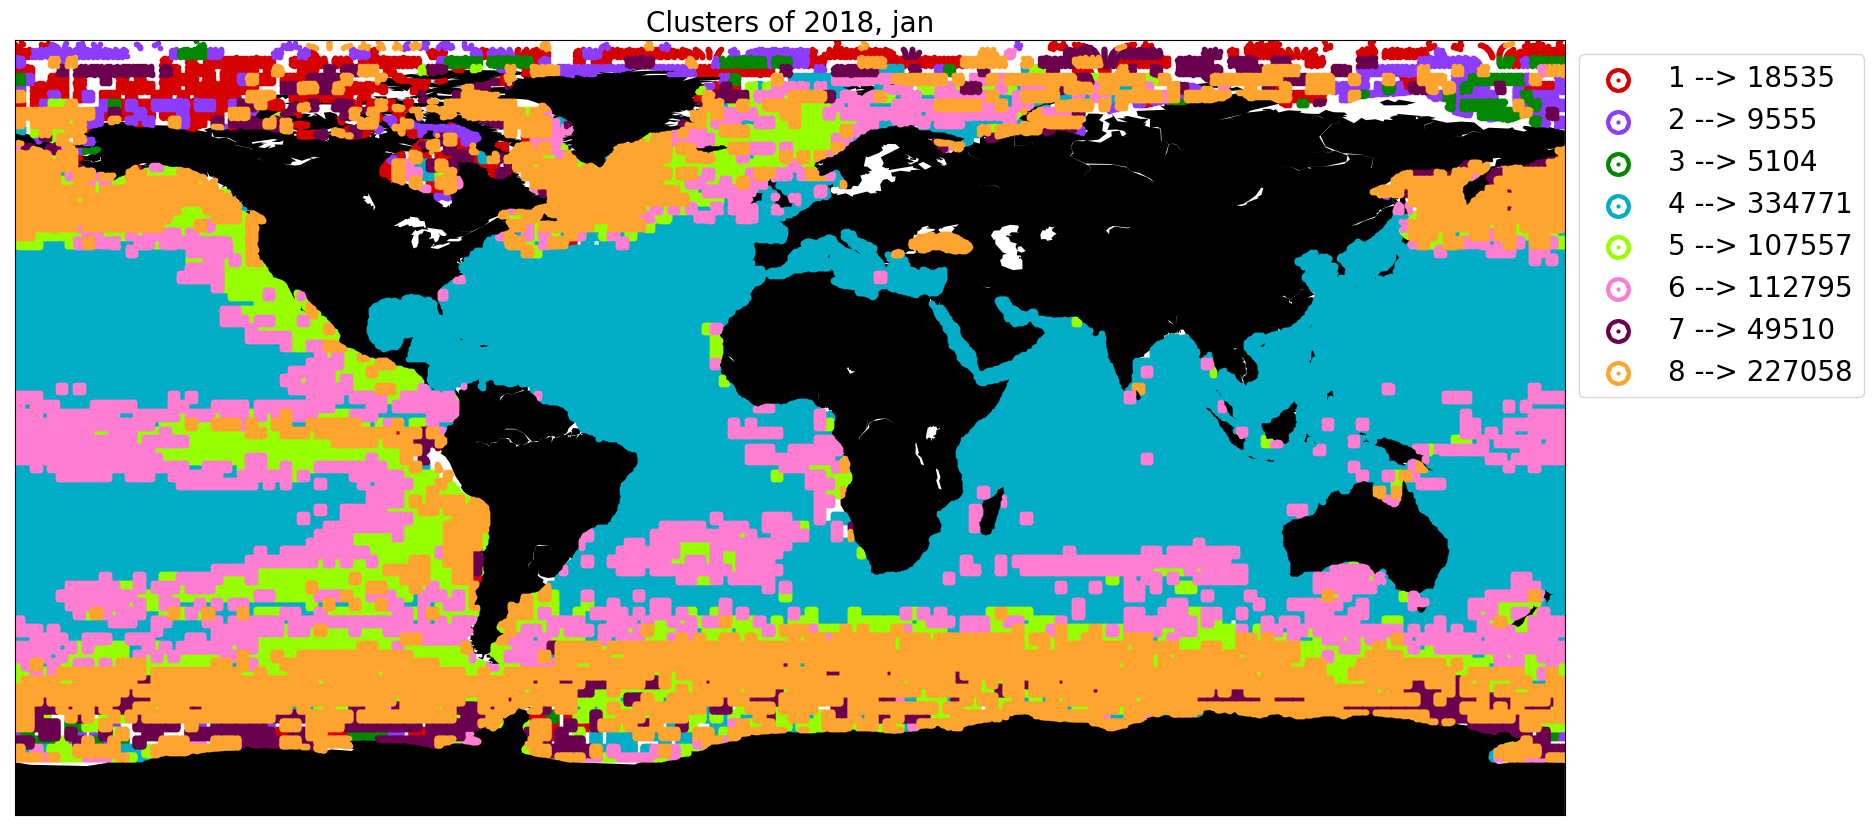

In [195]:
import colorcet as cc

num = len(regimes_df['cluster'].unique()) # num = len(cluster_list)
# Non repeating random colors
cluster_colors = sns.color_palette(cc.glasbey, n_colors=num + 10) # clrs = sns.color_palette("hls", num)

fig = plt.figure(figsize=(20, 16), edgecolor='w')
regime_map = Basemap(projection='cyl', resolution='c',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
## Draw the coast.
# regime_map.drawcoastlines()

## Draw the land shades.
# regime_map.shadedrelief()

## Fill the land mass and lakes
regime_map.fillcontinents(color='black') #color_lake='aqua'

## draw parallels and meridians.
# regime_map.drawparallels(np.arange(-90,91,10),labels=[1,1,0,1], fontsize=12)
# regime_map.drawmeridians(np.arange(-180,181,10),labels=[1,1,0,1], rotation=45, fontsize=12)

##color the sea/oceans
# regime_map.drawmapboundary(fill_color='aqua')

count = 0
arr = np.sort((regimes_df['cluster'].unique()))

for cluster_num in arr:

    _df_ = regimes_df.loc[regimes_df['cluster'] == cluster_num]
    lbl = f"{int(cluster_num)} --> {len(_df_)}"
#     lbl = f"{int(cluster_num)} ({round(_df_['area'].sum()/1000000,2)} km sq)"
    regime_map.scatter(_df_['nav_lon'], _df_['nav_lat'], latlon=True,marker='.', 
              color=cluster_colors[count],label = lbl)
    count = count + 1

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
lgnd = plt.legend(by_label.values(), by_label.keys(),loc='best', ncol=1, fontsize=20,bbox_to_anchor=(1.0, 1.0))
for handle in lgnd.legendHandles:
    handle.set_linewidth(15)

plt.title(f'Clusters of {y}, {m}',fontsize=20)
# plt.title(f'Clusters of {_year}, {_month} with BIC Score = {b_score}',fontsize=20)
# plt.xlabel('Longitude', fontsize=20, labelpad=40)
# plt.ylabel('Latitude', fontsize=20, labelpad=40)

plt.show()

In [196]:
track_regimes = {
    2009: [4,5],
    2010: [2,3],
    2011: [1,4],
    2012: [2,5],
    2013: [1,10],
    2014: [1,8],
    2015: [1,4],
    2016: [2,7],
    2017: [1,5],
    2018: [4,8],
}

In [335]:
m='jan'
y=2009
regimes_df = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{y}_{m}_025.pkl")
base_df = regimes_df[['nav_lat', 'nav_lon']]
# base_df['A'] = 0
# base_df['B'] = 0
base_df

nav_lat  nav_lon
0        -76.95  -179.75
1        -76.95  -179.50
2        -76.95  -179.25
3        -76.95  -179.00
4        -76.95  -178.75
...         ...      ...
893121    88.21   175.79
893420    88.54   174.21
893504    88.64   175.02
893575    88.75   175.97
893824    89.17   174.79

[869800 rows x 2 columns]

In [336]:
%%time
m = 'jan'
df_list = []
for key, value in track_regimes.items():
    regimes_df = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{key}_{m}_025.pkl")
    _df_ = regimes_df[['nav_lat', 'nav_lon', 'cluster']]
    _df_['A'] = 0
    _df_.loc[_df_['cluster'] == value[1], 'A'] = 1
#     _df_.loc[_df_['cluster'] == value[1], 'B'] = 1
    df_ = base_df.merge(_df_, on = ['nav_lat', 'nav_lon'], how = 'left')
    df_list.append(df_.fillna(0))

CPU times: user 4.13 s, sys: 489 ms, total: 4.62 s
Wall time: 4.98 s


In [337]:
df_list[4]

nav_lat  nav_lon  cluster    A
0        -76.95  -179.75     10.0  1.0
1        -76.95  -179.50     10.0  1.0
2        -76.95  -179.25     10.0  1.0
3        -76.95  -179.00     10.0  1.0
4        -76.95  -178.75     10.0  1.0
...         ...      ...      ...  ...
869795    88.21   175.79      0.0  0.0
869796    88.54   174.21      0.0  0.0
869797    88.64   175.02      0.0  0.0
869798    88.75   175.97      0.0  0.0
869799    89.17   174.79      0.0  0.0

[869800 rows x 4 columns]

In [338]:
df0 = df_list[0]
for count, df in enumerate(df_list):
    if count == 0:
        continue
    df0['A'] = df0['A'] + df['A']
#     df0['B'] = df0['B'] + df['B']

# df2 = df_list[2]

# df_add = df1['A'].add(df2['A'], fill_value=0)
df0

nav_lat  nav_lon  cluster    A
0        -76.95  -179.75      6.0  5.0
1        -76.95  -179.50      6.0  5.0
2        -76.95  -179.25      6.0  5.0
3        -76.95  -179.00      6.0  5.0
4        -76.95  -178.75      6.0  5.0
...         ...      ...      ...  ...
869795    88.21   175.79      5.0  1.0
869796    88.54   174.21      5.0  1.0
869797    88.64   175.02      5.0  1.0
869798    88.75   175.97      5.0  1.0
869799    89.17   174.79      5.0  1.0

[869800 rows x 4 columns]

In [339]:
df0['A'].unique()

array([5., 3., 1., 2., 4., 6., 0., 7., 8., 9.])

In [340]:
df0['A_per'] = (df0['A'] / 10) * 100
# df0['B_per'] = (df0['B'] / 10) * 100
df0

nav_lat  nav_lon  cluster    A  A_per
0        -76.95  -179.75      6.0  5.0   50.0
1        -76.95  -179.50      6.0  5.0   50.0
2        -76.95  -179.25      6.0  5.0   50.0
3        -76.95  -179.00      6.0  5.0   50.0
4        -76.95  -178.75      6.0  5.0   50.0
...         ...      ...      ...  ...    ...
869795    88.21   175.79      5.0  1.0   10.0
869796    88.54   174.21      5.0  1.0   10.0
869797    88.64   175.02      5.0  1.0   10.0
869798    88.75   175.97      5.0  1.0   10.0
869799    89.17   174.79      5.0  1.0   10.0

[869800 rows x 5 columns]

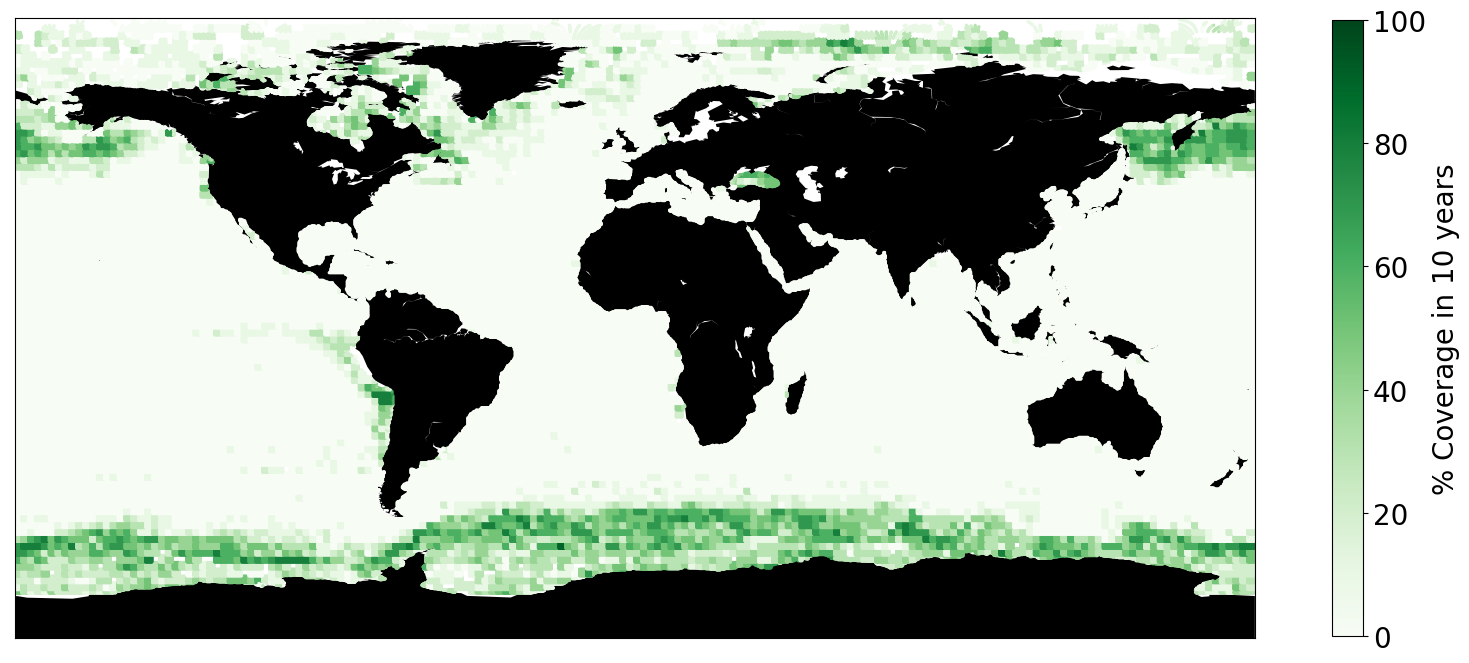

In [347]:
fig = plt.figure(figsize=(20, 16), edgecolor='w')
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )

# m.shadedrelief()
## Fill the land mass and lakes
m.fillcontinents(color='black') #color_lake='aqua'

# plt.title(f'Coverage of CUR A: Subtropical Regime(I) over 2009 - 2018', fontsize=20)
map_scatter =m.scatter(df0['nav_lon'], df0['nav_lat'], 
              s = 5, c = df0['A_per'],
                       vmin=0, vmax =100, cmap='Greens', edgecolors='none')

cbar = plt.colorbar(map_scatter, shrink = 0.5)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('% Coverage in 10 years', fontsize=20)
plt.show()

In [379]:
tot_clusters = np.sort(regimes_df['cluster'].unique())
colors = cm.rainbow(np.linspace(0, 1, len(tot_clusters)))

for t, c in zip(tot_clusters, clrs):
    df = regimes_df.loc[regimes_df['cluster'] == t]
    x = df['slope_sst'].values
    y = df['slope_dicp'].values
    plt.scatter(x, y, color=c, label = f'{t}')

plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
plt.title(f"Slope DIC vs. Slope SST")
plt.xlabel("Slope SST")
plt.ylabel("Slope DIC")
plt.show()

NameError: name 'cm' is not defined

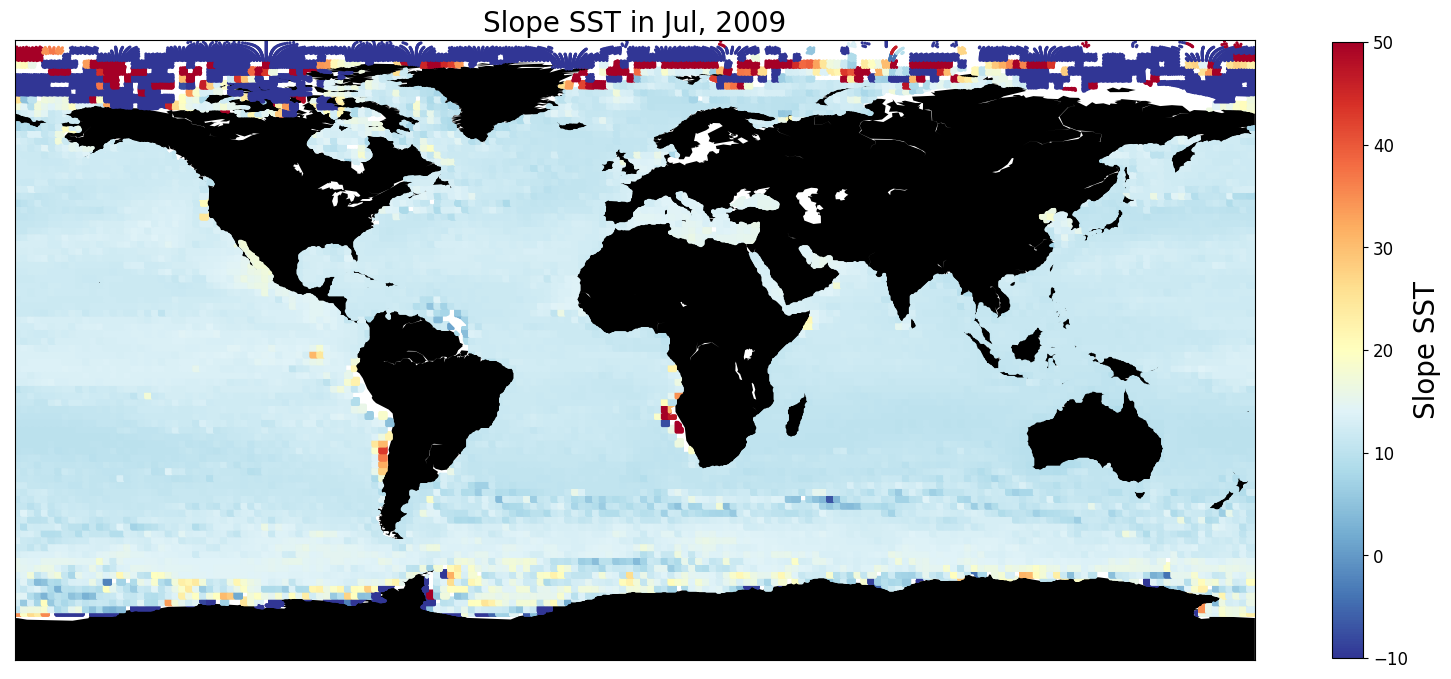

In [301]:
fig = plt.figure(figsize=(20, 16), edgecolor='w')
world_map = Basemap(projection='cyl', resolution='c',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )

# m.shadedrelief()
## Fill the land mass and lakes
world_map.fillcontinents(color='black') #color_lake='aqua'

# plt.title(f'Slope SST in {y} - {m}', fontsize=20)
plt.title(f'Slope SST in Jul, 2009', fontsize=20)
world_map_scatter =world_map.scatter(regimes_df['nav_lon'], regimes_df['nav_lat'], 
              s = 5, c = regimes_df['slope_sst'],
                       vmin=-10, vmax =50, cmap='RdYlBu_r', edgecolors='none')

cbar = plt.colorbar(world_map_scatter, shrink = 0.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Slope SST', fontsize=20)
plt.show()

In [303]:
%%time

X = regimes_df[['sst', 'dic', 'alk']]
y = regimes_df['fco2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train, y_train)

sort = rf.feature_importances_.argsort()
feats = np.array(['sst', 'dic', 'alk'])
plt.barh(feats[sort], rf.feature_importances_[sort])
# plt.barh(feats, rf.feature_importances_)
plt.xlabel("Feature Importance")

print(rf.feature_importances_[sort])

NameError: name 'train_test_split' is not defined

[0.28985192 0.30619476 0.40395332]
CPU times: user 4min 55s, sys: 1.65 s, total: 4min 56s
Wall time: 4min 57s


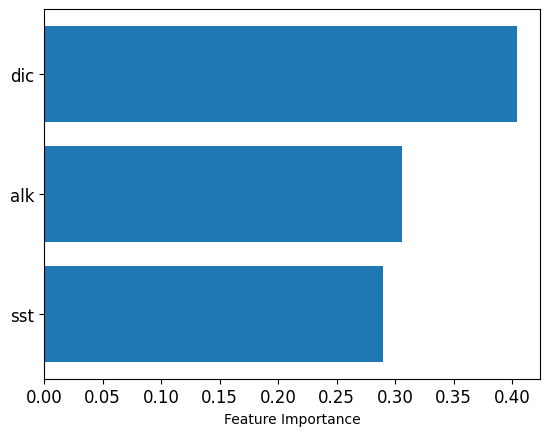

In [126]:
%%time

X = regimes_df[['sst', 'dic', 'alk']]
y = regimes_df['cluster'].astype(int).astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train, y_train)

sort = rf.feature_importances_.argsort()
feats = np.array(['sst', 'dic', 'alk'])
plt.barh(feats[sort], rf.feature_importances_[sort])
# plt.barh(feats, rf.feature_importances_)
plt.xlabel("Feature Importance")

print(rf.feature_importances_[sort])

[0.10751875 0.43621856 0.4562627 ]
CPU times: user 1min 5s, sys: 233 ms, total: 1min 5s
Wall time: 1min 5s


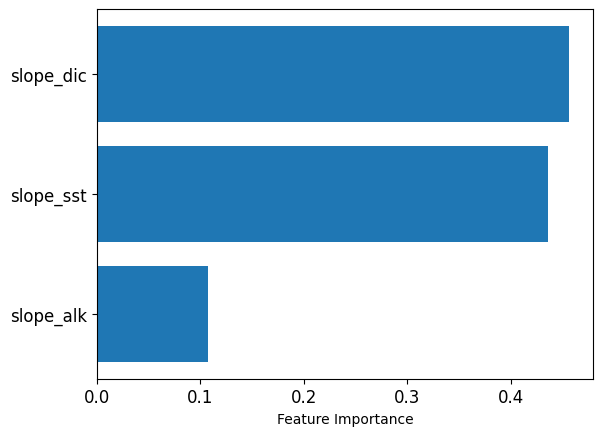

In [122]:
%%time

X = regimes_df[['slope_sst', 'slope_dic', 'slope_alk']]
y = regimes_df['cluster'].astype(int).astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train, y_train)

sort = rf.feature_importances_.argsort()
feats = np.array(['slope_sst', 'slope_dic', 'slope_alk'])
plt.barh(feats[sort], rf.feature_importances_[sort])
# plt.barh(feats, rf.feature_importances_)
plt.xlabel("Feature Importance")

print(rf.feature_importances_[sort])

### Inside each cluster

In [307]:
regimes_df

nav_lat  nav_lon       sst         dicp          dic          alk  \
0        -76.95  -179.75 -1.816866  2054.572266  2054.572266  2195.632324   
1        -76.95  -179.50 -1.816322  2055.086182  2055.086182  2196.274170   
2        -76.95  -179.25 -1.815987  2055.339844  2055.339844  2196.626709   
3        -76.95  -179.00 -1.815593  2054.782227  2054.782227  2196.184082   
4        -76.95  -178.75 -1.814844  2053.633301  2053.633301  2195.114014   
...         ...      ...       ...          ...          ...          ...   
891479    88.21   175.79 -1.739658  1986.538208  1986.538208  2109.809326   
891778    88.54   174.21 -1.737699  1977.451050  1977.451050  2100.341064   
891862    88.64   175.02 -1.738029  1977.236816  1977.236816  2100.060303   
891933    88.75   175.97 -1.738426  1977.990356  1977.990356  2100.762695   
892182    89.17   174.79 -1.738090  1981.917114  1981.917114  2104.343506   

              fco2    fco2_pre  grid_id cluster  slope_sst  slope_dicp  \
0       358.848328  278.724365     1080       3  34.702877    2.030716   
1       358.706024  278.588379     1080       3  34.702877    2.030716   
2       358.523773  278.415527     1080       3  34.702877    2.030716   
3       358.145599  278.067230     1080       3  34.702877    2.030716   
4       357.658356  277.616608     1080       3  34.702877    2.030716   
...            ...         ...      ...     ...        ...         ...   
891479  400.754669  285.586395    16197       2  85.326988    1.617429   
891778  398.683167  284.107056    16197       2  85.326988    1.617429   
891862  398.719208  284.127563    16197       2  85.326988    1.617429   
891933  399.009216  284.329865    16197       2  85.326988    1.617429   
892182  401.086548  285.787506    16197       2  85.326988    1.617429   

        slope_alk  slope_sst_std  slope_dicp_std  slope_alk_std        BIC  \
0       -1.747991        0.93611        1.112709      -1.136186  70.728196   
1       -1.747991        0.93611        1.112709      -1.136186  70.728196   
2       -1.747991        0.93611        1.112709      -1.136186  70.728196   
3       -1.747991        0.93611        1.112709      -1.136186  70.728196   
4       -1.747991        0.93611        1.112709      -1.136186  70.728196   
...           ...            ...             ...            ...        ...   
891479  -1.377228        2.67965        0.281429      -0.462145  70.728196   
891778  -1.377228        2.67965        0.281429      -0.462145  70.728196   
891862  -1.377228        2.67965        0.281429      -0.462145  70.728196   
891933  -1.377228        2.67965        0.281429      -0.462145  70.728196   
892182  -1.377228        2.67965        0.281429      -0.462145  70.728196   

        delta_var  delta_dist  
0             0.2        30.0  
1             0.2        30.0  
2             0.2        30.0  
3             0.2        30.0  
4             0.2        30.0  
...           ...         ...  
891479        0.2        30.0  
891778        0.2        30.0  
891862        0.2        30.0  
891933        0.2        30.0  
892182        0.2        30.0  

[870726 rows x 19 columns]

In [100]:
%%time
regimes_df['cluster'] = regimes_df['cluster'].astype(int).astype(str)
cluster_lbls = np.sort(regimes_df['cluster'].unique())

data_list = []

for cl in cluster_lbls:
    _df_ = regimes_df.loc[regimes_df['cluster'] == cl]
    X = _df_[['sst', 'dic', 'alk']]
    y = _df_['fco2']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    rf = RandomForestRegressor(n_estimators=150)
    rf.fit(X_train, y_train)
    
    data_list.append([cl, rf.feature_importances_[0], 
                           rf.feature_importances_[1], rf.feature_importances_[2]])

feature_importance_df = pd.DataFrame(columns=['Cluster# in January, 2009 (Anthropogenic)', 'SST', 'DIC', 'ALK'], data=data_list)
fig = px.bar(feature_importance_df, x="Cluster# in January, 2009 (Anthropogenic)", y=['SST', 'DIC', 'ALK'], title="Driver significance in individual regimes")
fig.show()

CPU times: user 4min 50s, sys: 4.54 s, total: 4min 55s
Wall time: 4min 57s


In [97]:
%%time
regimes_df['cluster'] = regimes_df['cluster'].astype(int).astype(str)
cluster_lbls = np.sort(regimes_df['cluster'].unique())

data_list = []

for cl in cluster_lbls:
    _df_ = regimes_df.loc[regimes_df['cluster'] == cl]
    X = _df_[['sst', 'dicp', 'alk']]
    y = _df_['fco2_pre']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    rf = RandomForestRegressor(n_estimators=150)
    rf.fit(X_train, y_train)
    
    data_list.append([cl, rf.feature_importances_[0], 
                           rf.feature_importances_[1], rf.feature_importances_[2]])

feature_importance_df = pd.DataFrame(columns=['Cluster# in July, 2009', 'SST', 'DIC', 'ALK'], data=data_list)
fig = px.bar(feature_importance_df, x="Cluster# in July, 2009", y=['SST', 'DIC', 'ALK'], title="Driver significance in individual regimes")
fig.show()

CPU times: user 4min 42s, sys: 4.52 s, total: 4min 47s
Wall time: 4min 48s


In [ ]:
feature_importance_df

In [365]:
# for cl in cluster_lbls:
#     _df_ = regimes_df.loc[regimes_df['cluster'] == cl]
#     X = _df_[['slope_sst', 'slope_dic', 'slope_alk']]
#     y = _df_['fco2']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#     rf = RandomForestRegressor(n_estimators=150)
#     rf.fit(X_train, y_train)
#     sort = rf.feature_importances_.argsort()
#     feats = np.array(['sst', 'dic', 'alk', 'slope_sst', 'slope_dic', 'slope_alk'])
#     plt.barh(feats[sort], rf.feature_importances_[sort])
#     # plt.barh(feats, rf.feature_importances_)
#     plt.xlabel(f"Feature Importance for Cluster# {cl}")
#     plt.show()
#     print(rf.feature_importances_[sort])
#     print()

## RegressionPlots

In [293]:
y = 2009
m = 'jan'

# regimes_df = pd.read_pickle(f"../Clustering_Output/DEMO_Natural_adaptive_hc_clusters_{y}_{m}_3feat_025.pkl")
regimes_df = pd.read_pickle(f"../Clustering_Output/DEMO_Anthropogenic_adaptive_hc_clusters_{y}_{m}_3feat_025.pkl")
# regimes_df = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{y}_{m}_3feat_025.pkl")
regimes_df['slope_alk'].max()

3.548276424407959

In [290]:
import colorcet as cc

num = len(regimes_df['cluster'].unique()) # num = len(cluster_list)
# Non repeating random colors
clrs = sns.color_palette(cc.glasbey, n_colors=num + 10) # clrs = sns.color_palette("hls", num)
clrs

[(0.8392156862745098, 0.0, 0.0),
 (0.5490196078431373, 0.23137254901960785, 1.0),
 (0.00392156862745098, 0.5294117647058824, 0.0),
 (0.0, 0.6745098039215687, 0.7764705882352941),
 (0.592156862745098, 1.0, 0.0),
 (1.0, 0.49411764705882355, 0.8196078431372549),
 (0.4196078431372549, 0.0, 0.30980392156862746),
 (1.0, 0.6470588235294118, 0.1843137254901961),
 (0.3411764705882353, 0.23137254901960785, 0.0),
 (0.0, 0.33725490196078434, 0.34901960784313724),
 (0.0, 0.0, 0.8666666666666667),
 (0.0, 0.9921568627450981, 0.8117647058823529),
 (0.6313725490196078, 0.4588235294117647, 0.4117647058823529),
 (0.7372549019607844, 0.7137254901960784, 1.0),
 (0.5843137254901961, 0.7098039215686275, 0.4666666666666667),
 (0.7490196078431373, 0.011764705882352941, 0.7215686274509804),
 (0.39215686274509803, 0.32941176470588235, 0.4549019607843137)]

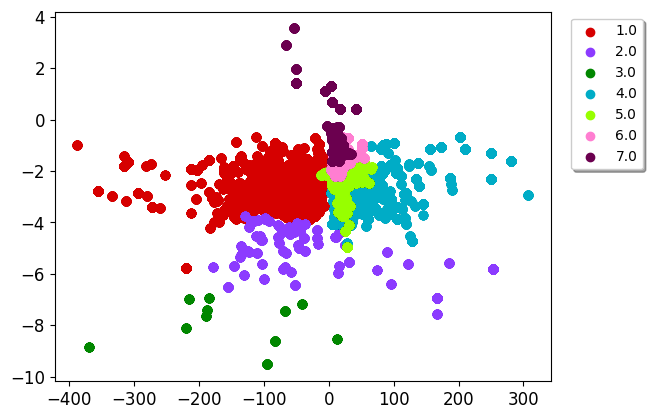

In [291]:
tot_clusters = np.sort(regimes_df['cluster'].unique())
for t, c in zip(tot_clusters, clrs):
    df = regimes_df.loc[regimes_df['cluster'] == t]
    x = df['slope_sst'].values
    y = df['slope_alk'].values
    plt.scatter(x, y, color=c, label = f'{t}')

plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
# plt.title(f"Slope DIC vs. Slope SST")
# plt.xlabel("Slope SST")
# plt.ylabel("Slope DIC")
plt.show()

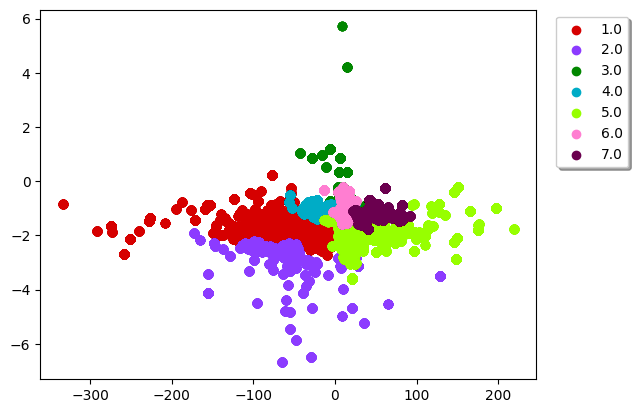

In [35]:
tot_clusters = np.sort(regimes_df['cluster'].unique())
for t, c in zip(tot_clusters, clrs):
    df = regimes_df.loc[regimes_df['cluster'] == t]
    x = df['slope_sst'].values
    y = df['slope_alk'].values
    plt.scatter(x, y, color=c, label = f'{t}')

plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
# plt.title(f"Slope DIC vs. Slope SST")
# plt.xlabel("Slope SST")
# plt.ylabel("Slope DIC")
plt.show()

In [21]:
# regimes_df['slope_sst'].max()

In [22]:
%%time
# sns.violinplot(data=regimes_df, x="slope_dicp", y="cluster")

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 12.9 µs


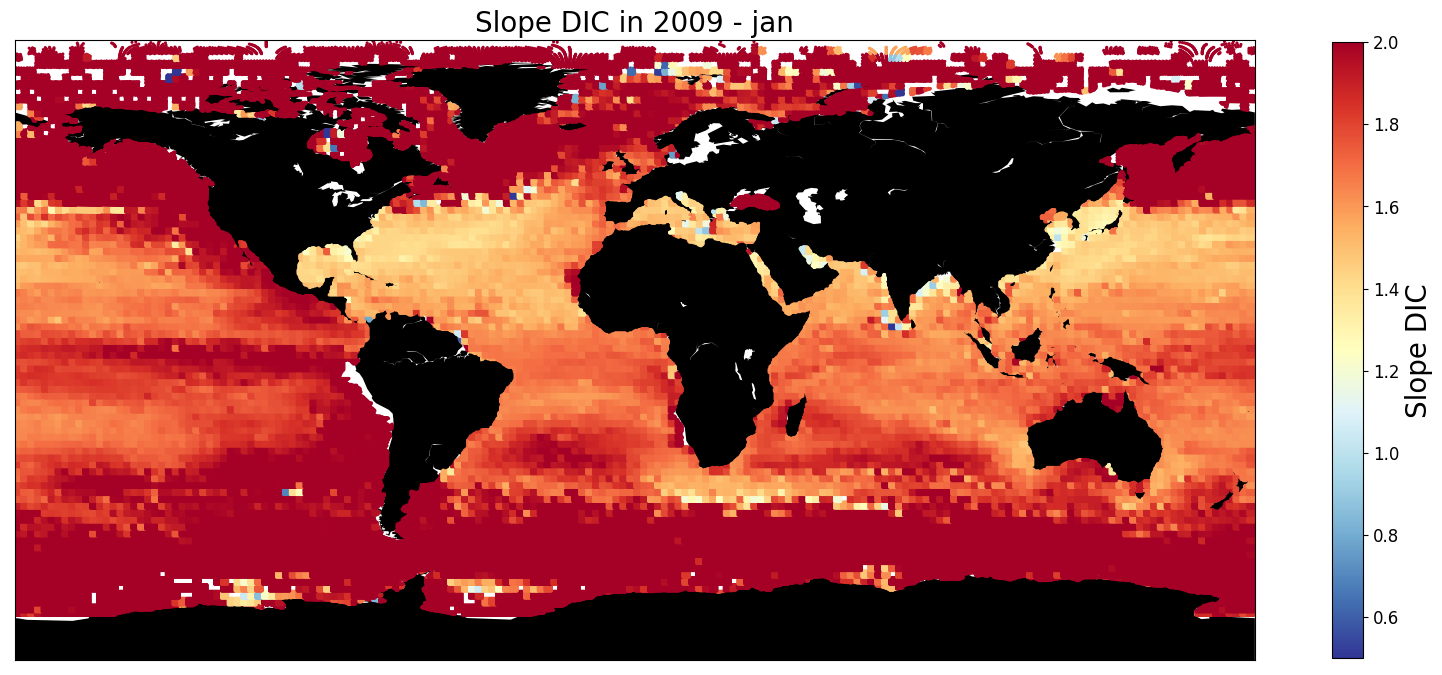

In [304]:
fig = plt.figure(figsize=(20, 16), edgecolor='w')
world_map = Basemap(projection='cyl', resolution='c',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )

# m.shadedrelief()
## Fill the land mass and lakes
world_map.fillcontinents(color='black') #color_lake='aqua'

plt.title(f'Slope DIC in {y} - {m}', fontsize=20)
world_map_scatter =world_map.scatter(regimes_df['nav_lon'], regimes_df['nav_lat'], 
              s = 5, c = regimes_df['slope_dic'],
                       vmin=0.5, vmax =2.0, cmap='RdYlBu_r', edgecolors='none')

cbar = plt.colorbar(world_map_scatter, shrink = 0.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Slope DIC', fontsize=20)
plt.show()

In [90]:
regimes_df['slope_sst'].max()

456.9455871582031

In [7]:
regimes_df

nav_lat  nav_lon       sst          dic          alk        fco2  \
0        -76.95  -179.75 -0.531698  1952.550293  2115.781982  227.253235   
1        -76.95  -179.50 -0.552196  1951.565796  2114.570312  227.031006   
2        -76.95  -179.25 -0.572038  1950.894653  2113.717041  226.850754   
3        -76.95  -179.00 -0.590805  1950.586548  2113.283936  226.708252   
4        -76.95  -178.75 -0.608288  1950.596924  2113.148926  226.701416   
...         ...      ...       ...          ...          ...         ...   
893121    88.21   175.79 -1.704258  1942.500977  2062.899414  279.770691   
893420    88.54   174.21 -1.701235  1936.289551  2055.801514  280.224426   
893504    88.64   175.02 -1.702760  1934.306396  2053.504395  280.394897   
893575    88.75   175.97 -1.703719  1932.724609  2051.719238  280.458527   
893824    89.17   174.79 -1.706486  1928.276123  2047.800415  278.679291   

        cluster  slope_sst  slope_dic  slope_alk  slope_sst_std  \
0           6.0  15.872219   1.609918  -1.320010       0.329365   
1           6.0  15.872219   1.609918  -1.320010       0.329365   
2           6.0  15.872219   1.609918  -1.320010       0.329365   
3           6.0  15.872219   1.609918  -1.320010       0.329365   
4           6.0  15.872219   1.609918  -1.320010       0.329365   
...         ...        ...        ...        ...            ...   
893121      5.0  10.361500   1.945724  -1.762507       0.077452   
893420      5.0  10.361500   1.945724  -1.762507       0.077452   
893504      5.0  10.361500   1.945724  -1.762507       0.077452   
893575      5.0  10.361500   1.945724  -1.762507       0.077452   
893824      5.0  10.361500   1.945724  -1.762507       0.077452   

        slope_dic_std  slope_alk_std        BIC  delta_var  delta_dist  
0            0.451075      -0.563255  65.757508        0.1        26.0  
1            0.451075      -0.563255  65.757508        0.1        26.0  
2            0.451075      -0.563255  65.757508        0.1        26.0  
3            0.451075      -0.563255  65.757508        0.1        26.0  
4            0.451075      -0.563255  65.757508        0.1        26.0  
...               ...            ...        ...        ...         ...  
893121       1.282062      -1.569895  65.757508        0.1        26.0  
893420       1.282062      -1.569895  65.757508        0.1        26.0  
893504       1.282062      -1.569895  65.757508        0.1        26.0  
893575       1.282062      -1.569895  65.757508        0.1        26.0  
893824       1.282062      -1.569895  65.757508        0.1        26.0  

[869800 rows x 16 columns]

In [91]:
import colorcet as cc
import matplotlib.cm as cm

num = len(regimes_df['cluster'].unique()) # num = len(cluster_list)
# Non repeating random colors
colors = sns.color_palette(cc.glasbey, n_colors=num) # clrs = sns.color_palette("hls", num)
colors

[(0.8392156862745098, 0.0, 0.0),
 (0.5490196078431373, 0.23137254901960785, 1.0),
 (0.00392156862745098, 0.5294117647058824, 0.0),
 (0.0, 0.6745098039215687, 0.7764705882352941),
 (0.592156862745098, 1.0, 0.0),
 (1.0, 0.49411764705882355, 0.8196078431372549),
 (0.4196078431372549, 0.0, 0.30980392156862746)]

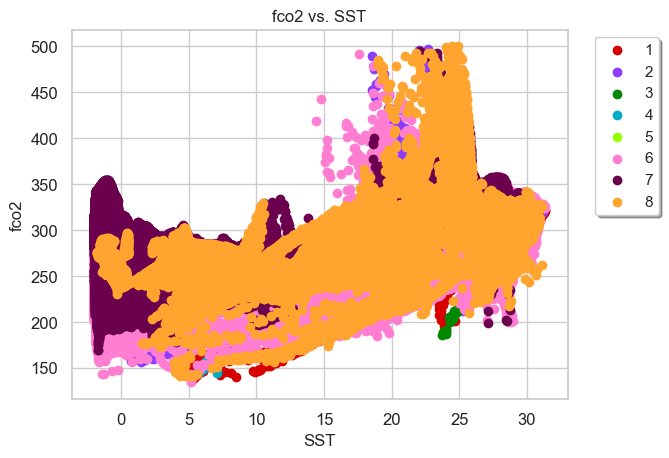

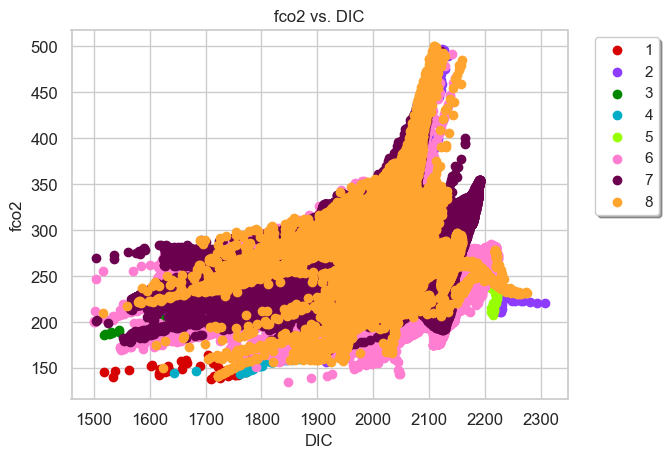

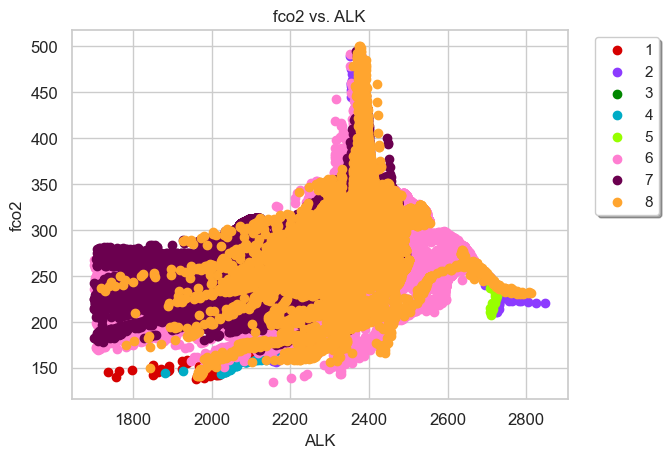

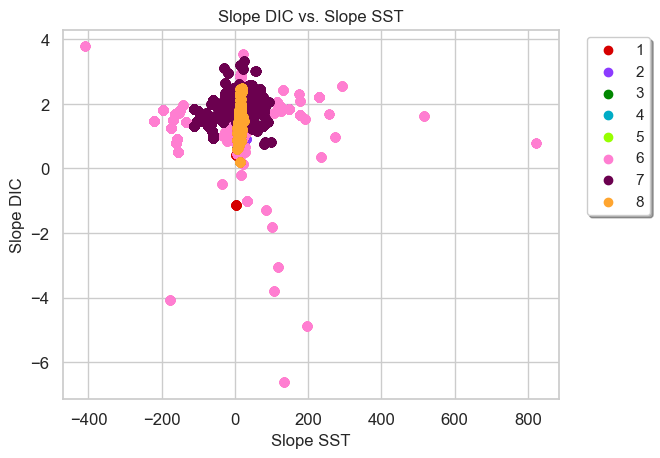

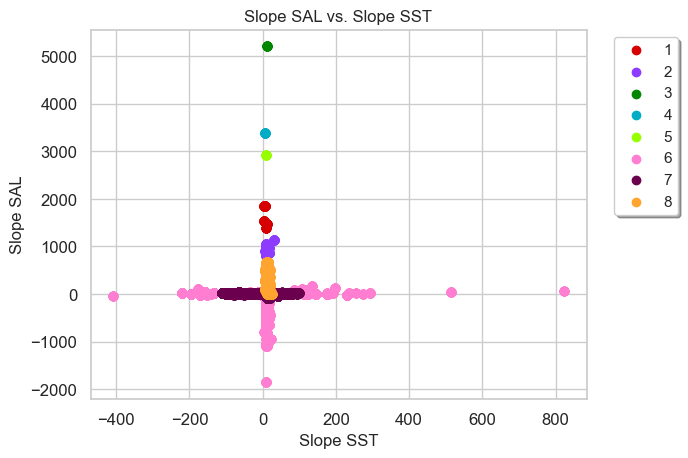

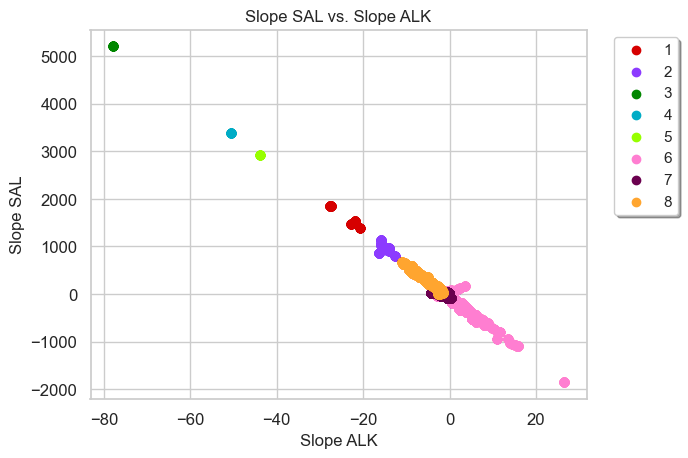

In [408]:


tot_clusters = regimes_df['cluster'].unique()
tot_clusters = np.sort(tot_clusters)
num = len(regimes_df['cluster'].unique())
# Non repeating random colors
colors = sns.color_palette(cc.glasbey, n_colors=num)

for t, c in zip(tot_clusters, colors):
    if (t == 1 or t == 2 or t == 3 or t ==4):
        continue
    df = regimes_df.loc[regimes_df['cluster'] == t]
    x = df['sst'].values
    y = df['fco2'].values
    plt.scatter(x, y, color=c, label = f'{t}')

plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
plt.title(f"fco2 vs. SST")
plt.xlabel("SST")
plt.ylabel("fco2")
plt.show()

for t, c in zip(tot_clusters, colors):
    df = regimes_df.loc[regimes_df['cluster'] == t]
    x = df['dic'].values
    y = df['fco2'].values
    plt.scatter(x, y, color=c, label = f'{t}')

plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
plt.title(f"fco2 vs. DIC")
plt.xlabel("DIC")
plt.ylabel("fco2")
plt.show()


for t, c in zip(tot_clusters, colors):
    df = regimes_df.loc[regimes_df['cluster'] == t]
    x = df['alk'].values
    y = df['fco2'].values
    plt.scatter(x, y, color=c, label = f'{t}')

plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
plt.title(f"fco2 vs. ALK")
plt.xlabel("ALK")
plt.ylabel("fco2")
plt.show()

for t, c in zip(tot_clusters, colors):
    df = regimes_df.loc[regimes_df['cluster'] == t]
    x = df['slope_sst'].values
    y = df['slope_dic'].values
    plt.scatter(x, y, color=c, label = f'{t}')

plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
plt.title(f"Slope DIC vs. Slope SST")
plt.xlabel("Slope SST")
plt.ylabel("Slope DIC")
plt.show()

for t, c in zip(tot_clusters, colors):
    df = regimes_df.loc[regimes_df['cluster'] == t]
    x = df['slope_sst'].values
    y = df['slope_sal'].values
    plt.scatter(x, y, color=c, label = f'{t}')
plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
plt.title(f"Slope SAL vs. Slope SST")
plt.xlabel("Slope SST")
plt.ylabel("Slope SAL")
plt.show()

for t, c in zip(tot_clusters, colors):
    df = regimes_df.loc[regimes_df['cluster'] == t]
    x = df['slope_alk'].values
    y = df['slope_sal'].values
    plt.scatter(x, y, color=c, label = f'{t}')
plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
plt.title(f"Slope SAL vs. Slope ALK")
plt.xlabel("Slope ALK")
plt.ylabel("Slope SAL")
plt.show()

# for t, c in zip(tot_clusters, colors):
#     df = regimes_df.loc[regimes_df['cluster'] == t]
#     x = df['slope_sst'].values
#     y = df['fco2'].values
#     plt.scatter(x, y, color=c, label = f'{t}')

# plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
# plt.title(f"fco2 vs. Slope SST")
# plt.xlabel("Slope SST")
# plt.ylabel("fco2")
# plt.show()

# for t, c in zip(tot_clusters, colors):
#     df = regimes_df.loc[regimes_df['cluster'] == t]
#     x = df['slope_dic'].values
#     y = df['fco2'].values
#     plt.scatter(x, y, color=c, label = f'{t}')

# plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
# plt.title(f"fco2 vs. Slope DIC")
# plt.xlabel("Slope DIC")
# plt.ylabel("fco2")
# plt.show()

# for t, c in zip(tot_clusters, colors):
#     df = regimes_df.loc[regimes_df['cluster'] == t]
#     x = df['slope_alk'].values
#     y = df['fco2'].values
#     plt.scatter(x, y, color=c, label = f'{t}')

# plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
# plt.title(f"fco2 vs. Slope ALK")
# plt.xlabel("Slope ALK")
# plt.ylabel("fco2")
# plt.show()

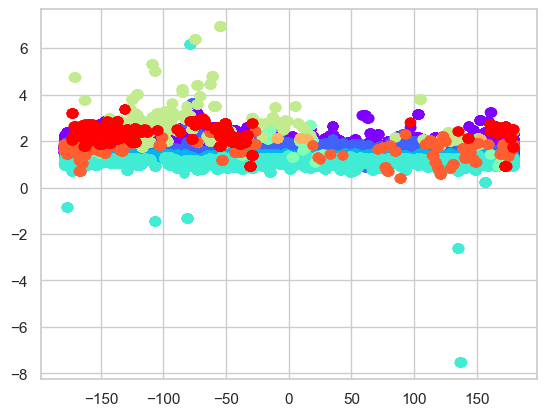

In [22]:
tot_clusters = regimes_df['cluster'].unique()
colors = cm.rainbow(np.linspace(0, 1, len(tot_clusters)))

for t, c in zip(tot_clusters, colors):
    df = regimes_df.loc[regimes_df['cluster'] == t]
    x = df['nav_lon'].values
    y = df['slope_dic'].values
    plt.scatter(x, y, color=c)

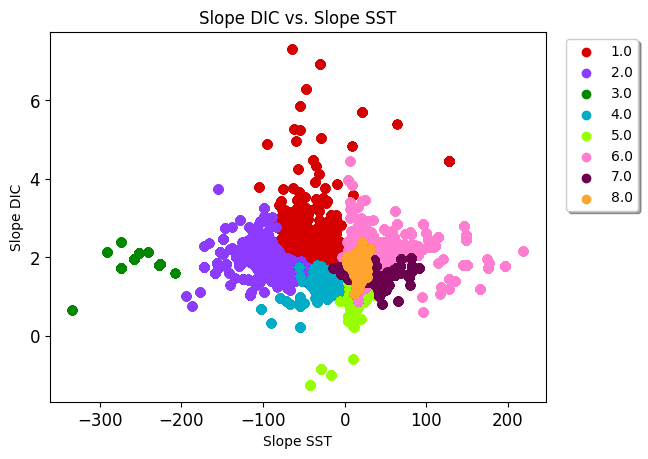

In [133]:
tot_clusters = np.sort(regimes_df['cluster'].unique())
# colors = cm.rainbow(np.linspace(0, 1, len(tot_clusters)))

for t, c in zip(tot_clusters, cluster_colors):
    df = regimes_df.loc[regimes_df['cluster'] == t]
    x = df['slope_sst'].values
    y = df['slope_dicp'].values
    plt.scatter(x, y, color=c, label = f'{t}')

plt.legend(loc='best', bbox_to_anchor=(1.2, 1),fancybox=True, shadow=True, ncol=1)
plt.title(f"Slope DICP vs. Slope SST")
plt.xlabel("Slope SST")
plt.ylabel("Slope DIC")
plt.show()

## Combine all years

In [ ]:
plt.style.use('ggplot') #Change/Remove This If you Want

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train', linewidth = 4.0)
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv', linewidth = 1.0)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

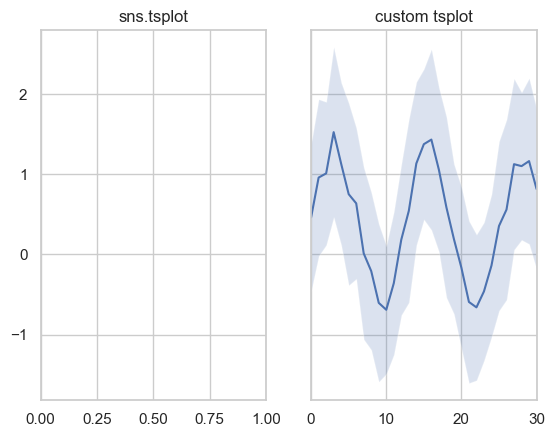

In [79]:
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt
import seaborn as sns

x = np.linspace(0, 15, 31)
data = np.sin(x) + np.random.rand(10, 31) + np.random.randn(10, 1)


fig, (ax,ax2) = plt.subplots(ncols=2, sharey=True)
# ax = sns.tsplot(data=data,ax=ax, ci="sd")

def tsplot(ax, data,**kw):
    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

tsplot(ax2, data)

ax.set_title("sns.tsplot")
ax2.set_title("custom tsplot")

plt.show()

# Tracking

In [99]:
# years = range(1990, 2019)
# m = 'jan'

# for y in years:
#     df = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{y}_{m}.pkl")
#     avg_df = df.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].mean()

#     print(f"Mean slopes of {y} in {m}")
#     print(avg_df.round(3).to_string(index=False))
#     print()

## FN

In [100]:
def calculate_distance_similarity(cluster_a, cluster_b):
    _dist_ = np.linalg.norm(a - b)
    _sim_ = 1/(1+_dist_)
    return _sim_

def calculate_frobenius_norm(cluster_a, cluster_b):
    _dist_ = np.linalg.norm(a - b)
    return _dist_

### Distribution plot over the years

In [1536]:
yrs = range(2009, 2018)
month = 'jan'

median_sst = []
std_sst = []
mean_sst = []
regimes_to_track = [5,3,4,6,10,8,4,7,5]

for y, r in zip(yrs, regimes_to_track):
    cluster_df_a = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{y}_{month}_025.pkl")
    df_a_med = cluster_df_a.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].median()
    df_a_mean = cluster_df_a.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].mean()
    df_a_std = cluster_df_a.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].std()
    
    mean = df_a_mean.loc[df_a_mean['cluster'] == r]
    median = df_a_med.loc[df_a_med['cluster'] == r]
    std = df_a_std.loc[df_a_std['cluster'] == r]
    
    mean_sst.append(mean.values[0][2])
    median_sst.append(median.values[0][2])
    std_sst.append(std.values[0][2])
    


Text(0.5, 0, 'Years')

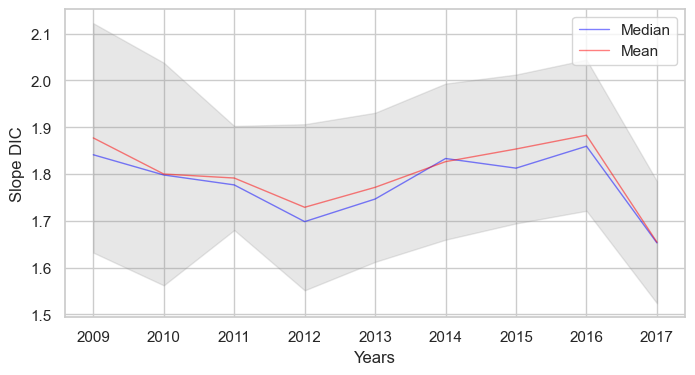

In [1537]:
# plt.style.use('ggplot') #Change/Remove This If you Want

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(yrs, median_sst, alpha=0.5, color='blue', label='Median', linewidth = 1.0)
ax.plot(yrs, mean_sst, alpha=0.5, color='red', label='Mean', linewidth = 1.0)
ax.fill_between(yrs, np.asarray(mean_sst) - np.asarray(std_sst), np.asarray(mean_sst) + np.asarray(std_sst),
                color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylabel("Slope DIC")
ax.set_xlabel("Years")

### Between 2 years

In [155]:
year1 = 2012
year2 = 2013
month = 'jan'

In [156]:
cluster_df_a = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{year1}_{month}_025.pkl")
cluster_df_b = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{year2}_{month}_025.pkl")

In [157]:
df_a_mean = cluster_df_a.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].mean()
df_a_med = cluster_df_a.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].median()
df_a_std = cluster_df_a.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].std()
df_a_count = cluster_df_a.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].count()

df_b_mean = cluster_df_b.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].mean()
df_b_med = cluster_df_b.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].median()
df_b_std = cluster_df_b.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].std()
df_b_count = cluster_df_b.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].count()

In [158]:
# print(f"Median values of the slopes in {year1}")
# round(df_a_med, 2)

In [159]:
data_dist_list = []
data_sim_list = []

clust_num_a = len(cluster_df_a['cluster'].unique())
clust_num_b = len(cluster_df_b['cluster'].unique())

for i in range(1,clust_num_a + 1):
#     i_arr1 = df_a_med.loc[df_a_med['cluster'] == i][['slope_sst', 'slope_dic', 'slope_alk']].values
    i_arr2 = df_a_mean.loc[df_a_mean['cluster'] == i][['slope_sst', 'slope_dic', 'slope_alk']].values
    i_arr3 = df_a_std.loc[df_a_std['cluster'] == i][['slope_sst', 'slope_dic', 'slope_alk']].values
#     i_arr4 = df_a_count.loc[df_a_count['cluster_labels'] == i][['slope_sst', 'slope_dic', 'slope_alk']].values
    
    a = np.concatenate((i_arr2, i_arr3), axis=0)

    for j in range(1,clust_num_b + 1):
#         print(j)
#         j_arr1 = df_b_med.loc[df_b_med['cluster'] == j][['slope_sst', 'slope_dic', 'slope_alk']].values
#         print(j_arr1)
        j_arr2 = df_b_mean.loc[df_b_mean['cluster'] == j][['slope_sst', 'slope_dic', 'slope_alk']].values
        j_arr3 = df_b_std.loc[df_b_std['cluster'] == j][['slope_sst', 'slope_dic', 'slope_alk']].values
#         j_arr4 = df_b_count.loc[df_b_count['cluster_labels'] == j][['slope_sst', 'slope_dic', 'slope_alk']].values
    
        b = np.concatenate((j_arr2, j_arr3), axis=0)
        _dist_ = calculate_frobenius_norm(a, b)
        _sim_ = calculate_distance_similarity(a,b)
        data_dist_list.append([i, j, _dist_, _sim_])
# data_list

#### CUR Prob

In [160]:
def get_CUR_prob_distribution(cluster_to_track, fn_dataframe):
    pass

In [161]:
new_df = pd.DataFrame(columns=[f'{year1} CUR Labels', f'{year2} CUR Labels', 'FN', 'sim'], data=data_dist_list)
df_fn = new_df.pivot(f'{year1} CUR Labels', f'{year2} CUR Labels', 'FN')
df_sim = new_df.pivot(f'{year1} CUR Labels', f'{year2} CUR Labels', 'sim')

In [162]:
df_fn = df_fn.round(2)
df_fn

2013 CUR Labels      1       2      3       4       5       6       7   \
2012 CUR Labels                                                          
1                  1.80    2.65  59.38  156.56  130.46  250.87   15.90   
2                  3.02    0.88  59.27  155.40  129.81  250.15   18.36   
3                155.10  157.45  97.61   57.42   34.14  100.18  165.07   
4                 81.82   83.78  27.62   77.31   46.92  167.38   93.95   
5                 60.80   62.72  93.12  197.76  164.02  281.47   45.14   
6                  3.68    4.10  60.88  158.46  132.20  252.64   13.96   
7                 35.91   38.20  22.16  121.38   93.08  213.57   47.89   

2013 CUR Labels      8       9       10      11  
2012 CUR Labels                                  
1                114.48   75.91    8.97    0.81  
2                116.01   77.53   11.19    2.24  
3                262.95  225.33  152.55  157.40  
4                194.90  156.34   80.64   84.00  
5                 84.94   53.34   54.38   60.77  
6                112.46   73.88    8.82    2.20  
7                149.19  110.52   34.46   38.18

<AxesSubplot: xlabel='2013 CUR Labels', ylabel='2012 CUR Labels'>

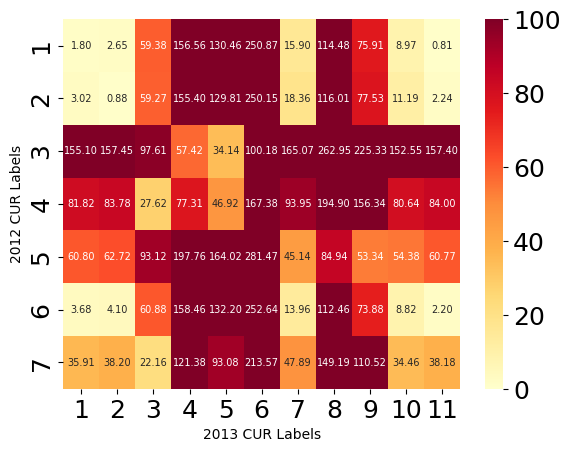

In [166]:
sns.heatmap(df_fn, annot=True, fmt=".2f", cmap="YlOrRd", vmin=0, vmax=100, annot_kws={"fontsize":7})

In [2337]:
cluster_to_track = 5
track_df = new_df.loc[new_df[f'{year1} CUR Labels'] == cluster_to_track]
track_df

2017 CUR Labels  2016 CUR Labels          FN       sim
32                5                1    0.955850  0.511287
33                5                2    1.930140  0.341281
34                5                3  124.302100  0.007981
35                5                4   54.606605  0.017983
36                5                5   38.958481  0.025026
37                5                6    5.523792  0.153285
38                5                7    2.259608  0.306785
39                5                8    0.136423  0.879954

In [2338]:
track_df_sorted = track_df.sort_values(by=['sim'], ascending=False)
sims_sorted = track_df_sorted['sim'].values
sims_sorted_prob = sims_sorted/sims_sorted.sum()
track_df_sorted['prob'] = sims_sorted_prob * 100
track_df_sorted

2017 CUR Labels  2016 CUR Labels          FN       sim       prob
39                5                8    0.136423  0.879954  39.220943
32                5                1    0.955850  0.511287  22.788856
33                5                2    1.930140  0.341281  15.211418
38                5                7    2.259608  0.306785  13.673910
37                5                6    5.523792  0.153285   6.832160
36                5                5   38.958481  0.025026   1.115448
35                5                4   54.606605  0.017983   0.801552
34                5                3  124.302100  0.007981   0.355713

In [2339]:
cur_prob_dict = {}

for idx, row in track_df_sorted.iterrows():
    cur_prob_dict[row[f'{year2} CUR Labels']] = round(row['prob'],2)

In [2340]:
cur_prob_dict

{8.0: 39.22,
 1.0: 22.79,
 2.0: 15.21,
 7.0: 13.67,
 6.0: 6.83,
 5.0: 1.12,
 4.0: 0.8,
 3.0: 0.36}

#### Pairwise comparison

In [115]:
df_fn = df_fn.round(2)
df_fn

2010 CUR Labels      1      2      3      4       5      6       7
2009 CUR Labels                                                   
1                96.84  94.09  94.18  97.31   17.18  25.34   11.84
2                86.97  84.06  81.76  85.54   17.60  12.93   22.59
3                 2.15   1.87  17.28  12.92   77.87  74.04   87.72
4                 3.38   0.74  14.77  10.64   77.30  73.05   87.30
5                20.13  18.48   3.00   8.45   78.85  71.69   89.64
6                 0.27   2.88  16.96  12.10   79.76  75.74   89.63
7                41.00  41.46  31.43  31.47  108.01  99.79  118.95

In [418]:
sim_matrix = df_sim.values

In [419]:
sim_matrix_sorted = -np.sort(-sim_matrix)
sim_matrix_sorted

array([[0.23442592, 0.1180747 , 0.08292551, 0.01485481, 0.01463271,
        0.01423123, 0.01367246],
       [0.39422436, 0.13515219, 0.07992618, 0.01476855, 0.01455121,
        0.01415726, 0.01360758],
       [0.63846716, 0.37637626, 0.21375014, 0.13086689, 0.01794969,
        0.01590305, 0.01474876],
       [0.6634588 , 0.62701497, 0.27679987, 0.15214391, 0.01762013,
        0.01565071, 0.0145279 ],
       [0.66308176, 0.28862015, 0.28387536, 0.21670464, 0.01674609,
        0.01497939, 0.01393652],
       [0.89628878, 0.46743922, 0.33369534, 0.16777446, 0.01745828,
        0.01553202, 0.0144211 ],
       [0.03808196, 0.03435418, 0.0322162 , 0.03117836, 0.01145238,
        0.01060486, 0.01006582]])

In [420]:
sim_matrix_sorted_prob = sim_matrix_sorted/sim_matrix_sorted.sum(axis=1)[:,None]
sim_matrix_sorted_prob*100

array([[47.56852042, 23.95912095, 16.82682446,  3.01426202,  2.96919554,
         2.88773   ,  2.77434661],
       [59.1584418 , 20.28132611, 11.9939525 ,  2.21621144,  2.1835969 ,
         2.12447858,  2.04199268],
       [45.3436836 , 26.73009198, 15.18045005,  9.29411432,  1.27478008,
         1.12942856,  1.04745141],
       [37.54259208, 35.48037524, 15.66304425,  8.60924107,  0.99705545,
         0.88561353,  0.82207838],
       [44.26612728, 19.26775398, 18.9510003 , 14.46680624,  1.11793842,
         0.99999698,  0.9303768 ],
       [46.86209713, 24.43987101, 17.44712621,  8.7720198 ,  0.91279898,
         0.81208559,  0.75400126],
       [22.67407266, 20.45454791, 19.18158879, 18.56365703,  6.81876943,
         6.31415534,  5.99320884]])

In [153]:
sim_matrix_sorted_prob * 100

array([[24.7489428 , 10.60753722, 10.43147268,  9.99363285,  9.4571801 ,
         9.40560727,  9.32977722,  6.14372816,  5.15454094,  4.72758074],
       [22.84913395, 10.91245002, 10.70583845, 10.12562496,  9.58045947,
         9.53149353,  9.46609941,  6.40783236,  5.42966697,  4.99140088],
       [35.41414073, 28.44536937, 19.10971389, 11.20226431,  2.63504574,
         1.47676117,  0.5872535 ,  0.42981887,  0.36105695,  0.33857548],
       [25.63281166, 23.58595673, 23.48026143, 19.98657267,  3.46903688,
         1.78739224,  0.70342774,  0.51474779,  0.43332063,  0.40647223],
       [24.08999148, 20.82818108, 14.93462199, 14.40634284, 14.27431316,
         5.4945979 ,  2.03772327,  1.48388488,  1.26363456,  1.18670883],
       [41.66779515, 30.68945823, 18.11544541,  6.10501334,  1.55787927,
         0.85283236,  0.34503538,  0.25345871,  0.21311102,  0.19997113],
       [19.21292005, 16.27811007, 16.26077571, 15.54205787, 15.4462445 ,
         7.05513176,  3.34504182,  2.55349194

In [ ]:
3 -> 1 2 4 3 5 7 6

sum (1 2 4 3 5 7 6)




In [109]:
prob_df = new_df_pivot.div(new_df_pivot.sum(axis=1), axis=0)
prob_df

2010 CUR Labels         1         2         3         4         5         6  \
2009 CUR Labels                                                               
1                0.233136  0.226651  0.213478  0.228036  0.043361  0.023388   
2                0.227062  0.220873  0.206730  0.220762  0.052407  0.028943   
3                0.007090  0.007512  0.062436  0.046027  0.265517  0.306214   
4                0.012863  0.003103  0.053674  0.036876  0.270174  0.311552   
5                0.074172  0.065030  0.010193  0.034127  0.244922  0.282008   
6                0.001068  0.009982  0.062296  0.043775  0.267925  0.307815   
7                0.084667  0.083899  0.068210  0.063777  0.216492  0.238112   

2010 CUR Labels         7  
2009 CUR Labels            
1                0.031950  
2                0.043223  
3                0.305203  
4                0.311758  
5                0.289548  
6                0.307141  
7                0.244843

In [110]:
percent_df = prob_df.select_dtypes(include=[np.number])*100
percent_df

2010 CUR Labels          1          2          3          4          5  \
2009 CUR Labels                                                          
1                23.313642  22.665084  21.347779  22.803592   4.336127   
2                22.706154  22.087282  20.673030  22.076196   5.240733   
3                 0.709044   0.751192   6.243617   4.602739  26.551678   
4                 1.286285   0.310264   5.367419   3.687645  27.017380   
5                 7.417208   6.502956   1.019280   3.412704  24.492231   
6                 0.106752   0.998164   6.229581   4.377452  26.792461   
7                 8.466668   8.389910   6.820999   6.377694  21.649230   

2010 CUR Labels          6          7  
2009 CUR Labels                        
1                 2.338761   3.195016  
2                 2.894284   4.322322  
3                30.621417  30.520313  
4                31.155213  31.175795  
5                28.200844  28.954778  
6                30.781492  30.714098  
7                23.811209  24.484290

<AxesSubplot: xlabel='2010 CUR Labels', ylabel='2009 CUR Labels'>

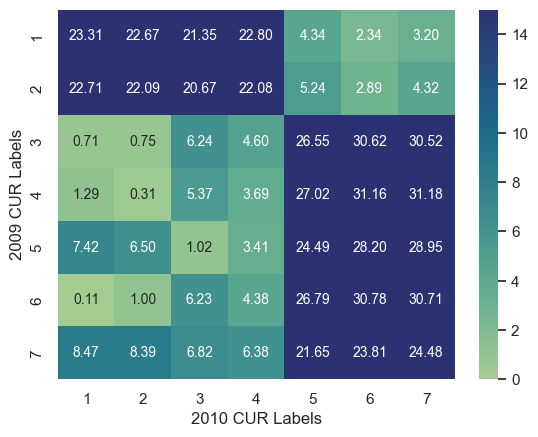

In [111]:
sns.heatmap(percent_df, annot=True, fmt=".2f", cmap="crest", vmin=0, vmax=15, annot_kws={"fontsize":10})

### Among all clusters

In [82]:
years = range(2009, 2011)
month = 'jan'

In [83]:
regime_dict = {}
for yr in years:
    regimes = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{yr}_{month}_025.pkl")
#     print(regimes)
    regimes['cluster'] = f'{yr}_' + regimes['cluster'].astype(int).astype(str)
    
    regimes_mean = regimes.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].mean()
    regimes_median = regimes.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].median()
    regimes_std = regimes.groupby(['cluster'], as_index=False)['slope_sst', 'slope_dic', 'slope_alk'].std()

    regime_dict[yr] = [regimes, regimes_median, regimes_std, regimes_mean]

In [85]:
regime_dict[2010][3]

cluster  slope_sst  slope_dic  slope_alk
0  2010_1  12.367134   1.488594  -1.090156
1  2010_2  10.740830   1.181757  -0.795696
2  2010_3  17.895214   1.799979  -1.609638
3  2010_4  18.721922   2.260179  -2.254248
4  2010_5 -56.232572   2.096594  -1.821025
5  2010_6 -45.263576   7.283076  -6.935324
6  2010_7 -67.313480   4.367115  -4.019781

In [88]:
%%time

data_dist_list = []

for regime_key_a, regime_val_a in regime_dict.items():
    
    clust_num_a = len(regime_val_a[0]['cluster'].unique())
    tot_clust_a = regime_val_a[0]['cluster'].unique()
    
    for i in tot_clust_a:
        i_arr_a_median = regime_val_a[1].loc[regime_val_a[1]['cluster'] == i][['slope_sst', 'slope_dic', 'slope_alk']].values
        i_arr_a_std = regime_val_a[2].loc[regime_val_a[2]['cluster'] == i][['slope_sst', 'slope_dic', 'slope_alk']].values
        a = np.concatenate((i_arr_a_median, i_arr_a_std), axis=0)
        
        for regime_key_b, regime_val_b in regime_dict.items():
            clust_num_b = len(regime_val_b[0]['cluster'].unique())
            tot_clust_b = regime_val_b[0]['cluster'].unique()
            
            for j in tot_clust_b:
                j_arr_b_median = regime_val_b[1].loc[regime_val_b[1]['cluster'] == j][['slope_sst', 'slope_dic', 'slope_alk']].values
                j_arr_b_std = regime_val_b[2].loc[regime_val_b[2]['cluster'] == j][['slope_sst', 'slope_dic', 'slope_alk']].values
                b = np.concatenate((j_arr_b_median, j_arr_b_std), axis=0)
                
                fn = calculate_frobenius_norm(cluster_a = a, cluster_b = b)
#                 fn = calculate_distance_similarity(cluster_a = a, cluster_b = b)
                
                data_dist_list.append([i, j, fn])

CPU times: user 2.08 s, sys: 33.8 ms, total: 2.12 s
Wall time: 2.12 s


In [89]:
new_df_fn = pd.DataFrame(columns=['CUR Labels', 'CUR Labels (repeat)', 'val'], data=data_dist_list)
new_df_fn

CUR Labels CUR Labels (repeat)        val
0       2009_6              2009_6   0.000000
1       2009_6              2009_5  18.752490
2       2009_6              2009_1  85.122596
3       2009_6              2009_4   2.975413
4       2009_6              2009_7  34.821284
..         ...                 ...        ...
191     2010_7              2010_1  79.759019
192     2010_7              2010_4  79.255934
193     2010_7              2010_2  77.593577
194     2010_7              2010_6   9.845540
195     2010_7              2010_7   0.000000

[196 rows x 3 columns]

In [570]:
unique_clusters = new_df_fn['CUR Labels'].unique()

table_list = []

for uc in unique_clusters:
    row_list = []
    uc_yr = int(uc.split('_')[0])
    uc_num = int(uc.split('_')[1])
    uc_df = new_df_fn.loc[new_df_fn['CUR Labels'] == uc]
#     print(uc_yr)
    row_list.append(uc_yr)
    for _yr in range(2009, 2019):
        fn_df = uc_df.loc[uc_df['CUR Labels (repeat)'].str.contains(f'{_yr}')]
        min_fn_df = fn_df[fn_df.val == fn_df.val.min()]
        min_fn_curs = min_fn_df['CUR Labels (repeat)'].values
        sim_clust = [similar_cluster.split('_')[1] for similar_cluster in min_fn_curs]
        row_list.append(sim_clust)
    table_list.append(row_list)

In [571]:
table_columns = ['year']
for n in range(2009, 2019):
    table_columns.append(str(n))
print(table_columns)
sim_table = pd.DataFrame(columns=table_columns, data=table_list)
sim_table.head(10)

['year', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']


year 2009 2010 2011 2012  2013  2014 2015 2016 2017 2018
0  2009  [6]  [1]  [5]  [2]  [11]   [7]  [2]  [8]  [2]  [6]
1  2009  [5]  [3]  [3]  [6]   [7]   [8]  [4]  [7]  [4]  [8]
2  2009  [1]  [7]  [8]  [4]   [3]   [5]  [5]  [4]  [7]  [2]
3  2009  [4]  [2]  [2]  [1]   [1]   [1]  [2]  [1]  [1]  [5]
4  2009  [7]  [3]  [3]  [5]   [7]  [11]  [3]  [7]  [3]  [7]
5  2009  [3]  [2]  [2]  [2]   [2]   [2]  [1]  [2]  [2]  [4]
6  2009  [2]  [6]  [8]  [4]   [3]   [3]  [5]  [4]  [6]  [1]
7  2010  [5]  [3]  [1]  [6]   [7]   [8]  [4]  [7]  [4]  [8]
8  2010  [1]  [5]  [8]  [4]   [3]   [5]  [5]  [4]  [6]  [2]
9  2010  [6]  [1]  [5]  [2]   [2]   [7]  [1]  [8]  [2]  [6]

In [573]:
sim_table.to_csv(f"../Clustering_Output/FN_table_2009_2018_ORCA_025.csv")

In [572]:
new_df_pivot = new_df_fn.pivot('CUR Labels', 'CUR Labels (repeat)', 'val').round(2)
new_df_pivot

CUR Labels (repeat)  2009_1  2009_2  2009_3  2009_4  2009_5  2009_6  2009_7  \
CUR Labels                                                                    
2009_1                 0.00   17.83   94.82   94.16   94.69   96.70  123.31   
2009_2                17.83    0.00   85.06   84.01   81.84   86.79  109.32   
2009_3                94.82   85.06    0.00    2.54   20.26    2.09   42.46   
2009_4                94.16   84.01    2.54    0.00   17.76    3.16   40.85   
2009_5                94.69   81.84   20.26   17.76    0.00   19.90   29.85   
...                     ...     ...     ...     ...     ...     ...     ...   
2018_4                95.65   85.92    0.88    3.09   20.61    1.48   42.22   
2018_5                95.56   85.25    3.39    1.64   17.09    2.89   39.36   
2018_6                96.52   86.76    1.76    3.57   20.72    0.94   41.73   
2018_7               100.46   85.58   37.65   35.19   17.51   37.12   25.02   
2018_8                93.24   82.65    5.40    2.88   15.05    5.70   39.39   

CUR Labels (repeat)  2010_1  2010_2  2010_3  ...  2017_6  2017_7  2018_1  \
CUR Labels                                   ...                           
2009_1                96.84   94.09   94.18  ...   52.96   52.58   58.55   
2009_2                86.97   84.06   81.76  ...   46.14   68.36   45.88   
2009_3                 2.15    1.87   17.28  ...   42.61  145.25   40.56   
2009_4                 3.38    0.74   14.77  ...   42.34  144.89   39.12   
2009_5                20.13   18.48    3.00  ...   47.59  146.92   36.22   
...                     ...     ...     ...  ...     ...     ...     ...   
2018_4                 1.45    2.51   17.65  ...   43.40  146.04   41.42   
2018_5                 3.14    2.15   14.14  ...   43.85  146.38   40.19   
2018_6                 0.77    3.12   17.77  ...   44.27  146.91   42.22   
2018_7                37.34   35.91   20.50  ...   59.42  153.04   43.30   
2018_8                 5.95    3.56   12.06  ...   41.92  144.28   37.40   

CUR Labels (repeat)  2018_2  2018_3  2018_4  2018_5  2018_6  2018_7  2018_8  
CUR Labels                                                                   
2009_1                36.55   80.30   95.65   95.56   96.52  100.46   93.24  
2009_2                48.45   97.97   85.92   85.25   86.76   85.58   82.65  
2009_3                89.72  160.28    0.88    3.39    1.76   37.65    5.40  
2009_4                90.06  160.56    3.09    1.64    3.57   35.19    2.88  
2009_5                97.30  166.75   20.61   17.09   20.72   17.51   15.05  
...                     ...     ...     ...     ...     ...     ...     ...  
2018_4                90.39  160.96    0.00    3.56    0.91   37.94    5.93  
2018_5                91.66  162.16    3.56    0.00    3.64   34.40    3.01  
2018_6                91.21  161.79    0.91    3.64    0.00   37.97    6.31  
2018_7               108.57  176.29   37.94   34.40   37.97    0.00   32.54  
2018_8                90.24  160.65    5.93    3.01    6.31   32.54    0.00  

[83 rows x 83 columns]

In [30]:
new_df_pivot.to_csv(f"../Clustering_Output/tracking_regimes_dist_similarity_1990_2018.csv")

<AxesSubplot: xlabel='CUR Labels (repeat)', ylabel='CUR Labels'>

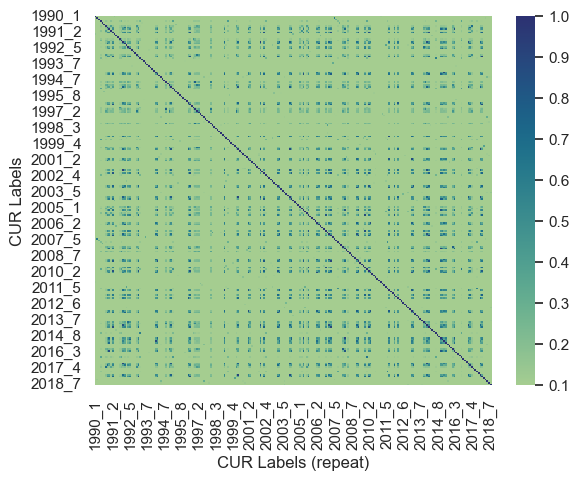

In [39]:
sns.heatmap(new_df_pivot, annot=False, fmt=".2f", cmap="crest", vmin=0.1, vmax=1.0, annot_kws={"fontsize":10})

## Spatial Info
- Do Jaccard similarity on the contained coordinates

Jaccard Similarity value ranges from 0 to 1. The higher the number, the more similar are the datasets with each other.

In [4]:
def jaccard_similarity(list1, list2):
    s1, s2 = set(list1), set(list2)
    return len(s1 & s2) / len(s1 | s2)

In [5]:
def monic_similarity(list1, list2):
    s1, s2 = set(list1), set(list2)
    return len(s1 & s2) / len(s1)

In [6]:
def cond_prob(list1, list2):
    s1, s2 = set(list1), set(list2)
    nr = len(s1 & s2) / len(s1 | s2)
    dr = len(s1)/len(s1 | s2)
    return nr/dr

In [7]:
yr = 2009
month = 'jan'
coord_df = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{yr}_{month}.pkl")
coord_df

nav_lat  nav_lon       sst          dic          alk        fco2  \
0        -76.90  -179.75  0.476905  2001.856567  2200.095215  211.594955   
1        -76.90  -179.25  0.466091  2001.182251  2199.283691  211.315002   
2        -76.90  -178.75  0.449750  2000.390137  2198.186035  211.096268   
3        -76.90  -178.25  0.418278  2000.000610  2197.276855  211.036835   
136      -76.78  -179.75  0.373758  2020.622681  2218.269287  216.302261   
...         ...      ...       ...          ...          ...         ...   
222120    86.64   176.03 -1.846606  2046.154541  2198.942627  259.336700   
222212    86.86   176.84 -1.849208  2050.223389  2203.699707  259.376038   
222304    87.08   177.77 -1.851454  2054.230225  2208.341797  259.482758   
222544    87.77   176.27 -1.854196  2064.930420  2220.667236  259.835388   
222610    87.98   177.57 -1.853418  2068.256592  2224.268311  260.320953   

        cluster  slope_sst  slope_dic  slope_alk  slope_sst_std  \
0           1.0  12.936209   1.492673  -1.205869       0.136381   
1           1.0  12.936209   1.492673  -1.205869       0.136381   
2           1.0  12.936209   1.492673  -1.205869       0.136381   
3           1.0  12.936209   1.492673  -1.205869       0.136381   
136         1.0  12.936209   1.492673  -1.205869       0.136381   
...         ...        ...        ...        ...            ...   
222120      6.0 -19.796690   2.085621  -1.786596      -1.210988   
222212      6.0 -19.796690   2.085621  -1.786596      -1.210988   
222304      6.0 -19.796690   2.085621  -1.786596      -1.210988   
222544      6.0 -19.796690   2.085621  -1.786596      -1.210988   
222610      6.0 -19.796690   2.085621  -1.786596      -1.210988   

        slope_dic_std  slope_alk_std        BIC  delta_var  delta_dist  
0            0.188573      -0.383083  69.461123        0.4        26.0  
1            0.188573      -0.383083  69.461123        0.4        26.0  
2            0.188573      -0.383083  69.461123        0.4        26.0  
3            0.188573      -0.383083  69.461123        0.4        26.0  
136          0.188573      -0.383083  69.461123        0.4        26.0  
...               ...            ...        ...        ...         ...  
222120       1.789510      -1.849539  69.461123        0.4        26.0  
222212       1.789510      -1.849539  69.461123        0.4        26.0  
222304       1.789510      -1.849539  69.461123        0.4        26.0  
222544       1.789510      -1.849539  69.461123        0.4        26.0  
222610       1.789510      -1.849539  69.461123        0.4        26.0  

[210026 rows x 16 columns]

In [55]:
l1 = [(1,1), (2,2), (3,1), (3,3)]
l2 = [(3,3), (1,5)]

jaccard_similarity(l1, l2)

0.2

In [56]:
d = coord_df.loc[coord_df['cluster'] == 2.0]
d['nav_lon']

44       -157.75
45       -157.25
46       -156.75
47       -156.25
180      -157.75
           ...  
219781     65.37
219966     65.12
220146     64.86
220330     64.58
220504     64.28
Name: nav_lon, Length: 75833, dtype: float64

In [57]:
coord_df['coordinates'] = list(zip(coord_df.nav_lat, coord_df.nav_lon))
coord_df

nav_lat  nav_lon       sst          dic          alk        fco2  \
0        -76.90  -179.75 -0.168381  2031.542358  2223.613281  219.640503   
1        -76.90  -179.25 -0.175677  2030.449097  2222.831299  218.888428   
2        -76.90  -178.75 -0.178512  2029.263062  2221.965820  218.151093   
3        -76.90  -178.25 -0.176559  2027.814331  2220.825928  217.408524   
136      -76.78  -179.75 -0.242978  2050.021484  2240.613525  225.571640   
...         ...      ...       ...          ...          ...         ...   
222415    86.94   164.78 -1.792998  1982.437866  2108.820801  285.706268   
222501    87.16   164.81 -1.787916  1979.852783  2105.207031  286.546082   
222585    87.38   164.86 -1.783465  1978.098877  2102.610352  287.303864   
222657    87.60   164.92 -1.780286  1976.687256  2100.422363  288.057098   
222727    87.82   165.01 -1.777940  1975.778564  2098.874268  288.747864   

        cluster  slope_sst  slope_dic  slope_alk  slope_sst_std  \
0           1.0  10.929827   1.572339  -1.332736       0.070897   
1           1.0  10.929827   1.572339  -1.332736       0.070897   
2           1.0  10.929827   1.572339  -1.332736       0.070897   
3           1.0  10.929827   1.572339  -1.332736       0.070897   
136         1.0  10.929827   1.572339  -1.332736       0.070897   
...         ...        ...        ...        ...            ...   
222415      3.0 -47.044052   1.739862  -1.540520      -2.628630   
222501      3.0 -47.044052   1.739862  -1.540520      -2.628630   
222585      3.0 -47.044052   1.739862  -1.540520      -2.628630   
222657      3.0 -47.044052   1.739862  -1.540520      -2.628630   
222727      3.0 -47.044052   1.739862  -1.540520      -2.628630   

        slope_dic_std  slope_alk_std        BIC  delta_var  delta_dist  \
0            0.409760      -0.672884  76.720407        0.4        24.0   
1            0.409760      -0.672884  76.720407        0.4        24.0   
2            0.409760      -0.672884  76.720407        0.4        24.0   
3            0.409760      -0.672884  76.720407        0.4        24.0   
136          0.409760      -0.672884  76.720407        0.4        24.0   
...               ...            ...        ...        ...         ...   
222415       0.857545      -1.172221  76.720407        0.4        24.0   
222501       0.857545      -1.172221  76.720407        0.4        24.0   
222585       0.857545      -1.172221  76.720407        0.4        24.0   
222657       0.857545      -1.172221  76.720407        0.4        24.0   
222727       0.857545      -1.172221  76.720407        0.4        24.0   

              coordinates  
0        (-76.9, -179.75)  
1        (-76.9, -179.25)  
2        (-76.9, -178.75)  
3        (-76.9, -178.25)  
136     (-76.78, -179.75)  
...                   ...  
222415    (86.94, 164.78)  
222501    (87.16, 164.81)  
222585    (87.38, 164.86)  
222657     (87.6, 164.92)  
222727    (87.82, 165.01)  

[210472 rows x 17 columns]

### Between two years

In [56]:
year1 = 2009
year2 = 2017
month = 'jan'

In [57]:
cluster_df_a = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{year1}_{month}_025.pkl")
cluster_df_b = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{year2}_{month}_025.pkl")

In [58]:
data_dist_list = []

clust_num_a = len(cluster_df_a['cluster'].unique())
clust_num_b = len(cluster_df_b['cluster'].unique())

for i in range(1,clust_num_a + 1):
    df_a = cluster_df_a.loc[cluster_df_a['cluster'] == i]
    coordinates_list_a = list(zip(df_a.nav_lat, df_a.nav_lon))
    
    for j in range(1,clust_num_b + 1):
        df_b = cluster_df_b.loc[cluster_df_b['cluster'] == j]
        coordinates_list_b = list(zip(df_b.nav_lat, df_b.nav_lon))

#         prob = cond_prob(coordinates_list_a, coordinates_list_b)*100
        js = jaccard_similarity(coordinates_list_a, coordinates_list_b) * 100
#         ms = monic_similarity(coordinates_list_a, coordinates_list_b) * 100
        data_dist_list.append([i, j, js])

In [59]:
new_df = pd.DataFrame(columns=[f'CUR Labels {year1}', f'CUR Labels {year2}', 'prob'], data=data_dist_list)
new_df_pivot = new_df.pivot(f'CUR Labels {year1}', f'CUR Labels {year2}', 'prob')
new_df_pivot

CUR Labels 2017          1          2         3          4          5  \
CUR Labels 2009                                                         
1                 0.452616   0.280051  5.404363   4.673925   1.353391   
2                 0.070662   0.029669  1.471479   0.138379   0.200969   
3                46.751156   1.692717  0.369966   0.319474   0.644231   
4                32.799233  29.414120  0.259571   0.528270   1.241414   
5                 1.086875   4.554466  9.364605  23.335660  26.971379   
6                 1.584670  30.719997  1.703267   4.787447  22.307841   
7                 0.111009   0.414576  1.660086   1.823822   0.683141   

CUR Labels 2017          6         7  
CUR Labels 2009                       
1                19.169914  6.151916  
2                 9.300903  3.022495  
3                 0.188101  0.000000  
4                 0.234938  0.259155  
5                 2.906270  1.430601  
6                 0.370695  0.365580  
7                 2.543228  1.831978

### Among all the years

In [36]:
years = range(2009, 2011)
month = 'jan'

In [37]:
regime_dict_coord = {}
for yr in years:
    regimes_coord = pd.read_pickle(f"../Clustering_Output/adaptive_hc_clusters_{yr}_{month}_025.pkl")
    regimes_coord['cluster'] = f'{yr}_' + regimes_coord['cluster'].astype(int).astype(str)
    regimes_coord['coordinates'] = list(zip(regimes_coord.nav_lat, regimes_coord.nav_lon))
    regime_dict_coord[yr] = regimes_coord

In [49]:
%%time

data_dist_list = []

for regime_key_a, regime_val_a in regime_dict_coord.items():
    
    clust_num_a = len(regime_val_a['cluster'].unique())
    tot_clust_a = regime_val_a['cluster'].unique()
    
    for i in tot_clust_a:
        df_a = regime_val_a.loc[regime_val_a['cluster'] == i]
        a = df_a['coordinates'].values.tolist()
        
        for regime_key_b, regime_val_b in regime_dict_coord.items():
            clust_num_b = len(regime_val_b['cluster'].unique())
            tot_clust_b = regime_val_b['cluster'].unique()
            
            for j in tot_clust_b:
                df_b = regime_val_b.loc[regime_val_b['cluster'] == j]
                b = df_b['coordinates'].values.tolist()
    
#                 jacc_sim = jaccard_similarity(a,b)
                prob = cond_prob(a, b)*100
                data_dist_list.append([i, j, prob])

CPU times: user 21.6 s, sys: 81.9 ms, total: 21.7 s
Wall time: 22 s


In [50]:
new_df_sim = pd.DataFrame(columns=['CUR Labels', 'CUR Labels (repeat)', 'sim'], data=data_dist_list)
new_df_sim

CUR Labels CUR Labels (repeat)    sim
0       2009_6              2009_6  100.0
1       2009_6              2009_5    0.0
2       2009_6              2009_1    0.0
3       2009_6              2009_4    0.0
4       2009_6              2009_7    0.0
..         ...                 ...    ...
191     2010_7              2010_1    0.0
192     2010_7              2010_4    0.0
193     2010_7              2010_2    0.0
194     2010_7              2010_6    0.0
195     2010_7              2010_7  100.0

[196 rows x 3 columns]

In [546]:
new_df_sim['CUR Labels'].unique()

array(['2009_6', '2009_5', '2009_1', '2009_4', '2009_7', '2009_3',
       '2009_2', '2010_3', '2010_5', '2010_1', '2010_4', '2010_2',
       '2010_6', '2010_7', '2011_5', '2011_2', '2011_1', '2011_3',
       '2011_8', '2011_4', '2011_9', '2011_10', '2011_7', '2011_6',
       '2012_1', '2012_6', '2012_2', '2012_3', '2012_7', '2012_5',
       '2012_4', '2013_10', '2013_11', '2013_7', '2013_2', '2013_9',
       '2013_8', '2013_3', '2013_5', '2013_1', '2013_6', '2013_4',
       '2014_7', '2014_9', '2014_8', '2014_2', '2014_1', '2014_5',
       '2014_4', '2014_3', '2014_6', '2014_10', '2014_11', '2015_4',
       '2015_2', '2015_1', '2015_5', '2015_3', '2015_6', '2015_7',
       '2016_7', '2016_8', '2016_1', '2016_2', '2016_6', '2016_3',
       '2016_4', '2016_5', '2017_5', '2017_2', '2017_4', '2017_1',
       '2017_6', '2017_3', '2017_7', '2018_8', '2018_6', '2018_5',
       '2018_4', '2018_7', '2018_3', '2018_2', '2018_1'], dtype=object)

In [558]:
unique_clusters = new_df_sim['CUR Labels'].unique()

table_list = []

for uc in unique_clusters:
    row_list = []
    uc_yr = int(uc.split('_')[0])
    uc_num = int(uc.split('_')[1])
    uc_df = new_df_sim.loc[new_df_sim['CUR Labels'] == uc]
#     print(uc_yr)
    row_list.append(uc_yr)
    for _yr in range(2009, 2019):
        jaccard_sim_df = uc_df.loc[uc_df['CUR Labels (repeat)'].str.contains(f'{_yr}')]
        max_jaccard_sim_df = jaccard_sim_df[jaccard_sim_df.sim == jaccard_sim_df.sim.max()]
        max_sim_curs = max_jaccard_sim_df['CUR Labels (repeat)'].values
        sim_clust = [similar_cluster.split('_')[1] for similar_cluster in max_sim_curs]
        row_list.append(sim_clust)
    table_list.append(row_list)

In [559]:
table_list

[[2009, ['6'], ['1'], ['5'], ['6'], ['11'], ['7'], ['2'], ['8'], ['2'], ['8']],
 [2009, ['5'], ['3'], ['4'], ['6'], ['10'], ['8'], ['4'], ['7'], ['5'], ['8']],
 [2009, ['1'], ['5'], ['8'], ['4'], ['3'], ['4'], ['5'], ['4'], ['6'], ['1']],
 [2009, ['4'], ['2'], ['2'], ['1'], ['2'], ['2'], ['1'], ['1'], ['1'], ['4']],
 [2009, ['7'], ['5'], ['10'], ['3'], ['6'], ['9'], ['5'], ['3'], ['6'], ['7']],
 [2009, ['3'], ['2'], ['1'], ['2'], ['1'], ['1'], ['1'], ['2'], ['1'], ['4']],
 [2009, ['2'], ['7'], ['9'], ['4'], ['3'], ['3'], ['6'], ['4'], ['6'], ['1']],
 [2010, ['5'], ['3'], ['4'], ['6'], ['10'], ['8'], ['4'], ['7'], ['5'], ['8']],
 [2010, ['1'], ['5'], ['8'], ['7'], ['3'], ['4'], ['5'], ['4'], ['6'], ['1']],
 [2010, ['6'], ['1'], ['5'], ['1'], ['11'], ['7'], ['2'], ['1'], ['2'], ['8']],
 [2010, ['5'], ['4'], ['3'], ['5'], ['7'], ['9'], ['3'], ['6'], ['3'], ['7']],
 [2010, ['3'], ['2'], ['1'], ['2'], ['1'], ['1'], ['1'], ['2'], ['1'], ['4']],
 [2010, ['2'], ['6'], ['3'], ['4'], ['3'], ['11

In [561]:
table_columns = ['year']
for n in range(2009, 2019):
    table_columns.append(str(n))
print(table_columns)
sim_table = pd.DataFrame(columns=table_columns, data=table_list)
sim_table.head(10)

['year', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']


year 2009 2010  2011 2012  2013 2014 2015 2016 2017 2018
0  2009  [6]  [1]   [5]  [6]  [11]  [7]  [2]  [8]  [2]  [8]
1  2009  [5]  [3]   [4]  [6]  [10]  [8]  [4]  [7]  [5]  [8]
2  2009  [1]  [5]   [8]  [4]   [3]  [4]  [5]  [4]  [6]  [1]
3  2009  [4]  [2]   [2]  [1]   [2]  [2]  [1]  [1]  [1]  [4]
4  2009  [7]  [5]  [10]  [3]   [6]  [9]  [5]  [3]  [6]  [7]
5  2009  [3]  [2]   [1]  [2]   [1]  [1]  [1]  [2]  [1]  [4]
6  2009  [2]  [7]   [9]  [4]   [3]  [3]  [6]  [4]  [6]  [1]
7  2010  [5]  [3]   [4]  [6]  [10]  [8]  [4]  [7]  [5]  [8]
8  2010  [1]  [5]   [8]  [7]   [3]  [4]  [5]  [4]  [6]  [1]
9  2010  [6]  [1]   [5]  [1]  [11]  [7]  [2]  [1]  [2]  [8]

In [562]:
sim_table.to_csv(f"../Clustering_Output/sim_table_2009_2018_ORCA_025.csv")

In [554]:
new_df_sim_pivot = new_df_sim.pivot('CUR Labels', 'CUR Labels (repeat)', 'sim').round(2)
new_df_sim_pivot

CUR Labels (repeat)  2009_1  2009_2  2009_3  2009_4  2009_5  2009_6  2009_7  \
CUR Labels                                                                    
2009_1                 1.00    0.00    0.00    0.00    0.00    0.00    0.00   
2009_2                 0.00    1.00    0.00    0.00    0.00    0.00    0.00   
2009_3                 0.00    0.00    1.00    0.00    0.00    0.00    0.00   
2009_4                 0.00    0.00    0.00    1.00    0.00    0.00    0.00   
2009_5                 0.00    0.00    0.00    0.00    1.00    0.00    0.00   
...                     ...     ...     ...     ...     ...     ...     ...   
2018_4                 0.00    0.00    0.46    0.34    0.01    0.01    0.00   
2018_5                 0.01    0.00    0.01    0.08    0.05    0.25    0.01   
2018_6                 0.00    0.00    0.02    0.28    0.01    0.05    0.01   
2018_7                 0.05    0.01    0.01    0.00    0.17    0.03    0.02   
2018_8                 0.03    0.00    0.01    0.02    0.32    0.33    0.01   

CUR Labels (repeat)  2010_1  2010_2  2010_3  ...  2017_6  2017_7  2018_1  \
CUR Labels                                   ...                           
2009_1                 0.00    0.00    0.03  ...    0.19    0.06    0.13   
2009_2                 0.00    0.00    0.00  ...    0.09    0.03    0.11   
2009_3                 0.01    0.44    0.01  ...    0.00    0.00    0.00   
2009_4                 0.21    0.37    0.01  ...    0.00    0.00    0.00   
2009_5                 0.11    0.01    0.39  ...    0.03    0.01    0.02   
...                     ...     ...     ...  ...     ...     ...     ...   
2018_4                 0.04    0.75    0.01  ...    0.00    0.00    0.00   
2018_5                 0.24    0.02    0.04  ...    0.00    0.00    0.00   
2018_6                 0.20    0.09    0.01  ...    0.00    0.00    0.00   
2018_7                 0.02    0.00    0.14  ...    0.05    0.05    0.00   
2018_8                 0.29    0.02    0.27  ...    0.01    0.00    0.00   

CUR Labels (repeat)  2018_2  2018_3  2018_4  2018_5  2018_6  2018_7  2018_8  
CUR Labels                                                                   
2009_1                 0.10    0.03    0.00    0.01    0.00    0.05    0.03  
2009_2                 0.06    0.00    0.00    0.00    0.00    0.01    0.00  
2009_3                 0.00    0.00    0.46    0.01    0.02    0.01    0.01  
2009_4                 0.00    0.00    0.34    0.08    0.28    0.00    0.02  
2009_5                 0.01    0.01    0.01    0.05    0.01    0.17    0.32  
...                     ...     ...     ...     ...     ...     ...     ...  
2018_4                 0.00    0.00    1.00    0.00    0.00    0.00    0.00  
2018_5                 0.00    0.00    0.00    1.00    0.00    0.00    0.00  
2018_6                 0.00    0.00    0.00    0.00    1.00    0.00    0.00  
2018_7                 0.00    0.00    0.00    0.00    0.00    1.00    0.00  
2018_8                 0.00    0.00    0.00    0.00    0.00    0.00    1.00  

[83 rows x 83 columns]

<AxesSubplot: xlabel='CUR Labels (repeat)', ylabel='CUR Labels'>

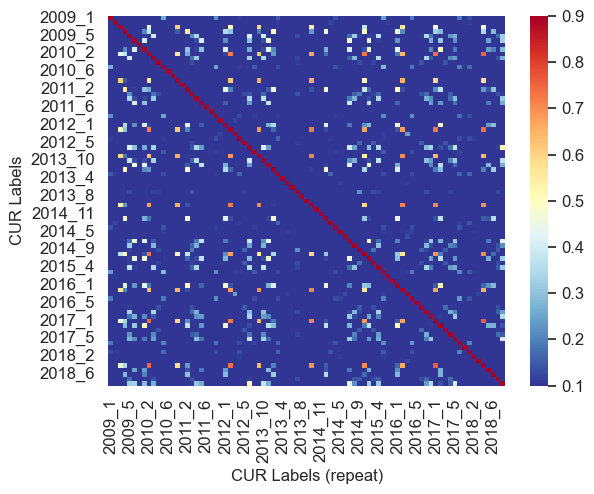

In [555]:
sns.heatmap(new_df_sim_pivot, annot=False, fmt=".2f", cmap="RdYlBu_r", 
            vmin=0.1, vmax=0.9, annot_kws={"fontsize":10})

In [556]:
new_df_sim_pivot.to_csv(f"../Clustering_Output/tracking_regimes_spatial_similarity_2009_2018_ORCA_025.csv")

In [557]:
# seaborn cluster map